# TER Picopatt - Analyse exploratoire

Importation des librairies principales et définition des dossiers de travail.

Nos fonctions utilisées pour lire les données sont dans le fichier `functions.py`

In [16]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import functions as fc

#  Dossiers de données et de sortie 

DATA_DIR = Path("/Users/akkouh/Desktop/dataproc")  # là où sont tes fichiers bruts
OUTPUT_DIR = Path("/Users/akkouh/Desktop/TER-Picopatt/outputs")
FIG_DIR = OUTPUT_DIR / "figures"

# Création automatique des dossiers
fc.create_folder(OUTPUT_DIR)
fc.create_folder(FIG_DIR)

# Vérification
print(" Environnement prêt :")
print(f" DATA_DIR   → {DATA_DIR}")
print(f" OUTPUT_DIR → {OUTPUT_DIR}")
print(f" FIG_DIR    → {FIG_DIR}")


pd.set_option("display.max_columns", 200)

 Environnement prêt :
 DATA_DIR   → /Users/akkouh/Desktop/dataproc
 OUTPUT_DIR → /Users/akkouh/Desktop/TER-Picopatt/outputs
 FIG_DIR    → /Users/akkouh/Desktop/TER-Picopatt/outputs/figures


Lecture de tous les fichiers de données (.csv, .xlsx) du dossier `dataproc` dans un seul tableau, nettoyage des colonnes, puis vérification de la couverture temporelle et la répartition des mesures et ajout des colonnes `M_slot` (créneau horaire) et `date`.

In [17]:
raw = fc.load_all(DATA_DIR)

# Résumé
print("\nChargement terminé.")
print("Couverture :", raw['date'].min(), "->", raw['date'].max())
print("Parcours :", raw['track_id'].dropna().unique())
print("\nNombre de mesures par M_slot et parcours :")
print(
    raw.pivot_table(index="track_id", columns="M_slot", values="fichier_originaire", aggfunc="count")
       .fillna(0)
       .astype(int)
)


picopatt_montpellier_antigone_20241029_0835.csv    ->  2024-10-29  M1
picopatt_montpellier_antigone_20241029_1127.csv    ->  2024-10-29  M2
picopatt_montpellier_antigone_20241029_1423.csv    ->  2024-10-29  M3
picopatt_montpellier_antigone_20241029_1722.csv    ->  2024-10-29  M4
picopatt_montpellier_antigone_20241107_0831.csv    ->  2024-11-07  M1
picopatt_montpellier_antigone_20241107_1122.csv    ->  2024-11-07  M2
picopatt_montpellier_antigone_20241107_1429.csv    ->  2024-11-07  M3
picopatt_montpellier_antigone_20241107_1727.csv    ->  2024-11-07  M4
picopatt_montpellier_antigone_20241119_0847.csv    ->  2024-11-19  M1
picopatt_montpellier_antigone_20241119_1127.csv    ->  2024-11-19  M2
picopatt_montpellier_antigone_20241119_1421.csv    ->  2024-11-19  M3
picopatt_montpellier_antigone_20241119_1724.csv    ->  2024-11-19  M4
picopatt_montpellier_antigone_20241128_0836.csv    ->  2024-11-28  M1
picopatt_montpellier_antigone_20241128_1124.csv    ->  2024-11-28  M2
picopatt_montpellier

Les données couvrent du `29 octobre au 16 janvier` soit environ 3 mois.

On a trois parcours de collecte : `Antigone, Boulevards et Écusson`.

On observe également `quatre passages par jour` (matin, midi, après-midi et soir), presque `tout les mardis et jeudis`.

Globalement, la base de données est bien équilibrée entre les parcours et les passages.

Cependant, on remarque que le parcours Écusson contient un peu moins de données, ce qui peut indiquer que certains passages n’ont pas été effectués, qu’un problème de mesure est survenu ou tout simplement moins de mesures ont été éffectues pour Écusson.

Taux de valeurs manquantes :


project_id          0.999790
section_warning     0.999658
section_duration    0.989238
section_speed       0.989238
section_weather     0.989238
gnss_accuracy       0.000003
lon_rtk             0.000003
lat_rtk             0.000003
lw_front            0.000000
sw_front            0.000000
sw_back             0.000000
sw_left             0.000000
sw_right            0.000000
lw_up               0.000000
lw_down             0.000000
lw_left             0.000000
lw_back             0.000000
sw_up               0.000000
lw_right            0.000000
tmrt                0.000000
dtype: float64

Nombre de points par parcours :


track_id
antigone      119139
boulevards    113452
ecusson       101180
Name: count, dtype: int64

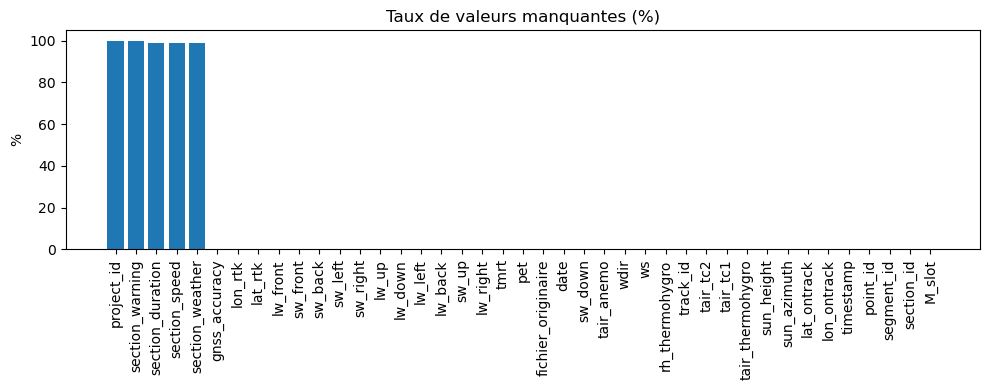

In [5]:
# Taux de valeurs manquantes
missing = raw.isna().mean().sort_values(ascending=False)
print("Taux de valeurs manquantes :")
display(missing.head(20))

# Comptage global par parcours
print("Nombre de points par parcours :")
display(raw["track_id"].value_counts())

# Calcul du pourcentage de valeurs manquantes sur les variables météo
na = raw.isna().mean().sort_values(ascending=False) * 100

COMPT = FIG_DIR / "comptage"
fc.create_folder(COMPT)

# Visualisation graphique
plt.figure(figsize=(10, 4))
plt.bar(na.index, na.values)
plt.title("Taux de valeurs manquantes (%)")
plt.xticks(rotation=90)
plt.ylabel("%")
plt.tight_layout()
plt.savefig(COMPT/"na_pct_vars.png", dpi=150)
plt.show()

Les variables climatiques présentent très peu de valeurs manquantes, ce qui garantit une base de données fiable et exploitable.

Certaines colonnes pour les sections sont quasiment vides, ce qui est normal compte tenu de la configuration du jeu de données, et elles pourront donc être ignorées lors des analyses.

On observe également le nombre total de relevés par parcours, avec Écusson qui présente le volume le plus faible.

Le bloc suivant affiche une `heatmap` montrant le nombre d’échantillons collectés pour chaque combinaison `parcours × M_slot` (M1 à M4).  
Cela permet d’identifier les périodes ou parcours avec plus ou moins de données.

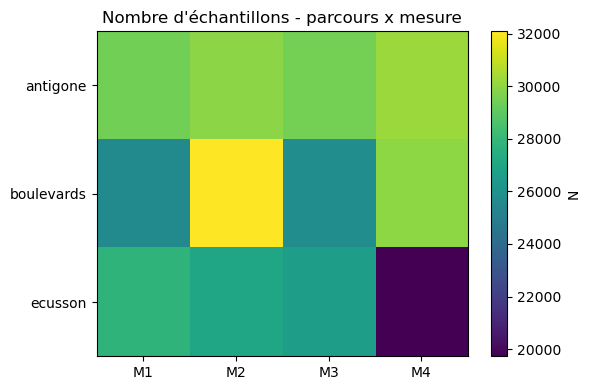

In [8]:
tab = (
    raw.dropna(subset=["track_id", "M_slot"])
       .pivot_table(
           index="track_id",
           columns="M_slot",
           values="timestamp",
           aggfunc="count",
           observed=True
       )
       .reindex(columns=["M1", "M2", "M3", "M4"])
       .fillna(0)
       .astype(int)
)

# Heatmap
plt.figure(figsize=(6, 4))
plt.imshow(tab.values, aspect="auto")
plt.xticks(range(tab.shape[1]), tab.columns)
plt.yticks(range(tab.shape[0]), tab.index)
plt.title("Nombre d'échantillons - parcours x mesure")
plt.colorbar(label="N")
plt.tight_layout()

# Sauvegarde et affichage
plt.savefig(COMPT/"heatmap_counts_parcours_M.png", dpi=150)
plt.show()

Le parcours `Antigone` possède le plus grand nombre de mesures sur l’ensemble des créneaux.

Le parcours `Boulevards` présente davantage de données sur le créneau M2 (midi), mais moins sur M3 (après-midi).
	
Le parcours `Écusson` contient globalement moins de mesures sur tous les créneaux.


# Pourquoi `Écusson` a moins de données ?

/var/folders/xz/8qmtfxds1qdftctg_8qnbryr0000gn/T/ipykernel_35687/487929916.py:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.drop_duplicates(subset=["date", "M_slot"]).shape[0])


track_id           date_debut             date_fin  nb_jours  \
0    antigone  2024-10-29 08:36:30  2025-01-09 19:08:20         7   
1  boulevards  2024-11-14 08:30:24  2025-01-16 19:26:41         6   
2     ecusson  2024-10-31 08:30:13  2025-01-14 19:18:28         6   

   nb_passages  M1  M2  M3  M4  
0           28   7   7   7   7  
1           22   5   6   5   6  
2           20   6   5   5   4

<Figure size 800x500 with 0 Axes>

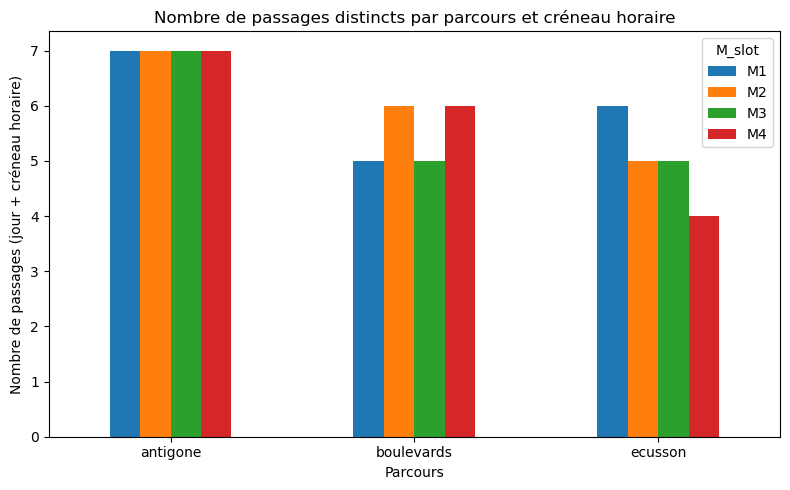

In [9]:
# Période de mesure et nombre de jours distincts
periode_parcours = (
    raw.dropna(subset=["track_id", "timestamp"])
       .groupby("track_id")
       .agg(
           date_debut=("timestamp", "min"),
           date_fin=("timestamp", "max"),
           nb_jours=("date", "nunique")
       )
       .reset_index()
)

# Nombre total de passages (jour + M_slot) par parcours
nb_passages_par_parcours = (
    raw.dropna(subset=["track_id", "M_slot", "date"])
       .groupby("track_id")[["date", "M_slot"]]
       .apply(lambda x: x.drop_duplicates(subset=["date", "M_slot"]).shape[0])
       .reset_index(name="nb_passages")
)

# Détail des passages par créneau horaire (M1, M2, M3, M4)
nb_passages_par_Mslot = (
    raw.dropna(subset=["track_id", "M_slot", "date"])
       .groupby(["track_id", "M_slot"])
       .apply(lambda x: x.drop_duplicates(subset=["date", "M_slot"]).shape[0])
       .reset_index(name="nb_passages")
       .pivot(index="track_id", columns="M_slot", values="nb_passages")
       .fillna(0)
       .astype(int)
)

# Fusion des résultats en un tableau unique
synthese_passages = (
    periode_parcours
    .merge(nb_passages_par_parcours, on="track_id", how="left")
    .merge(nb_passages_par_Mslot, on="track_id", how="left")
)

display(synthese_passages)

# Nombre de passages par parcours et créneau horaire
plt.figure(figsize=(8, 5))
nb_passages_par_Mslot.plot(
    kind="bar",
    figsize=(8, 5),
    rot=0,
    title="Nombre de passages distincts par parcours et créneau horaire"
)
plt.xlabel("Parcours")
plt.ylabel("Nombre de passages (jour + créneau horaire)")
plt.tight_layout()
plt.savefig(COMPT/"nb_passages_distincts_par_Mslot.png", dpi=150)
plt.show()

In [11]:
# Uniquement les fichiers liés à Écusson
paths_ecusson = sorted([p for p in DATA_DIR.rglob("*ecusson*") if p.suffix.lower() in (".csv", ".xlsx", ".xls")])

def get_dates_from_file(p):
    try:
        if p.suffix.lower() in (".xlsx", ".xls"):
            df = pd.read_excel(p)
        else:
            df = pd.read_csv(p, sep=None, engine="python")  # détection auto du séparateur
        if "timestamp" in df.columns:
            df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce", dayfirst=True)
            return sorted(df["timestamp"].dropna().dt.date.unique())
        else:
            return []
    except Exception as e:
        print(f" Erreur lecture {p.name}: {e}")
        return []

file_dates = pd.DataFrame([
    {"fichier": p.name, "dates_trouvées": get_dates_from_file(p)}
    for p in paths_ecusson
])

display(file_dates)

# Combien de jours distincts au total :
all_dates = sorted({d for sublist in file_dates["dates_trouvées"] for d in sublist})
print(f"\n Nombre total de jours uniques mesurés pour le parcours Écusson : {len(all_dates)}")

/var/folders/xz/8qmtfxds1qdftctg_8qnbryr0000gn/T/ipykernel_35687/2657569374.py:11: UserWarning: Parsing dates in %Y-%m-%d %H:%M:%S format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce", dayfirst=True)
/var/folders/xz/8qmtfxds1qdftctg_8qnbryr0000gn/T/ipykernel_35687/2657569374.py:11: UserWarning: Parsing dates in %Y-%m-%d %H:%M:%S format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce", dayfirst=True)
/var/folders/xz/8qmtfxds1qdftctg_8qnbryr0000gn/T/ipykernel_35687/2657569374.py:11: UserWarning: Parsing dates in %Y-%m-%d %H:%M:%S format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce", dayfirst=True)
/var/folders/xz/8qmtfxds1qdftct

fichier dates_trouvées
0   picopatt_montpellier_ecusson_20241031_0827.csv   [2024-10-31]
1   picopatt_montpellier_ecusson_20241031_1127.csv   [2024-10-31]
2   picopatt_montpellier_ecusson_20241031_1425.csv   [2024-10-31]
3   picopatt_montpellier_ecusson_20241112_0830.csv   [2024-12-11]
4   picopatt_montpellier_ecusson_20241112_1124.csv   [2024-12-11]
5   picopatt_montpellier_ecusson_20241112_1430.csv   [2024-12-11]
6   picopatt_montpellier_ecusson_20241112_1723.csv   [2024-12-11]
7   picopatt_montpellier_ecusson_20241121_0832.csv   [2024-11-21]
8   picopatt_montpellier_ecusson_20241121_1729.csv   [2024-11-21]
9   picopatt_montpellier_ecusson_20241203_0829.csv   [2024-03-12]
10  picopatt_montpellier_ecusson_20241203_1128.csv   [2024-03-12]
11  picopatt_montpellier_ecusson_20241203_1423.csv   [2024-03-12]
12  picopatt_montpellier_ecusson_20241203_1743.csv   [2024-03-12]
13  picopatt_montpellier_ecusson_20241212_0829.csv   [2024-12-12]
14  picopatt_montpellier_ecusson_20241212_1125.csv   [2024-12-12]
15  picopatt_montpellier_ecusson_20241212_1425.csv   [2024-12-12]
16  picopatt_montpellier_ecusson_20250114_0832.csv   [2025-01-14]
17  picopatt_montpellier_ecusson_20250114_1130.csv   [2025-01-14]
18  picopatt_montpellier_ecusson_20250114_1427.csv   [2025-01-14]
19  picopatt_montpellier_ecusson_20250114_1726.csv   [2025-01-14]


 Nombre total de jours uniques mesurés pour le parcours Écusson : 6


Le parcours `Antigone` a bénéficié de la couverture la plus complète, tandis que `Écusson` présente le moins de passages. Cela s'explique par le fait qu'`Écusson` est bénéficié d'une journée de collecte de moins que `Antigone` et `Boulevards` 

In [12]:
df_ecusson = raw[raw["track_id"] == "ecusson"]
sections_lues = sorted(df_ecusson["section_id"].dropna().unique())

# Le parcours doit avoir 75 sections
sections_theoriques = list(range(1, 76))

# On cherche les manquantes
sections_manquantes = sorted(set(sections_theoriques) - set(sections_lues))

print("Nombre total attendu :", len(sections_theoriques))
print("Nombre réellement lus :", len(sections_lues))
print("Sections manquantes :", sections_manquantes)

Nombre total attendu : 75
Nombre réellement lus : 73
Sections manquantes : [12, 32]


Nous savons que le nombre de sections pour le parcours `Écusson` est de 73.

Les sections 12 et 32 sont manquantes dans tout les fichiers d'`Écusson`. 

# Statistiques descriptives sur les variables météo

Calcul des statistiques globales, par parcours et par créneau horaire sur les variables météorologiques présentes dans les données nettoyées (dossier `clean_nozeros` issue du notebook `NoZero.ipynb`).

In [13]:
DATA_NOZERO = Path("outputs/clean_nozeros")
bd = fc.load_all(DATA_NOZERO, False)

# Liste des variables météo présentes (sans sw_back et sw_down)
CANDIDATES = [
    "tair_thermohygro","tair_tc1","tair_tc2","tair_anemo",
    "rh_thermohygro","ws","wdir",
    "sw_up","sw_front","sw_right",
    "lw_up","lw_down","lw_front","lw_back","lw_left","lw_right",
    "tmrt","pet"
]
METEO = [c for c in CANDIDATES if c in bd.columns]
num_cols = [c for c in METEO if c != "wdir"]  # variables numériques classiques

# Résumé
print("Chargement terminé.")
print("Couverture :", bd['date'].min(), "->", bd['date'].max())
print("Parcours :", bd['track_id'].dropna().unique())
print("\nNombre de mesures par M_slot et parcours :")
print(
    bd.pivot_table(index="track_id", columns="M_slot", values="fichier_originaire", aggfunc="count")
       .fillna(0)
       .astype(int)
)

Chargement terminé.
Couverture : 2024-10-29 -> 2025-01-16
Parcours : ['antigone' 'boulevards' 'ecusson']

Nombre de mesures par M_slot et parcours :
M_slot         M1     M2     M3     M4
track_id                              
antigone    29468  29924  29510  30237
boulevards  25603  32084  25785  29980
ecusson     33246  27041  26656  19730


In [14]:
stats_global = fc.summary_stats(bd, num_cols)
if "wdir" in METEO:
    stats_global.loc["wdir", "mean"] = fc.circular_mean_deg(bd["wdir"])

STATS = OUTPUT_DIR / "stats"
fc.create_folder(STATS)
stats_global.to_csv(STATS / "stats_global.xlsx")
display(stats_global)

mean         std         min         p10         p25  \
tair_thermohygro   12.021515    4.638870   -0.971618    6.232929    9.335851   
tair_tc1           20.853443  131.601804    0.007812    6.359375    9.320312   
tair_tc2           13.616227   54.300651    0.007812    6.468750    9.367188   
tair_anemo         14.228554    5.004685    1.000000    8.000000   11.000000   
rh_thermohygro     60.642850   11.973439   37.474861   45.518273   51.310979   
ws                  1.023370    0.825099    0.102889    0.180055    0.463000   
sw_up              65.854163   92.393993    0.000428    5.030293   13.089645   
sw_front           53.904685  101.919682    3.323424   14.270169   15.683490   
sw_right           56.164556   92.815451    2.769514   20.530716   21.434419   
lw_up             362.691077   27.785984  266.539351  325.274308  345.260339   
lw_down           391.142925   21.856867  330.894294  365.830911  377.684358   
lw_front          387.553905   21.724466  317.796248  360.739194  373.222495   
lw_back           385.581810   21.895145  309.552120  358.937379  371.629478   
lw_left           391.948376   22.252466  315.678162  364.429675  377.131547   
lw_right          387.542992   21.890288  313.077331  360.476501  372.937373   
tmrt               19.230075    8.786275    2.424655   11.728175   14.243747   
pet                11.089122    6.166764   -5.037205    4.430962    7.325749   
wdir              358.100050         NaN         NaN         NaN         NaN   

                      median         p75         p90          max  
tair_thermohygro   11.920729   14.745937   17.774090    25.053407  
tair_tc1           11.906250   14.734375   17.984375  2047.992188  
tair_tc2           11.882812   14.648438   17.906250  2047.992188  
tair_anemo         14.000000   17.000000   20.000000    30.000000  
rh_thermohygro     58.862287   69.612268   78.121080    87.657969  
ws                  0.823110    1.337554    2.057776     9.362881  
sw_up              34.053128   72.658412  160.214051   712.930225  
sw_front           26.275124   47.345428   87.886798   984.895425  
sw_right           29.659654   49.208340   90.727283   957.943577  
lw_up             364.639019  380.900874  396.168807   457.708289  
lw_down           388.989229  401.265843  423.235487   512.178666  
lw_front          386.247660  398.717118  419.034290   532.448403  
lw_back           384.083456  396.647837  416.719554   479.900517  
lw_left           390.928953  403.528925  423.382151   520.479126  
lw_right          386.979204  399.180237  417.736623   526.091224  
tmrt               16.998373   21.471098   27.593693    73.053752  
pet                10.194926   14.145664   18.939163    55.898584  
wdir                     NaN         NaN         NaN          NaN

In [15]:
# Statistiques par parcours
track_code = {
    "antigone": "a",
    "boulevard": "b",
    "ecusson": "e"
}

by_track = []
for t, g in bd.groupby("track_id", dropna=True):
    s = fc.summary_stats(g, num_cols)
    if "wdir" in METEO:
        s.loc["wdir", "mean"] = fc.circular_mean_deg(g["wdir"])
    s = s.reset_index(names="variable")

    # Ajout de la lettre du parcours à chaque variable
    suffix = track_code.get(t, t[:1].lower())
    s["variable"] = s["variable"] + f"_{suffix}"

    by_track.append(s)

stats_by_track = pd.concat(by_track, ignore_index=True)
stats_by_track.to_csv(STATS / "stats_par_parcours.xlsx", index=False)
display(stats_by_track)

variable        mean         std         min         p10  \
0   tair_thermohygro_a   14.177994    4.123895    5.629435    9.143587   
1           tair_tc1_a   14.092342    4.172769    5.390625    8.937500   
2           tair_tc2_a   14.064750    4.143038    5.367188    9.000000   
3         tair_anemo_a   16.501993    4.680601    7.000000   11.000000   
4     rh_thermohygro_a   68.570538   10.829174   46.920195   53.412909   
5                 ws_a    1.092998    0.894862    0.102889    0.257222   
6              sw_up_a   94.455054  105.301497    0.002999   14.898083   
7           sw_front_a   67.947763  111.095746    3.323424   14.256144   
8           sw_right_a   75.079200  117.226613    2.769514   20.462802   
9              lw_up_a  366.838416   28.618377  288.241808  327.819056   
10           lw_down_a  401.273441   22.528045  359.659400  376.378997   
11          lw_front_a  395.561593   21.827570  344.640752  368.919511   
12           lw_back_a  394.607288   21.628140  348.271464  367.787364   
13           lw_left_a  399.527796   22.611704  347.433442  371.863234   
14          lw_right_a  394.164621   22.008635  343.727495  367.253531   
15              tmrt_a   22.238780   10.030292    8.016661   13.266549   
16               pet_a   13.642982    6.369767    0.551952    6.718174   
17              wdir_a  358.564445         NaN         NaN         NaN   
18  tair_thermohygro_b   11.019273    2.968663    3.653391    7.306401   
19          tair_tc1_b   10.830317    3.046388    2.937500    6.773438   
20          tair_tc2_b   10.819374    3.005960    2.937500    6.882812   
21        tair_anemo_b   13.299686    3.241764    6.000000   10.000000   
22    rh_thermohygro_b   57.522311    9.506956   38.352255   44.837339   
23                ws_b    1.020857    0.824369    0.102889    0.102889   
24             sw_up_b   62.567761   88.938030    0.000428    5.723935   
25          sw_front_b   56.894598  117.396343   12.031909   14.296027   
26          sw_right_b   52.378455   83.472330   18.538585   20.575992   
27             lw_up_b  353.852774   23.576820  281.144396  320.483208   
28           lw_down_b  383.660552   13.520189  337.687523  367.361038   
29          lw_front_b  379.931868   14.493067  327.535134  360.961640   
30           lw_back_b  378.295737   14.134415  329.312336  359.785145   
31           lw_left_b  384.835810   15.634387  328.149792  364.473630   
32          lw_right_b  381.373014   15.621137  325.453064  361.189820   
33              tmrt_b   17.969875    7.827868    5.532615   11.706508   
34               pet_b    9.881535    4.648645   -1.556058    4.671815   
35              wdir_b    0.512418         NaN         NaN         NaN   
36  tair_thermohygro_e   10.678960    5.657596   -0.971618    1.287480   
37          tair_tc1_e   40.053428  237.836344    0.007812    5.070312   
38          tair_tc2_e   16.277057   99.080553    0.007812    5.296875   
39        tair_anemo_e   12.677332    5.909160    1.000000    3.000000   
40    rh_thermohygro_e   55.107566   10.847374   37.474861   42.933776   
41                ws_e    0.948279    0.732814    0.102889    0.154333   
42             sw_up_e   38.723887   69.523572    0.000428    2.215411   
43          sw_front_e   35.040587   63.317772    9.894890   14.249570   
44          sw_right_e   39.066219   62.712607   12.870521   20.530716   
45             lw_up_e  367.459043   28.714921  266.539351  327.902406   
46           lw_down_e  387.786410   23.931100  330.894294  356.061969   
47          lw_front_e  386.716836   24.726253  317.796248  353.270171   
48           lw_back_e  383.250696   25.236795  309.552120  348.657112   
49           lw_left_e  391.047776   25.001541  315.678162  357.210654   
50          lw_right_e  386.709624   25.166399  313.077331  353.193653   
51              tmrt_e   17.210052    7.218835    2.424655    9.876965   
52               pet_e    9.521140    6.430849   -5.037205    1.823021   
53              wd

In [38]:
# Statistiques par parcours et créneau horaire
by_mslot = []
for (t, mslot), g in bd.groupby(["track_id", "M_slot"], dropna=True):
    s = fc.summary_stats(g, num_cols)
    if "wdir" in METEO and "wdir" in g.columns:
        s.loc["wdir", "mean"] = fc.circular_mean_deg(g["wdir"])
    s = s.reset_index(names="variable")

    # Ajout du suffixe parcours + Mslot 
    # ex: 'v'_aM1
    suffix = track_code.get(t, t[:1].lower())
    s["variable"] = s["variable"] + f"_{suffix}{mslot}"

    by_mslot.append(s)

stats_track_M = pd.concat(by_mslot, ignore_index=True)

# Tri des variables par parcours et mslot
stats_track_M["sort_key"] = stats_track_M["variable"].str.extract(r"_(.M\d)").astype(str)
stats_track_M = stats_track_M.sort_values("variable").drop(columns="sort_key")

stats_track_M.to_csv(STATS / "stats_par_parcours_par_mesure.xlsx", index=False)
display(stats_track_M)

variable        mean        std         min         p10         p25  \
12   lw_back_aM1  384.779002  19.699960  351.538890  360.811563  368.169548   
30   lw_back_aM2  401.392051  20.743852  365.955424  375.464920  387.228131   
48   lw_back_aM3  401.590548  21.693994  348.271464  372.829392  390.968773   
66   lw_back_aM4  390.655730  19.413165  348.855602  368.780922  375.058050   
84   lw_back_bM1  366.744207  12.466019  329.312336  351.067982  358.070420   
..           ...         ...        ...         ...         ...         ...   
131       ws_bM4    0.772245   0.488634    0.102889    0.102889    0.360111   
149       ws_eM1    0.836469   0.600129    0.102889    0.102889    0.411555   
167       ws_eM2    1.041472   0.793649    0.102889    0.180055    0.463000   
185       ws_eM3    0.987694   0.745512    0.102889    0.180055    0.463000   
203       ws_eM4    0.967926   0.819321    0.102889    0.102889    0.411555   

         median         p75         p90         max  
12   381.446713  401.103398  416.322287  436.802259  
30   396.302418  417.005842  430.818197  475.119119  
48   398.554780  417.460345  434.326986  476.927509  
66   387.528022  409.869671  418.217432  436.832678  
84   367.089764  375.685884  383.389591  400.411764  
..          ...         ...         ...         ...  
131    0.720222    1.080332    1.440443    3.035220  
149    0.720222    1.131777    1.646221    7.202216  
167    0.874555    1.440443    2.109220    6.944994  
185    0.823110    1.337554    1.954887    7.407994  
203    0.771666    1.337554    2.006332    6.739216  

[216 rows x 10 columns]

# Matrices de corrélation par parcours

Affiche les `corrélations entre les variables météorologiques` pour chaque parcours.  

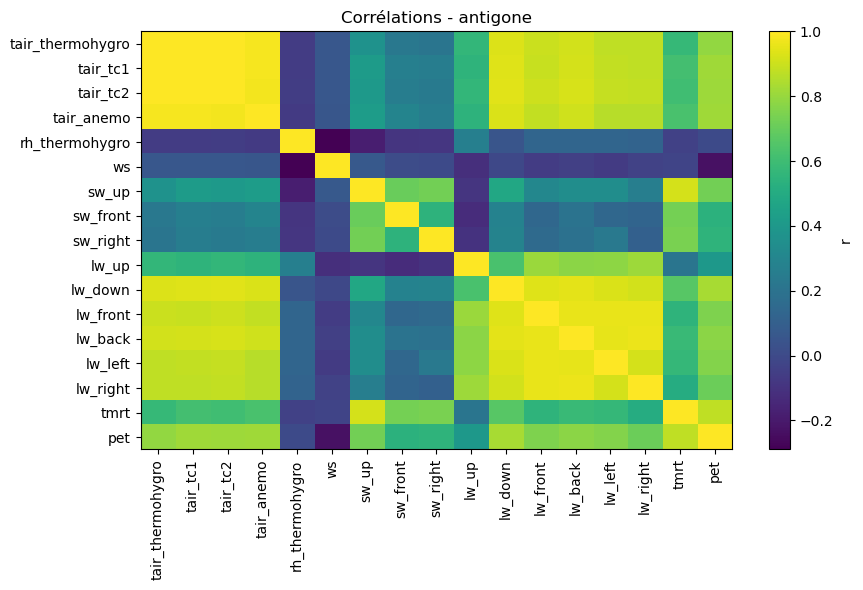

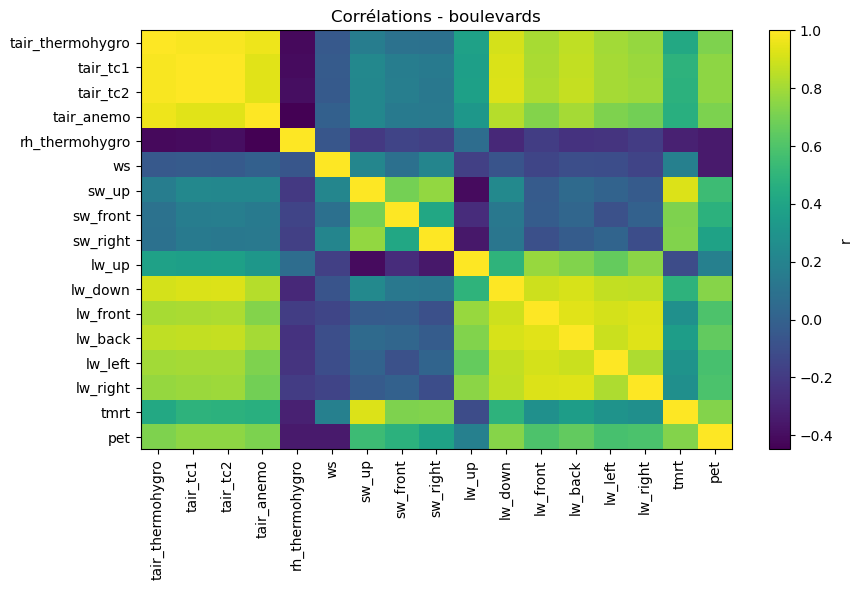

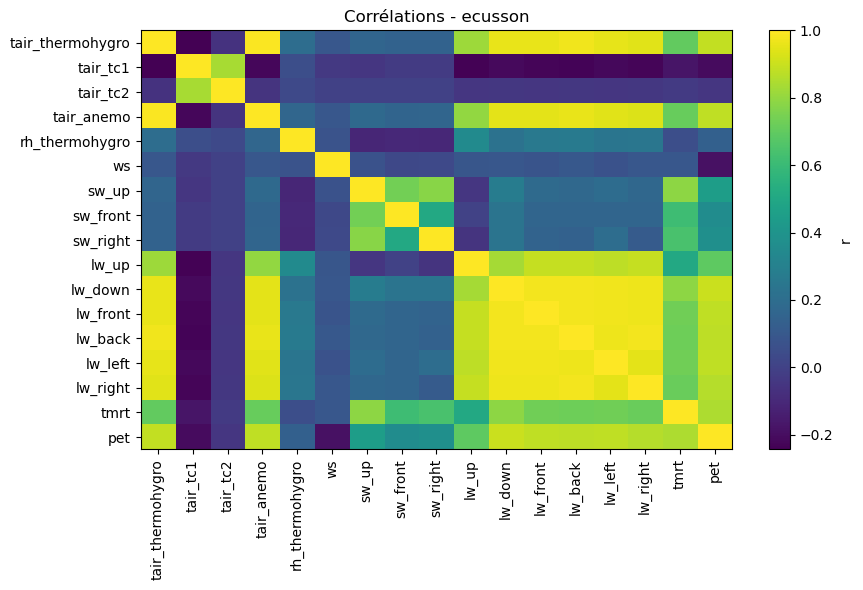

In [39]:
CORR = FIG_DIR / "correlation"
fc.create_folder(CORR)

for t, g in bd.groupby("track_id"):
    sel = g[num_cols].select_dtypes(include=[np.number]).dropna(how="all", axis=1)
    
    if sel.shape[1] < 2: 
        print(f"Parcours {t} : pas assez de colonnes numériques pour corrélation.")
        continue

    corr = sel.corr()

    plt.figure(figsize=(9, 6))
    plt.title(f"Corrélations - {t}")
    plt.imshow(corr, aspect="auto")
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.index)), corr.index)
    plt.colorbar(label="r")
    plt.tight_layout()
    plt.savefig(CORR / f"corr_{t}.png", dpi=150)
    plt.show()

# Boxplots

Ce bloc affiche des `boxplots` pour comparer la distribution de chaques variables météorologiques clés entre les différents parcours .

<Figure size 700x400 with 0 Axes>

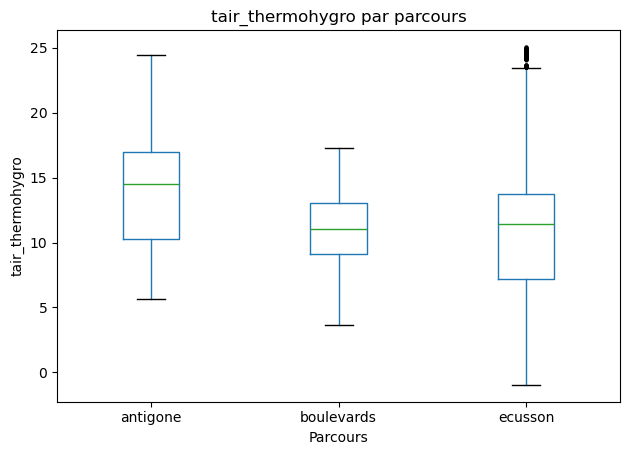

<Figure size 700x400 with 0 Axes>

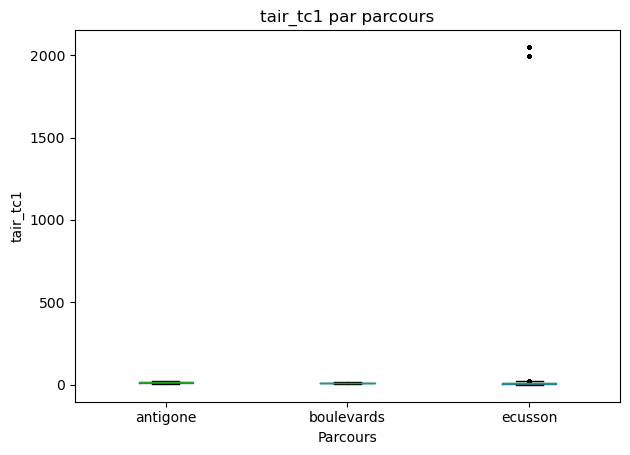

<Figure size 700x400 with 0 Axes>

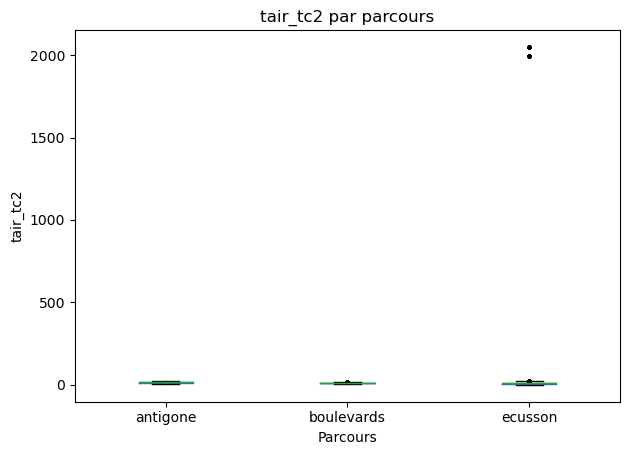

<Figure size 700x400 with 0 Axes>

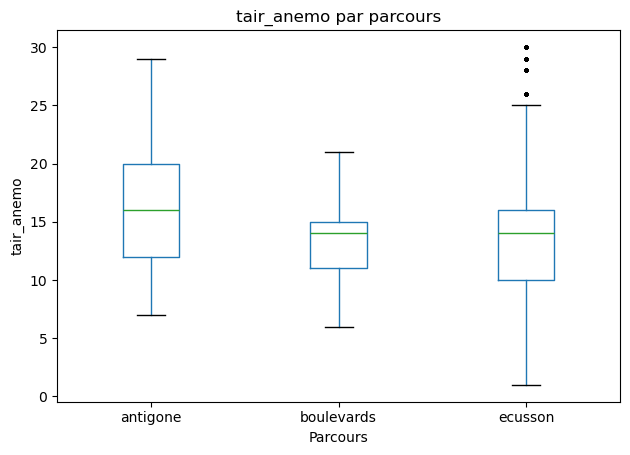

<Figure size 700x400 with 0 Axes>

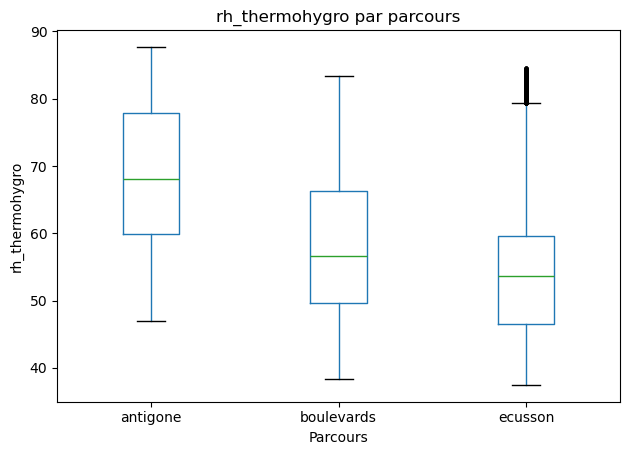

<Figure size 700x400 with 0 Axes>

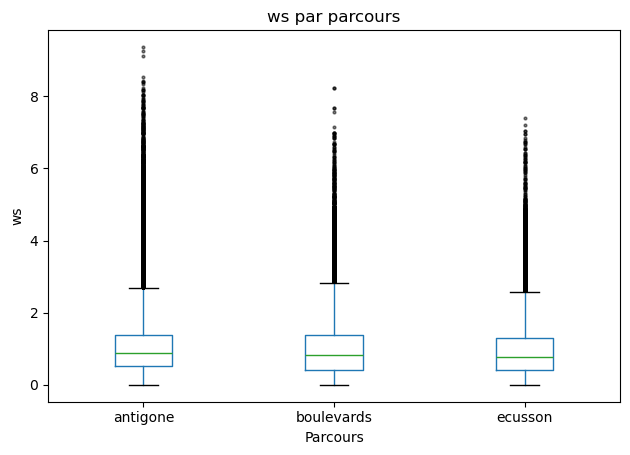

<Figure size 700x400 with 0 Axes>

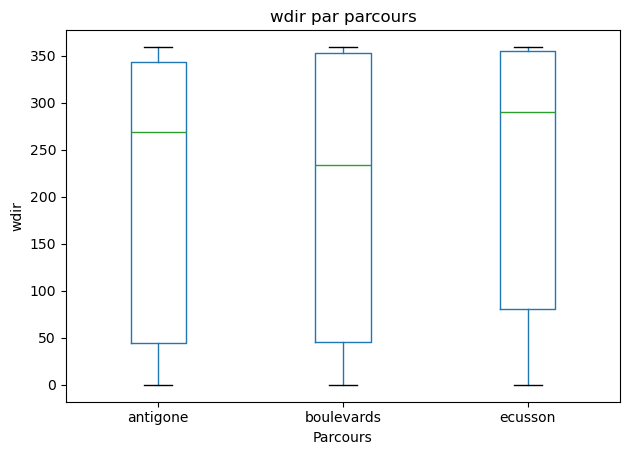

<Figure size 700x400 with 0 Axes>

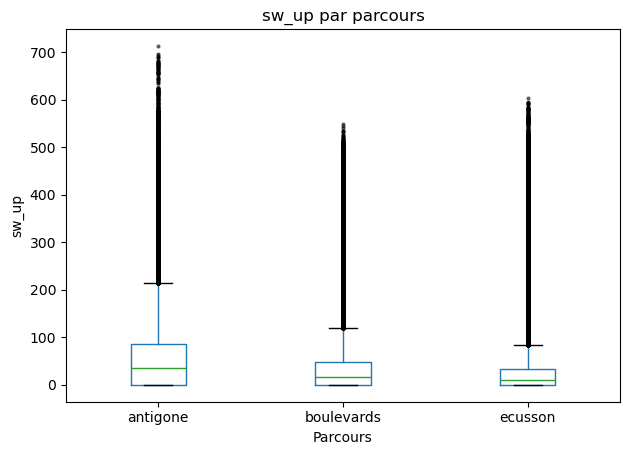

<Figure size 700x400 with 0 Axes>

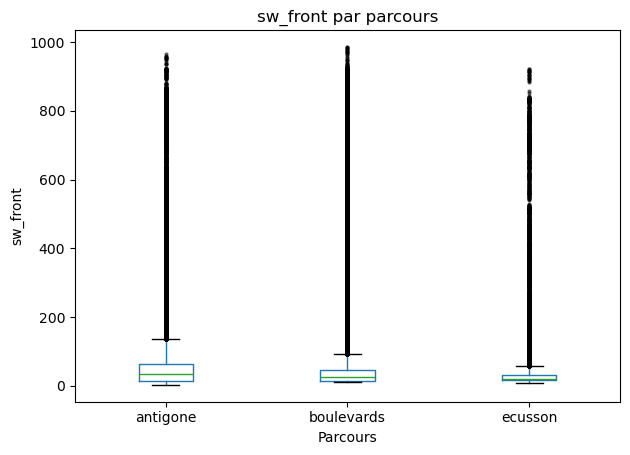

<Figure size 700x400 with 0 Axes>

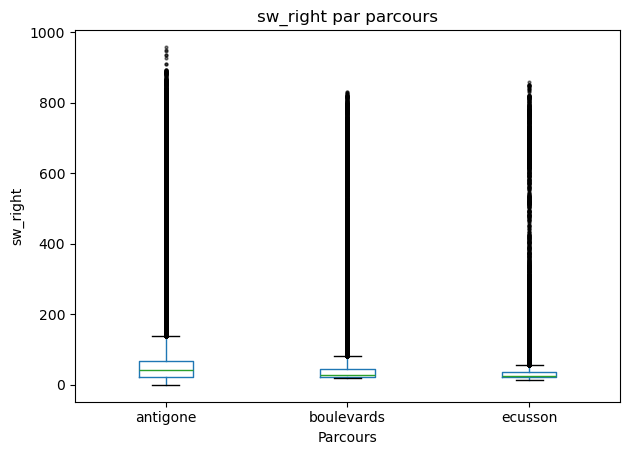

<Figure size 700x400 with 0 Axes>

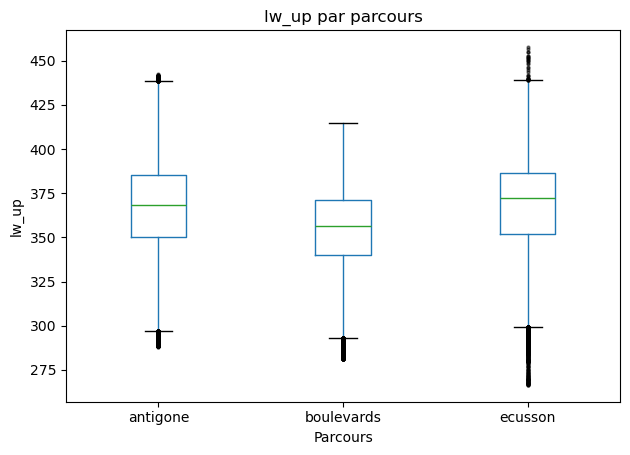

<Figure size 700x400 with 0 Axes>

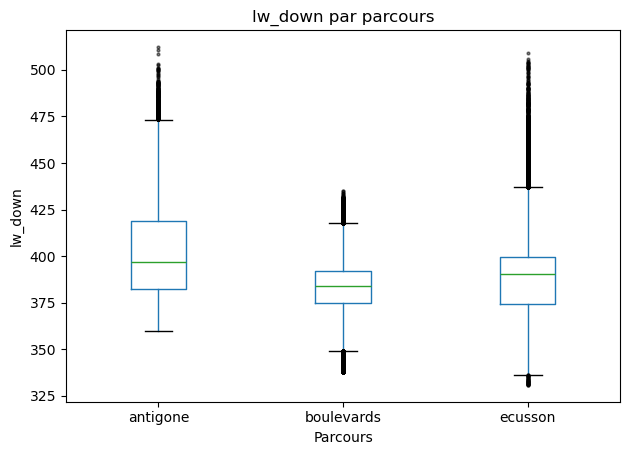

<Figure size 700x400 with 0 Axes>

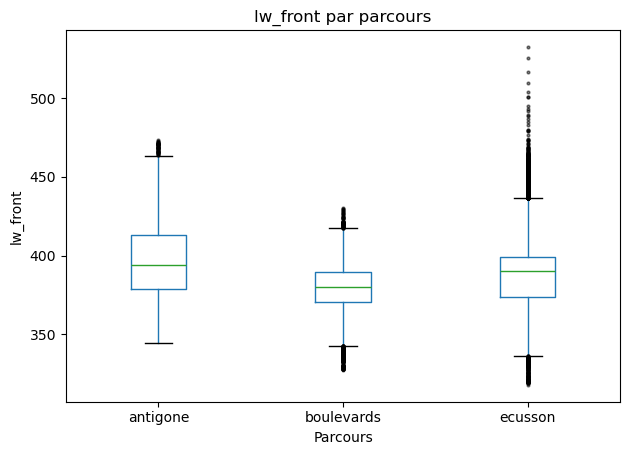

<Figure size 700x400 with 0 Axes>

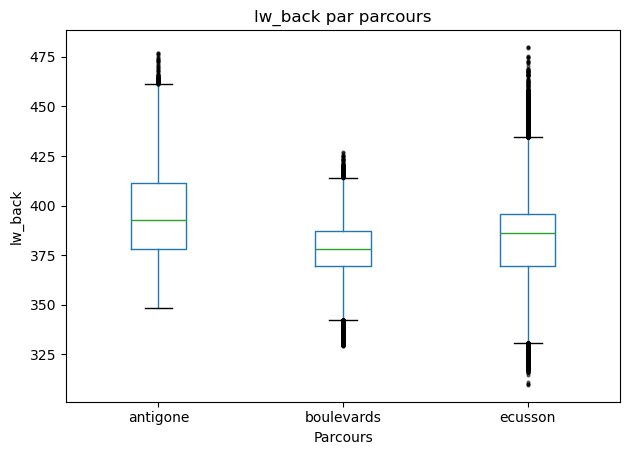

<Figure size 700x400 with 0 Axes>

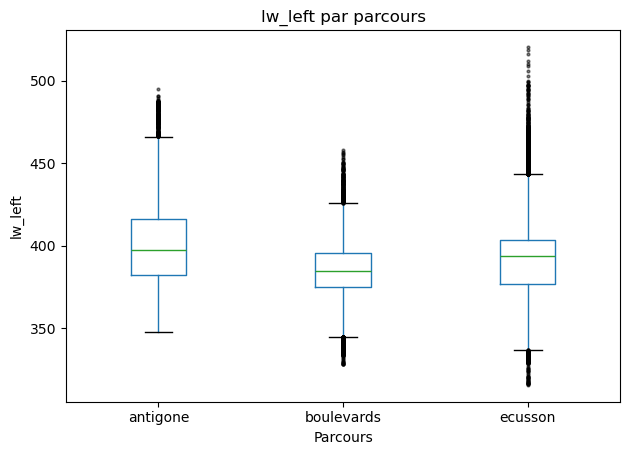

<Figure size 700x400 with 0 Axes>

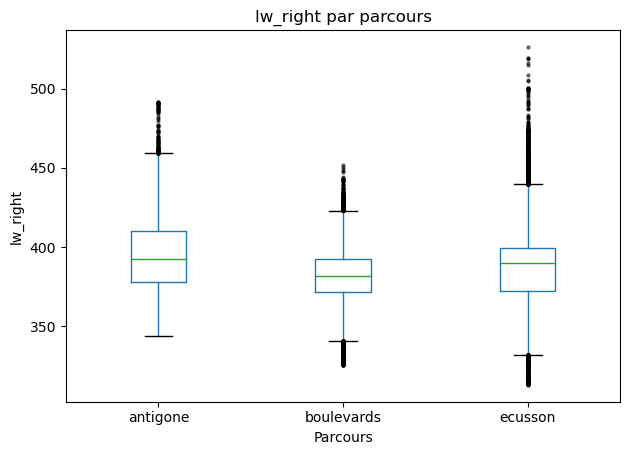

<Figure size 700x400 with 0 Axes>

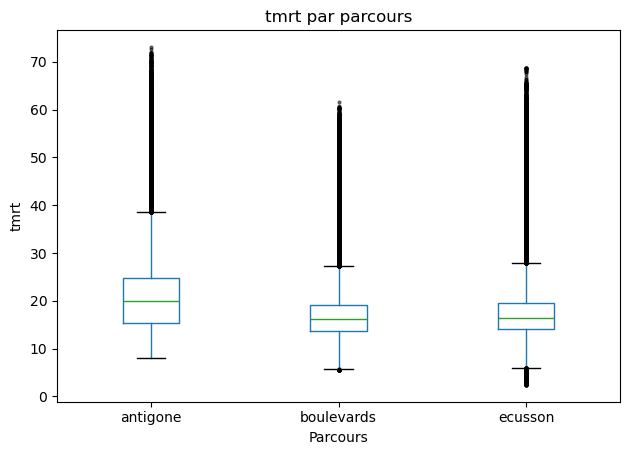

<Figure size 700x400 with 0 Axes>

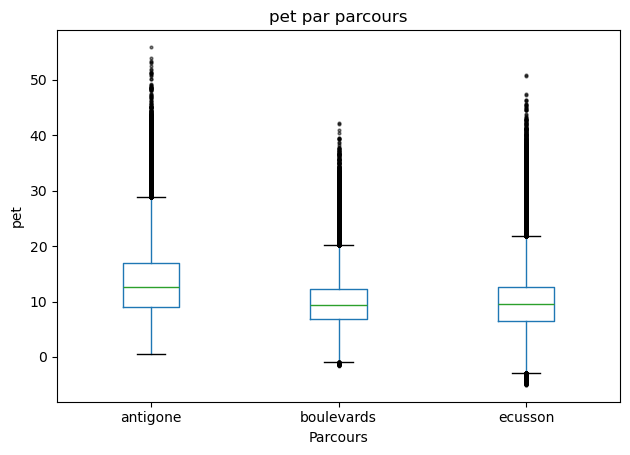

In [40]:
BOXPLOT = FIG_DIR / "boxplot"
fc.create_folder(BOXPLOT)

flierprops = dict(marker='o', markerfacecolor='black', markersize=2, linestyle='none', alpha=0.5)

for v in METEO:
    plt.figure(figsize=(7, 4))
    raw.boxplot(column=v, by="track_id", grid=False, flierprops=flierprops)
    plt.title(f"{v} par parcours") 
    plt.suptitle("")  
    plt.xlabel("Parcours")
    plt.ylabel(v)
    plt.tight_layout()
    plt.savefig(BOXPLOT / f"box{v}_parcours.png", dpi=150)
    plt.show()

## Distribution des variables météo par section au sein de chaque parcours

Ce bloc génère des **Boxplots** pour chaque variable météorologique, visualisant sa distribution pour chaque `section_id` au sein de chaque `track_id` (parcours). Cela permet d'identifier les variations des conditions météo le long de chaque parcours et de détecter d'éventuels anomalies ou spécificités liées à des sections particulières.

Genere des boxplots pour les parcours: antigone


<Figure size 1000x600 with 0 Axes>

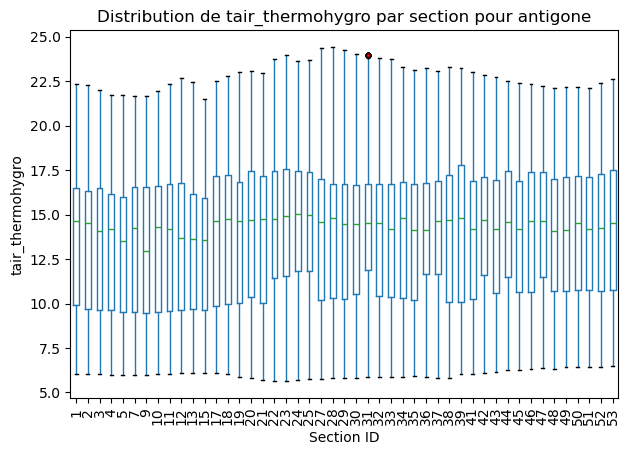

<Figure size 1000x600 with 0 Axes>

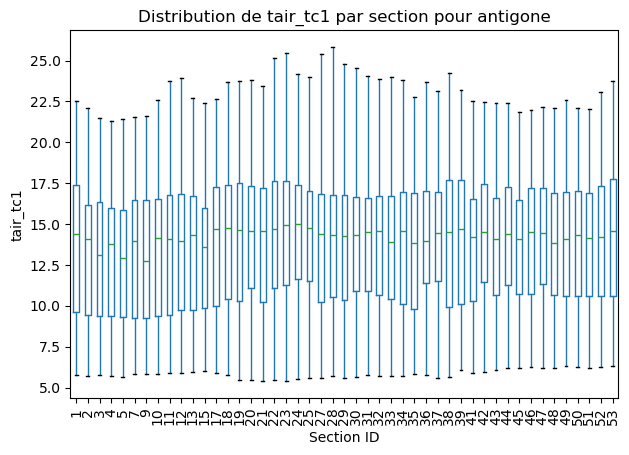

<Figure size 1000x600 with 0 Axes>

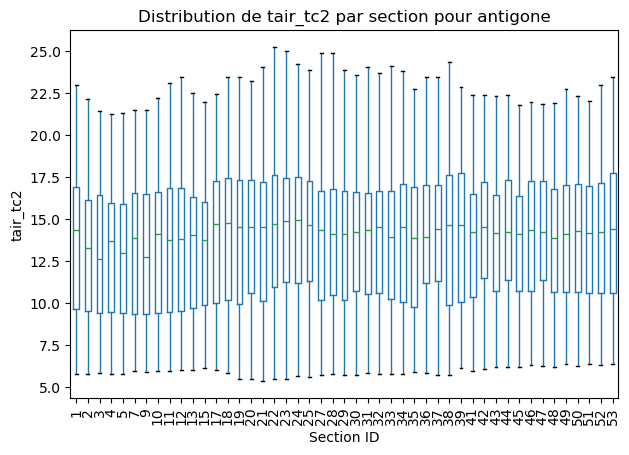

<Figure size 1000x600 with 0 Axes>

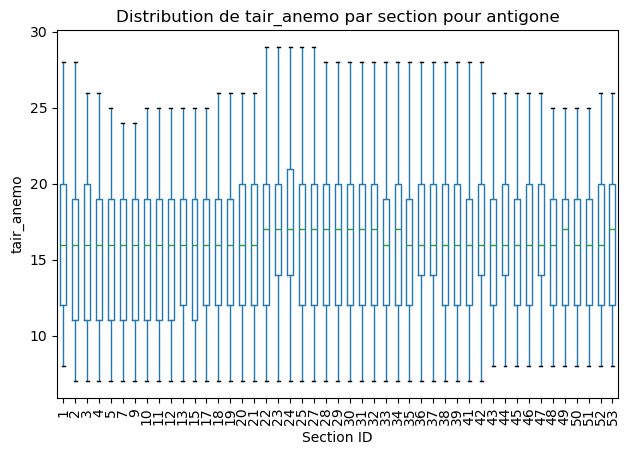

<Figure size 1000x600 with 0 Axes>

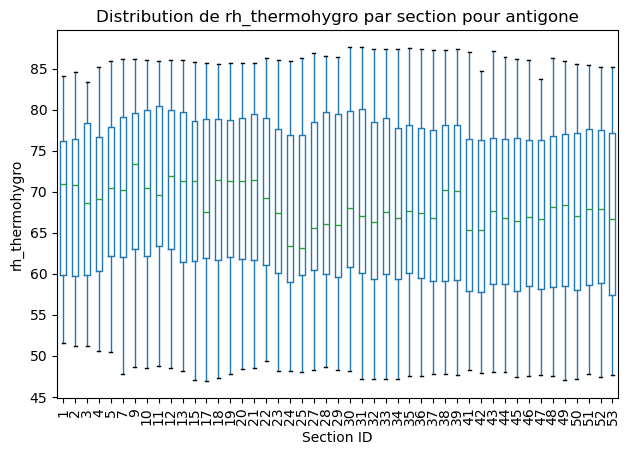

<Figure size 1000x600 with 0 Axes>

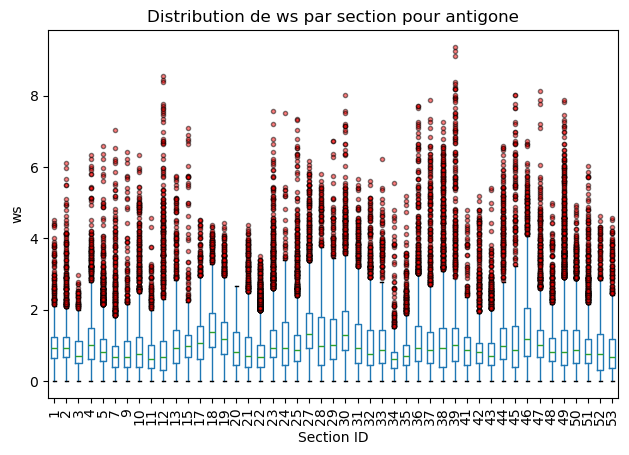

<Figure size 1000x600 with 0 Axes>

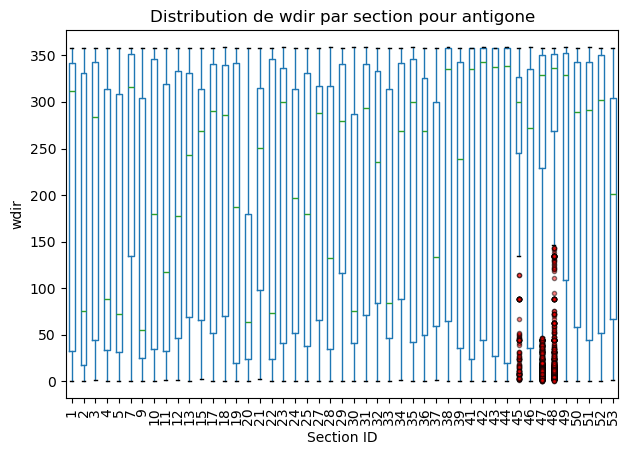

<Figure size 1000x600 with 0 Axes>

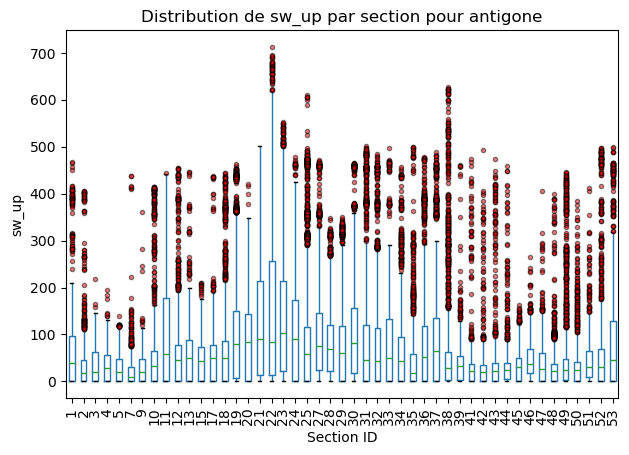

<Figure size 1000x600 with 0 Axes>

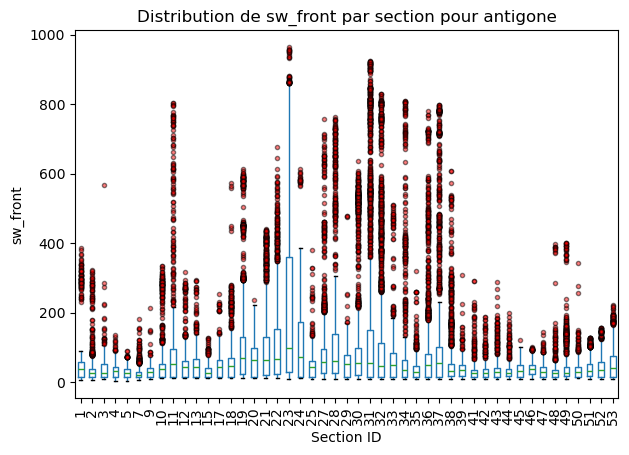

<Figure size 1000x600 with 0 Axes>

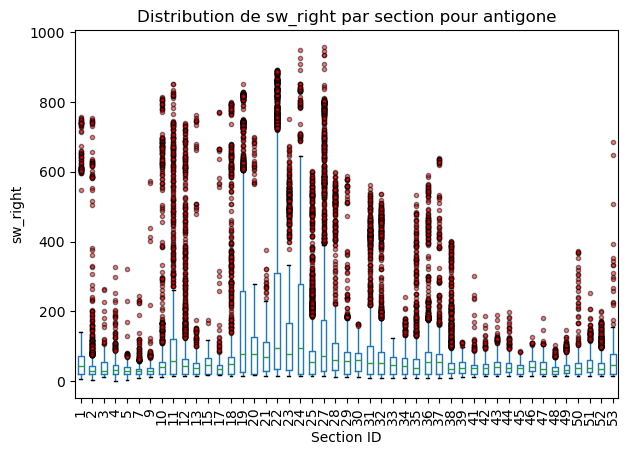

<Figure size 1000x600 with 0 Axes>

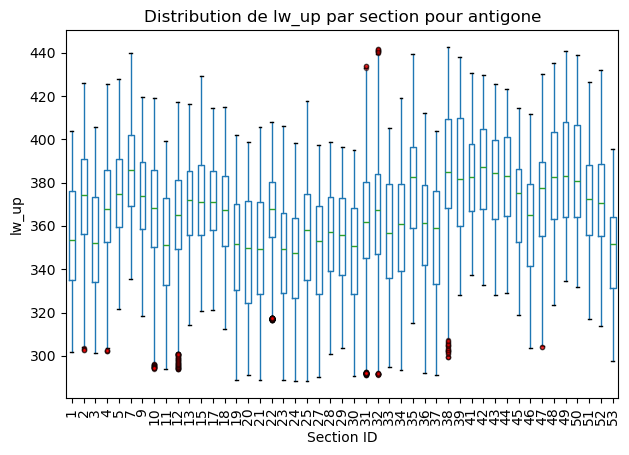

<Figure size 1000x600 with 0 Axes>

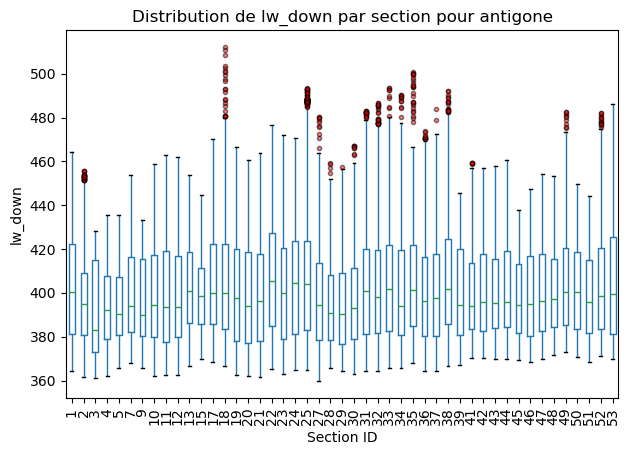

<Figure size 1000x600 with 0 Axes>

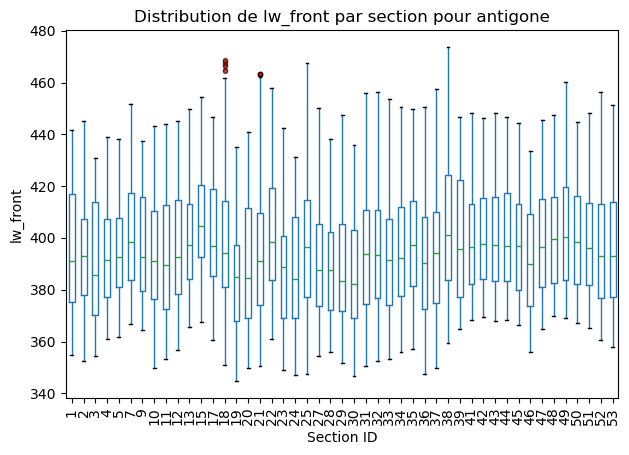

<Figure size 1000x600 with 0 Axes>

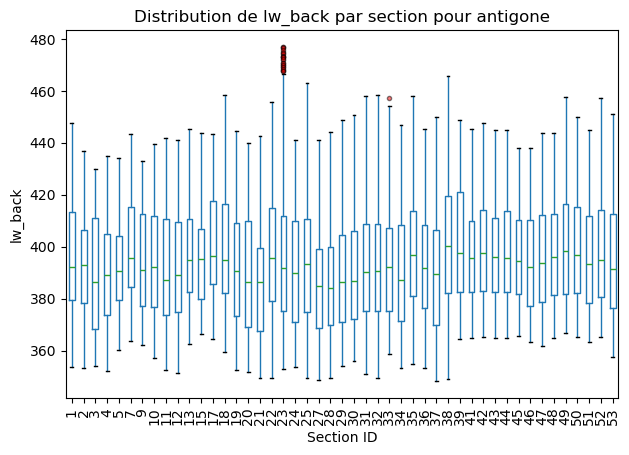

<Figure size 1000x600 with 0 Axes>

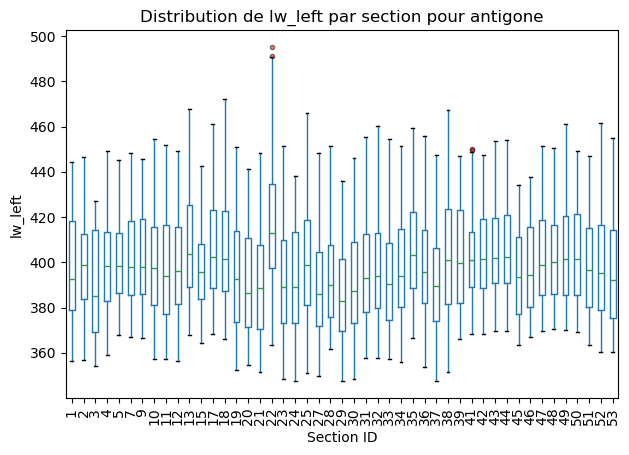

<Figure size 1000x600 with 0 Axes>

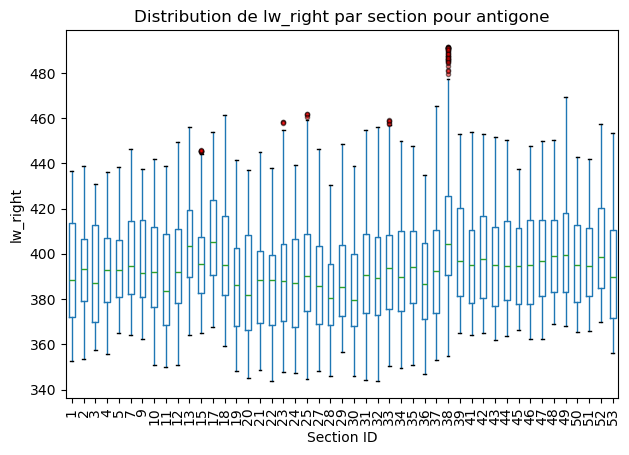

<Figure size 1000x600 with 0 Axes>

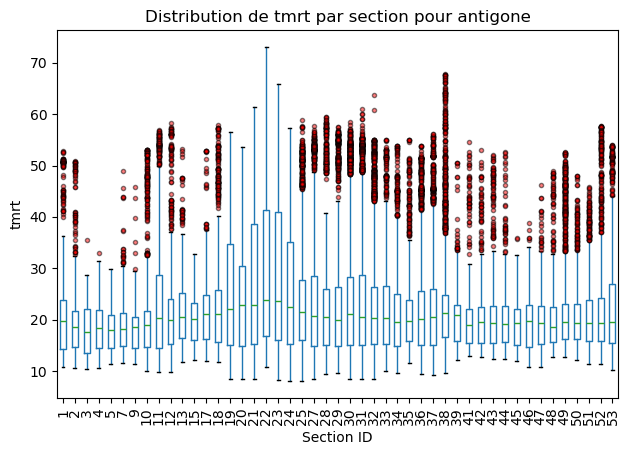

<Figure size 1000x600 with 0 Axes>

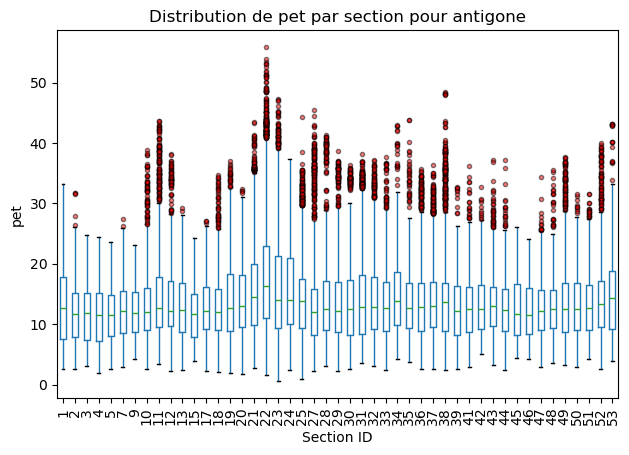

Genere des boxplots pour les parcours: boulevards


<Figure size 1000x600 with 0 Axes>

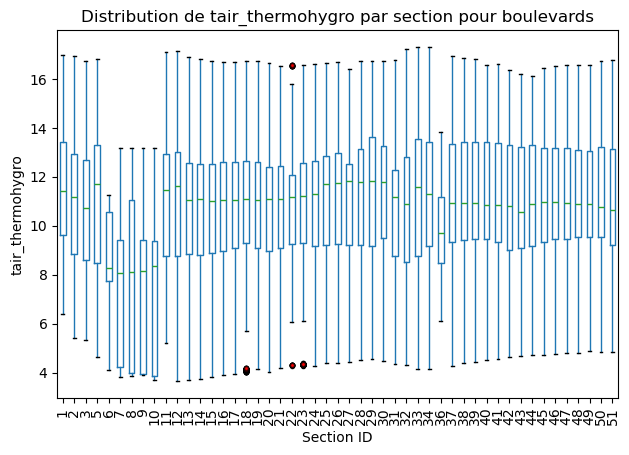

<Figure size 1000x600 with 0 Axes>

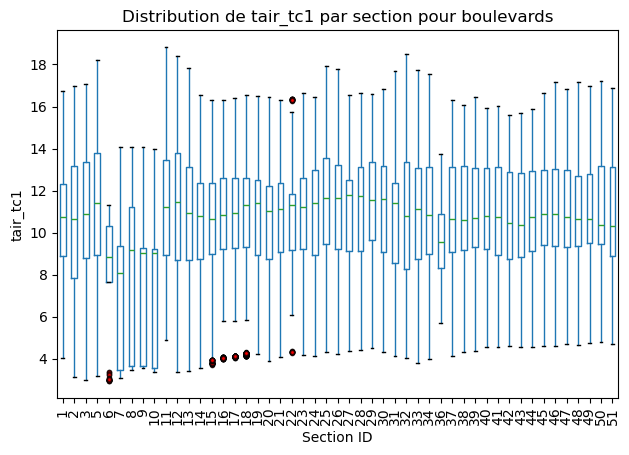

<Figure size 1000x600 with 0 Axes>

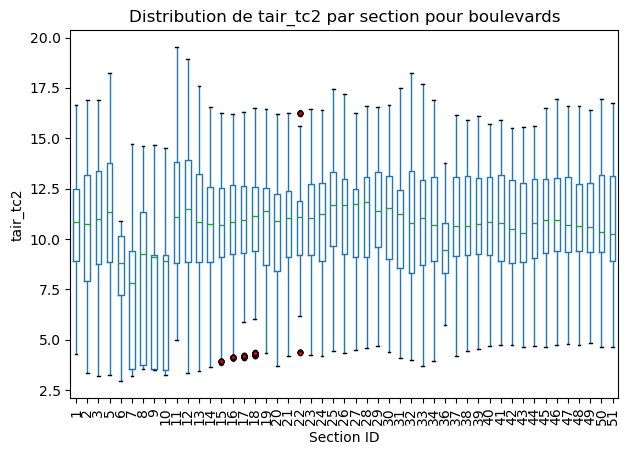

<Figure size 1000x600 with 0 Axes>

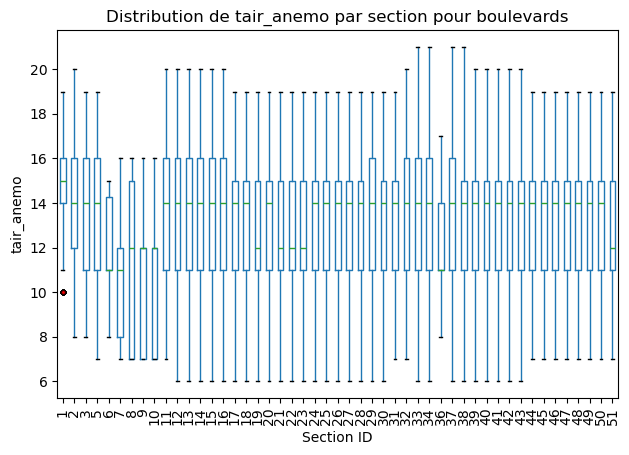

<Figure size 1000x600 with 0 Axes>

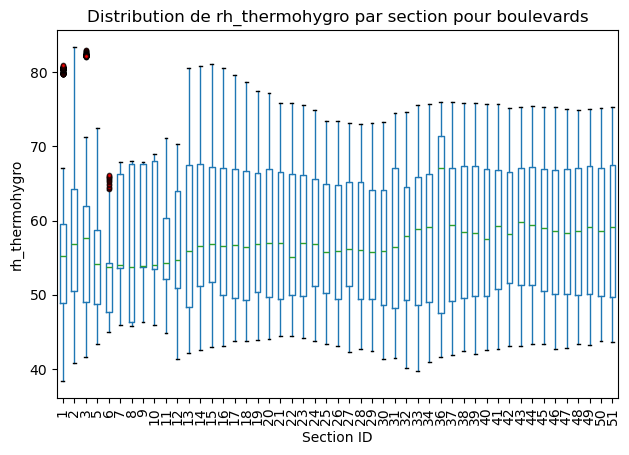

<Figure size 1000x600 with 0 Axes>

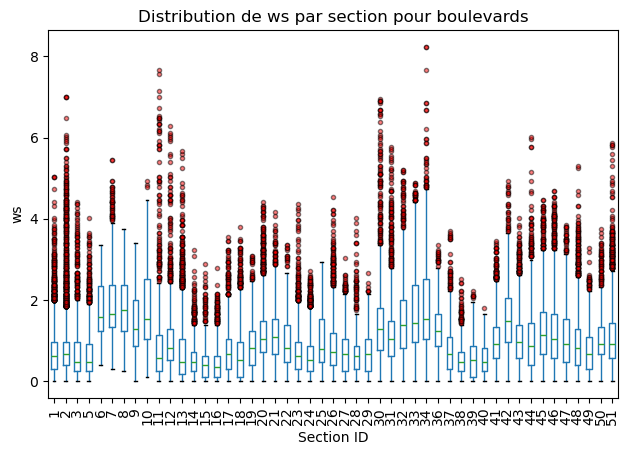

<Figure size 1000x600 with 0 Axes>

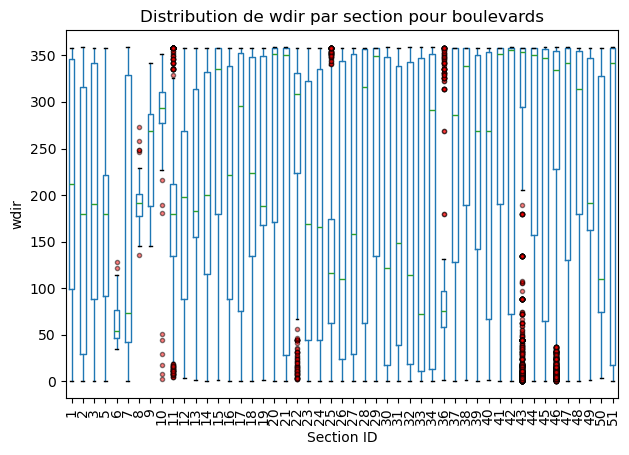

<Figure size 1000x600 with 0 Axes>

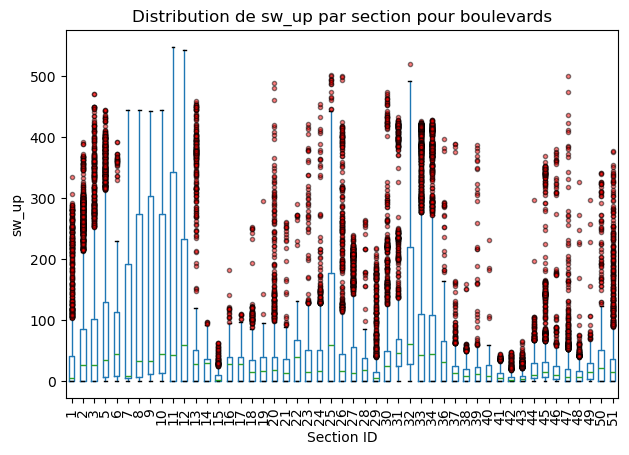

<Figure size 1000x600 with 0 Axes>

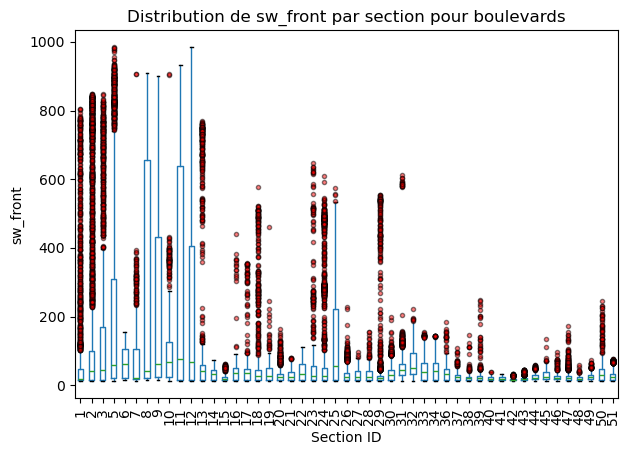

<Figure size 1000x600 with 0 Axes>

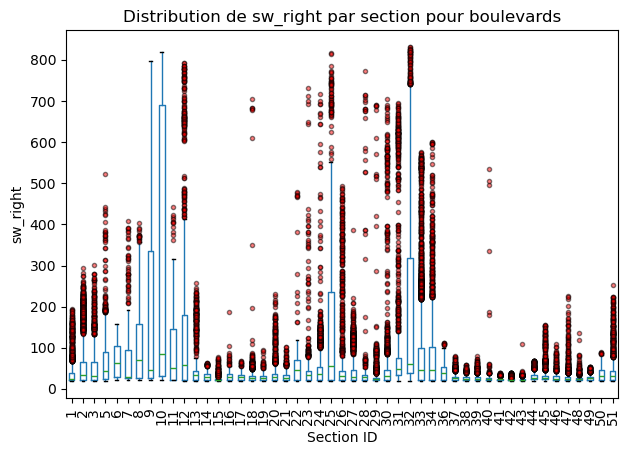

<Figure size 1000x600 with 0 Axes>

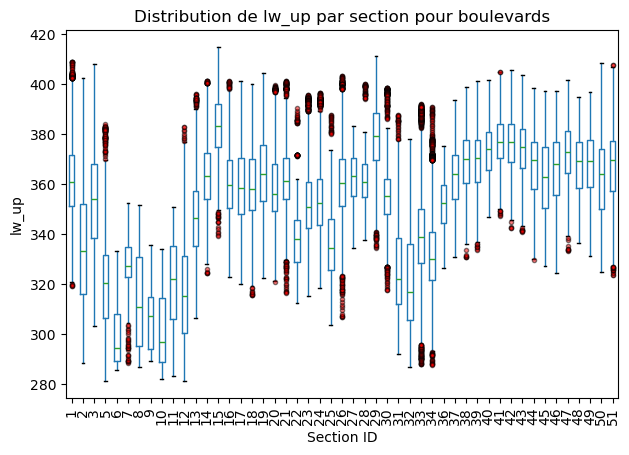

<Figure size 1000x600 with 0 Axes>

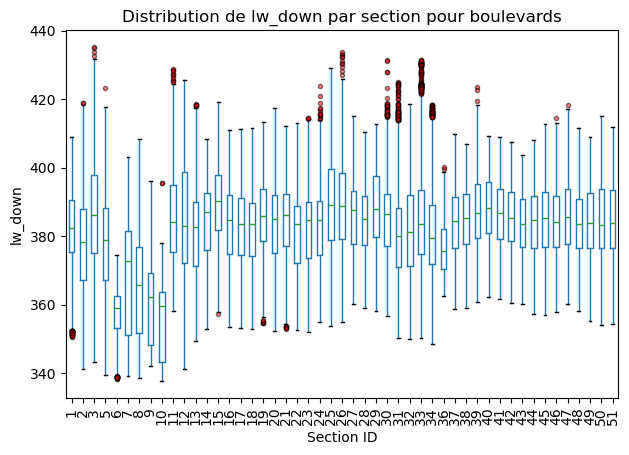

<Figure size 1000x600 with 0 Axes>

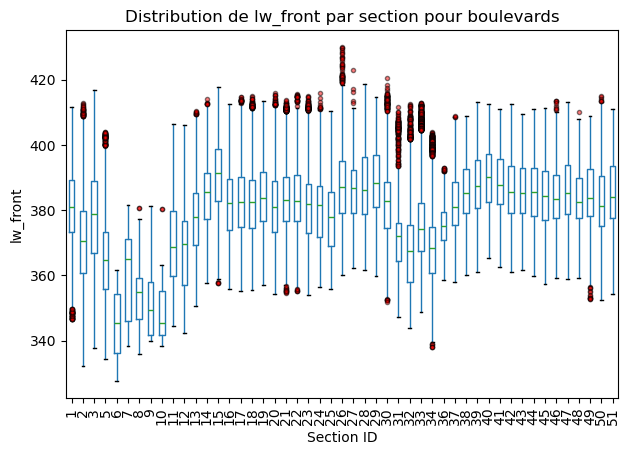

<Figure size 1000x600 with 0 Axes>

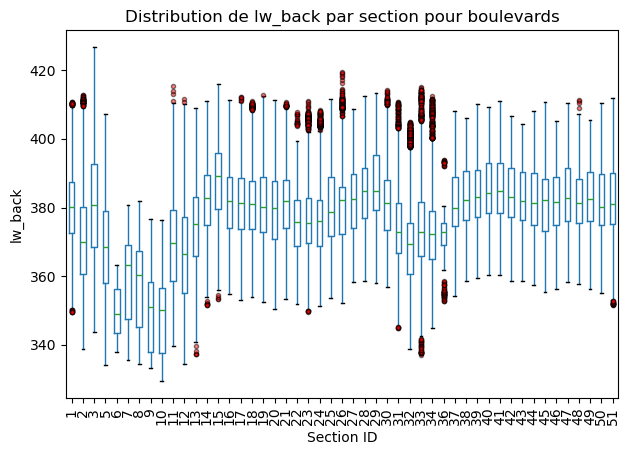

<Figure size 1000x600 with 0 Axes>

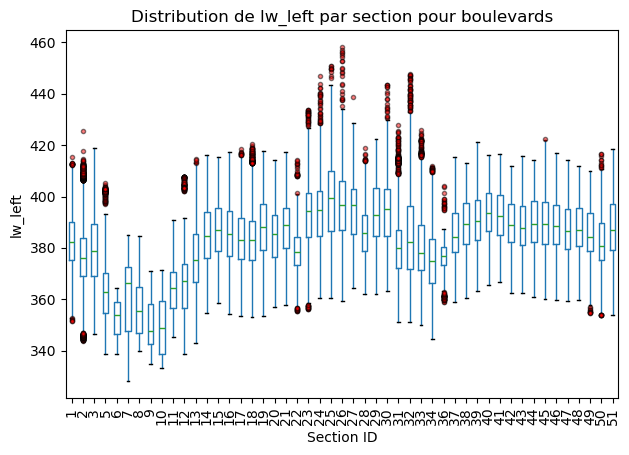

<Figure size 1000x600 with 0 Axes>

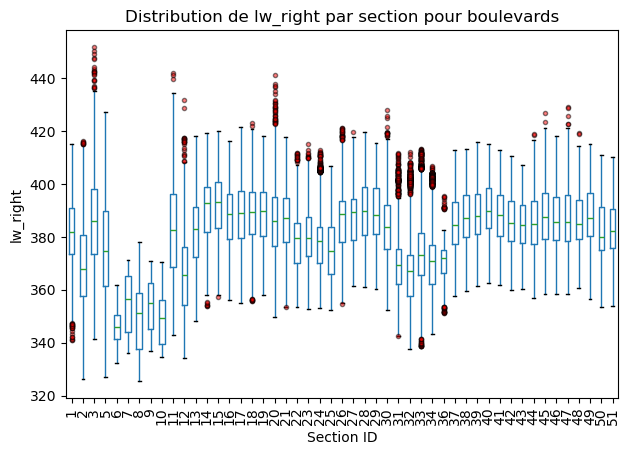

<Figure size 1000x600 with 0 Axes>

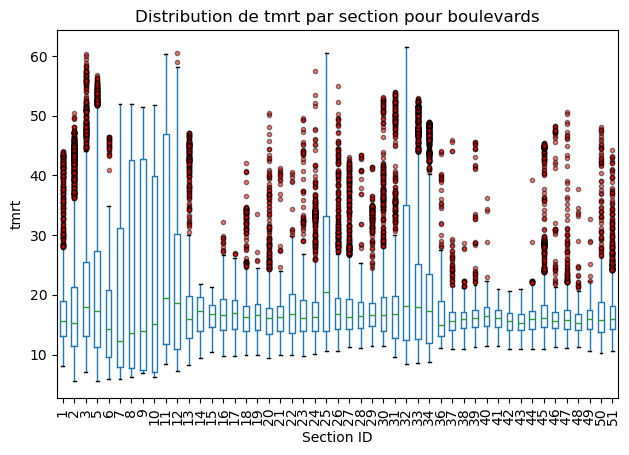

<Figure size 1000x600 with 0 Axes>

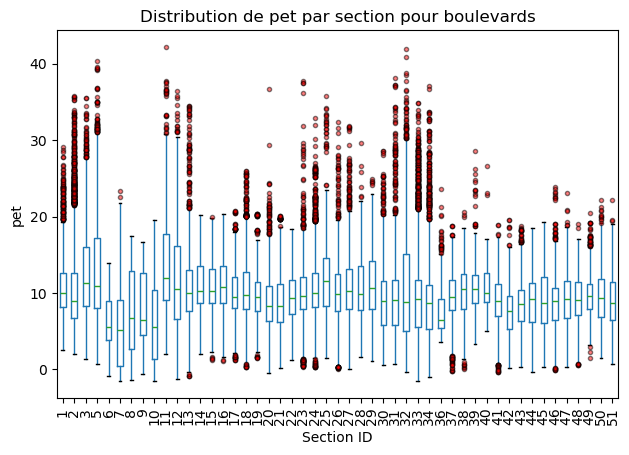

Genere des boxplots pour les parcours: ecusson


<Figure size 1000x600 with 0 Axes>

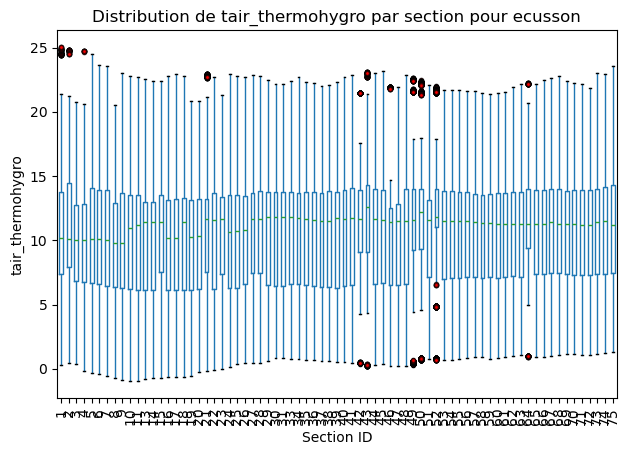

<Figure size 1000x600 with 0 Axes>

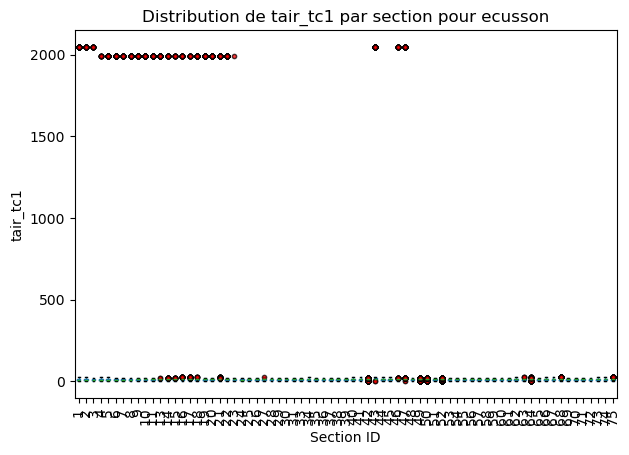

<Figure size 1000x600 with 0 Axes>

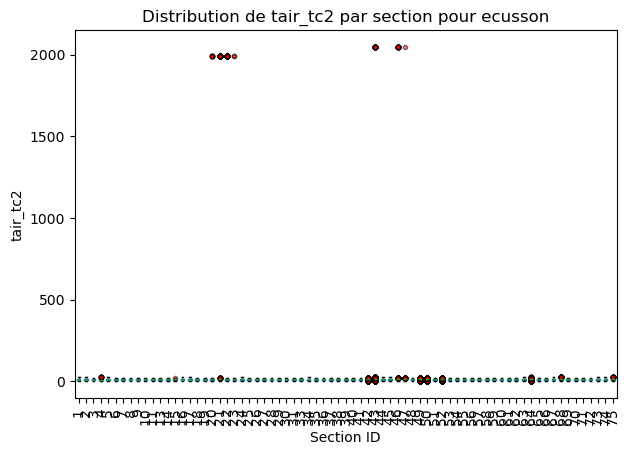

<Figure size 1000x600 with 0 Axes>

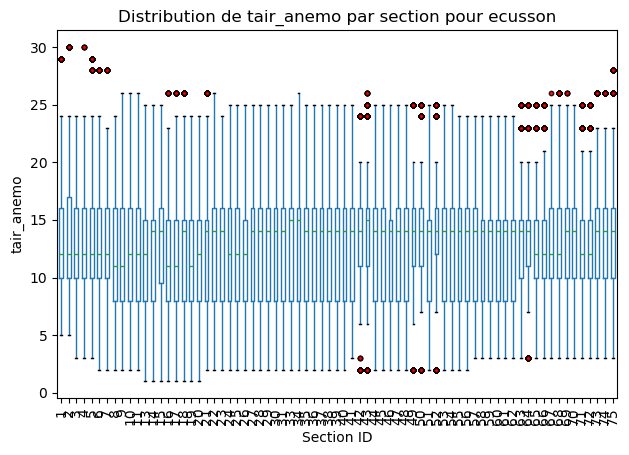

<Figure size 1000x600 with 0 Axes>

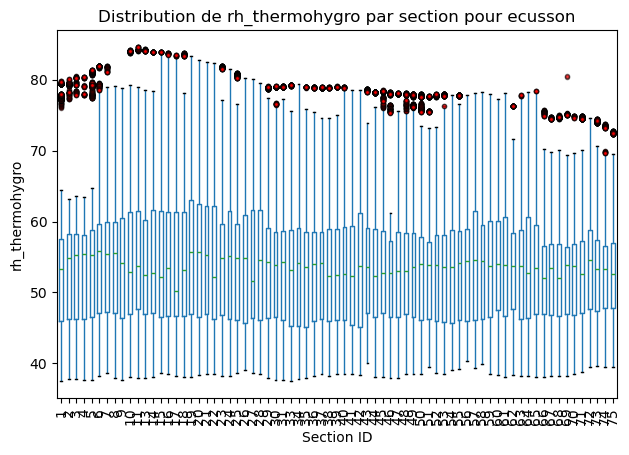

<Figure size 1000x600 with 0 Axes>

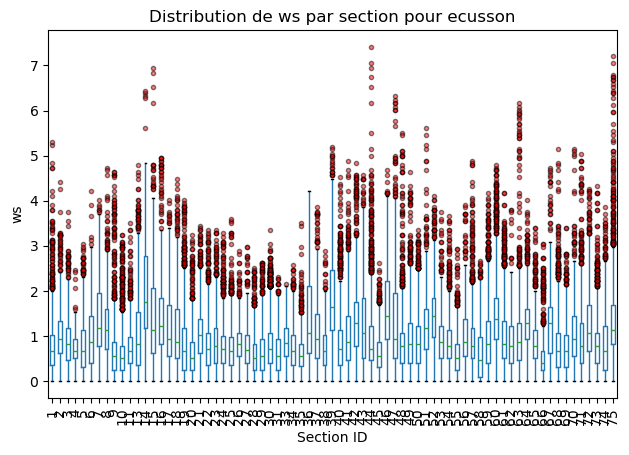

<Figure size 1000x600 with 0 Axes>

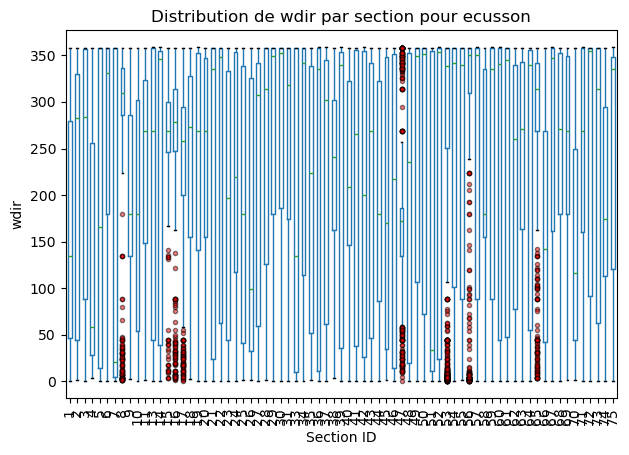

<Figure size 1000x600 with 0 Axes>

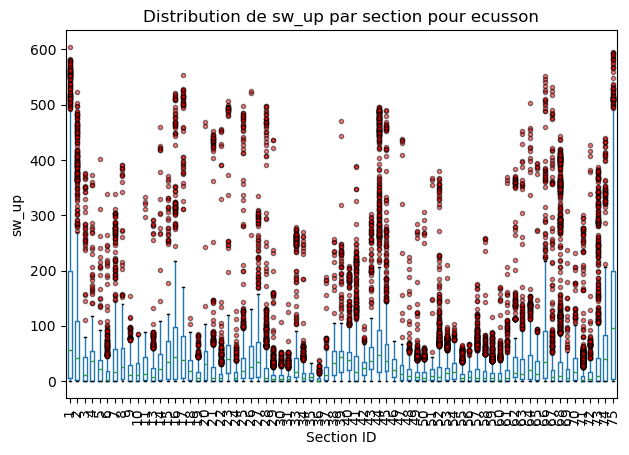

<Figure size 1000x600 with 0 Axes>

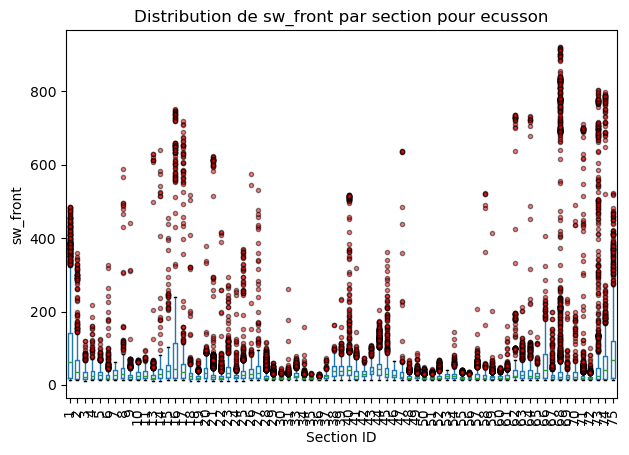

<Figure size 1000x600 with 0 Axes>

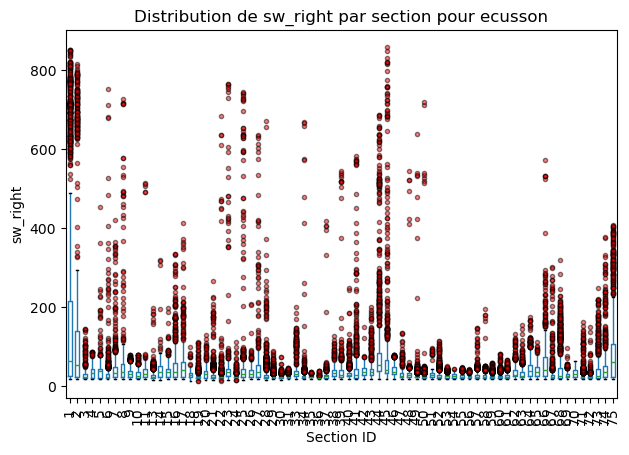

<Figure size 1000x600 with 0 Axes>

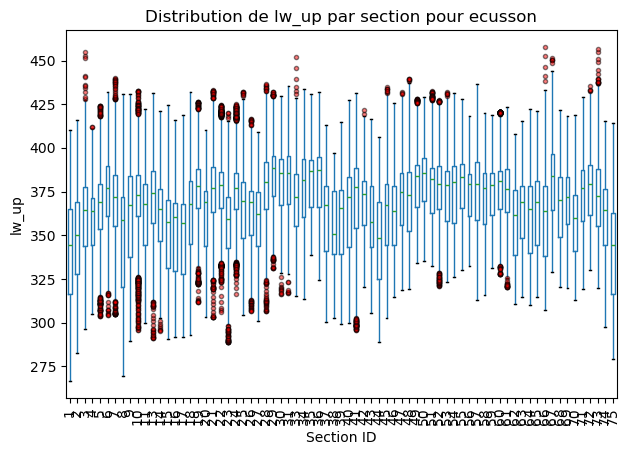

<Figure size 1000x600 with 0 Axes>

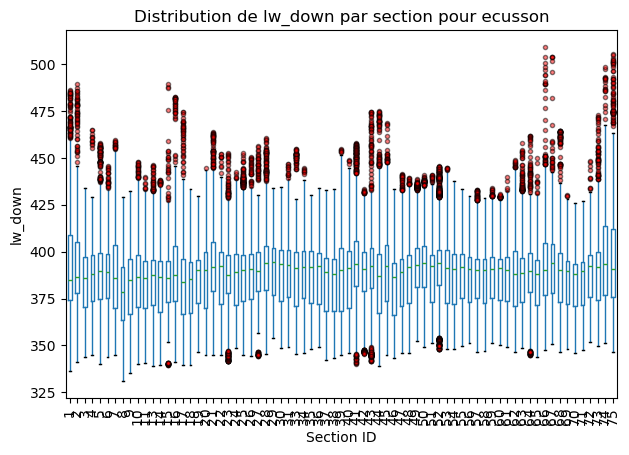

<Figure size 1000x600 with 0 Axes>

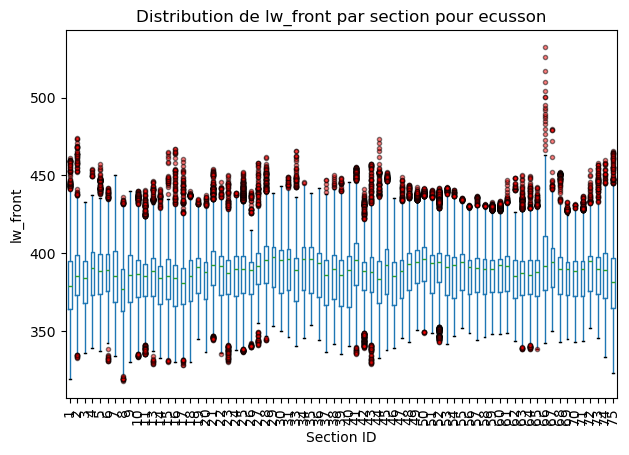

<Figure size 1000x600 with 0 Axes>

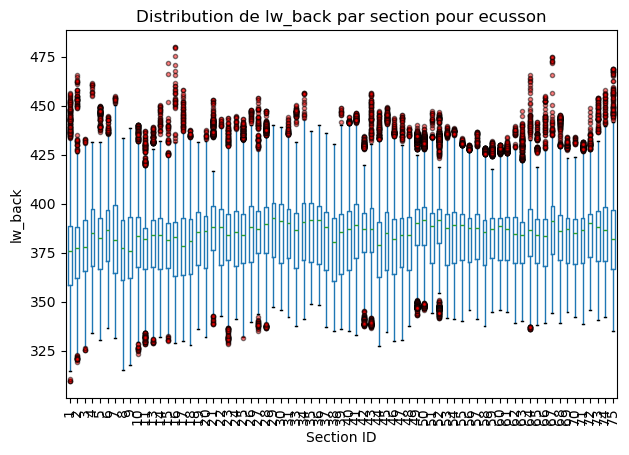

<Figure size 1000x600 with 0 Axes>

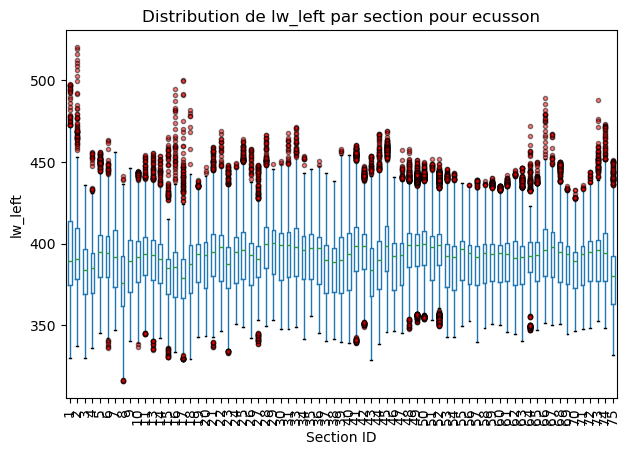

<Figure size 1000x600 with 0 Axes>

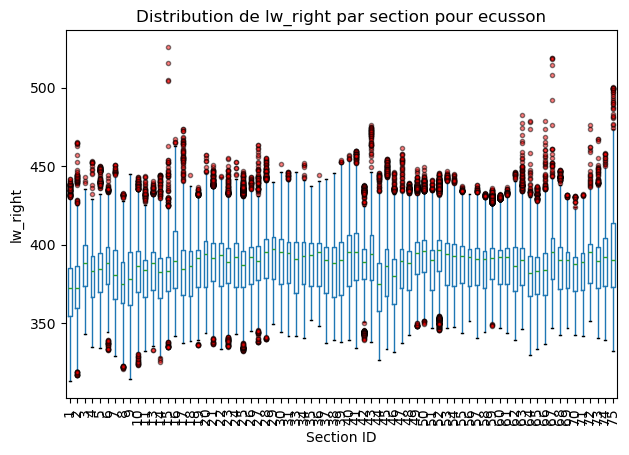

<Figure size 1000x600 with 0 Axes>

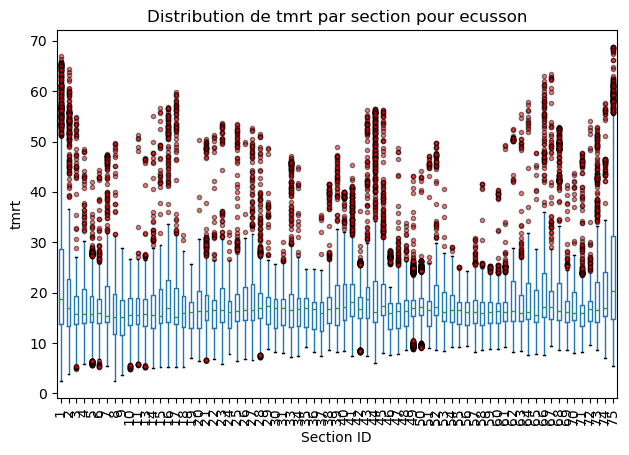

<Figure size 1000x600 with 0 Axes>

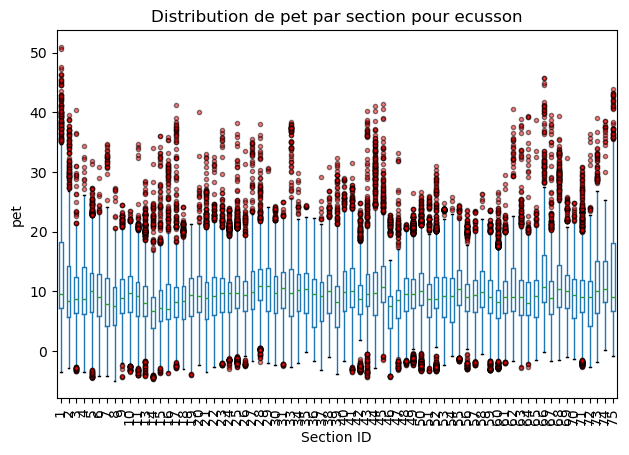

In [41]:
BOXPLOT_BY_SECTION = FIG_DIR / "boxplot_by_section"
fc.create_folder(BOXPLOT_BY_SECTION)

ANT = BOXPLOT_BY_SECTION / "antigone"
BOU = BOXPLOT_BY_SECTION / "boulevards"
ECU = BOXPLOT_BY_SECTION / "ecusson"

fc.create_folder(ANT)
fc.create_folder(BOU)
fc.create_folder(ECU)

flierprops = dict(marker='o', markerfacecolor='red', markersize=3, linestyle='none', alpha=0.5)

for track_id, track_data in raw.groupby("track_id"):
    track_dir = BOXPLOT_BY_SECTION / track_id

    print(f"Genere des boxplots pour les parcours: {track_id}")

    for v in METEO:
        plt.figure(figsize=(10, 6))
        track_data.boxplot(column=v, by="section_id", grid=False, flierprops=flierprops, rot=90)
        plt.title(f"Distribution de {v} par section pour {track_id}")
        plt.suptitle("") 
        plt.xlabel("Section ID")
        plt.ylabel(v)
        plt.tight_layout()
        plt.savefig(track_dir / f"box_{v}_by_section_{track_id}.png", dpi=150)
        plt.show()

##  Distribution des variables météo par parcours

Ce bloc affiche des **violinPlots**  pour comparer la distribution de chauques variables météorologiques clés entre les différents parcours (`track_id`).

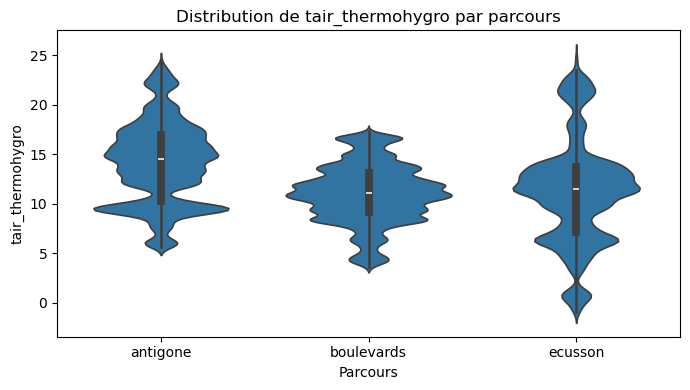

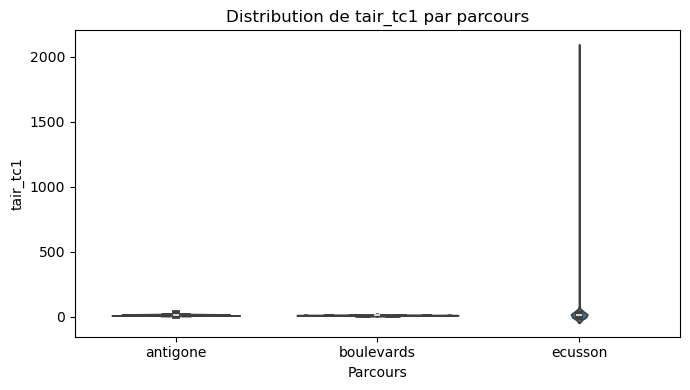

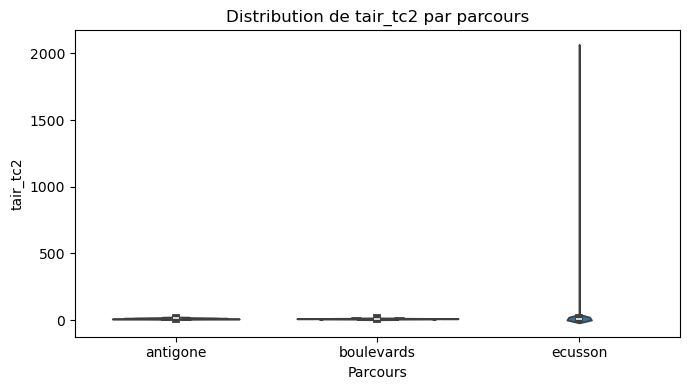

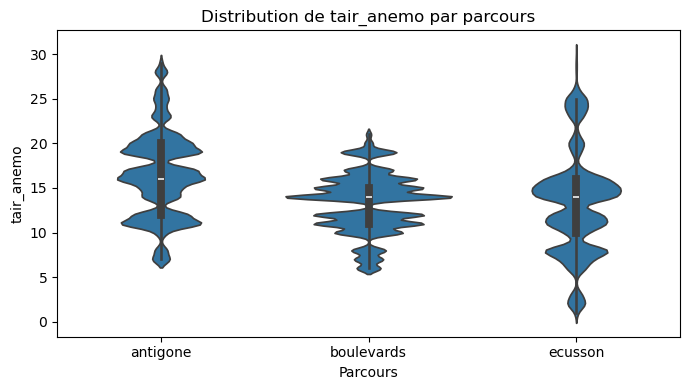

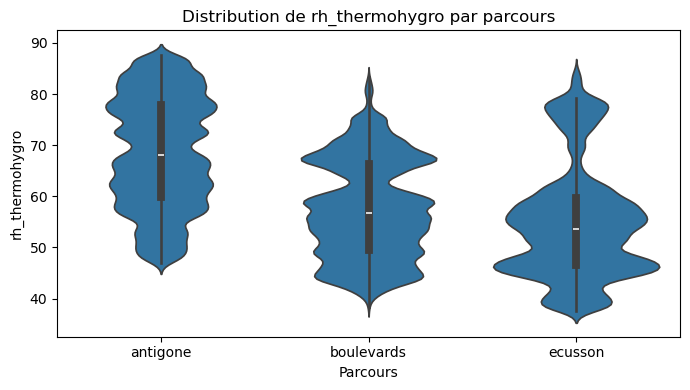

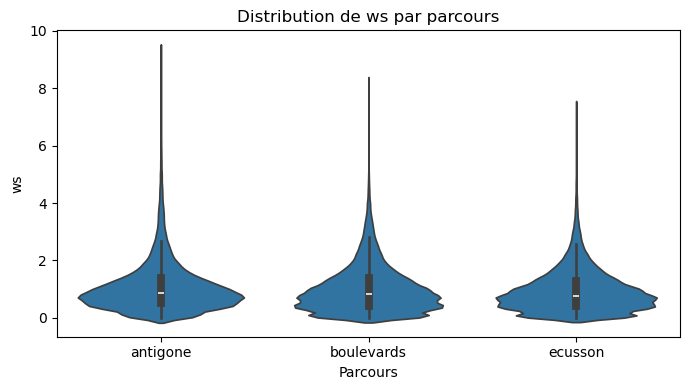

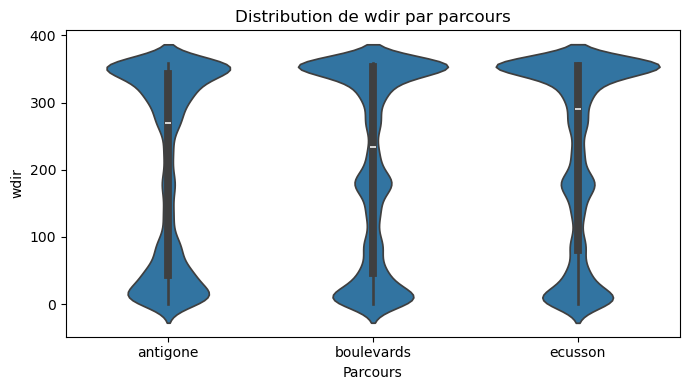

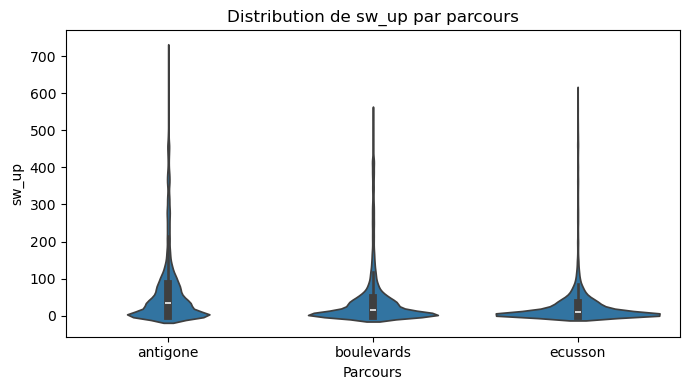

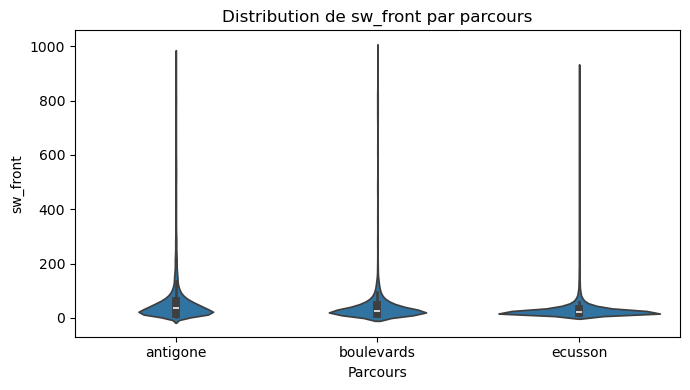

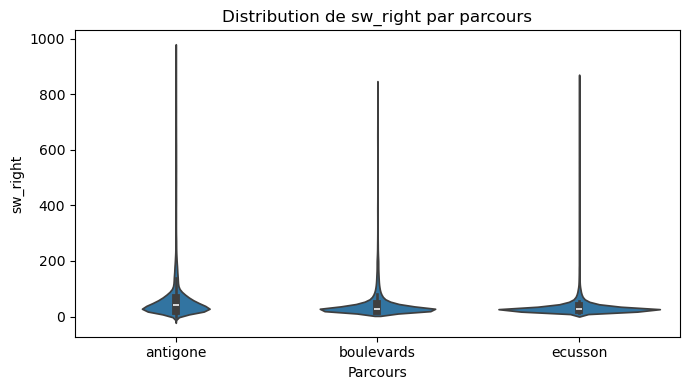

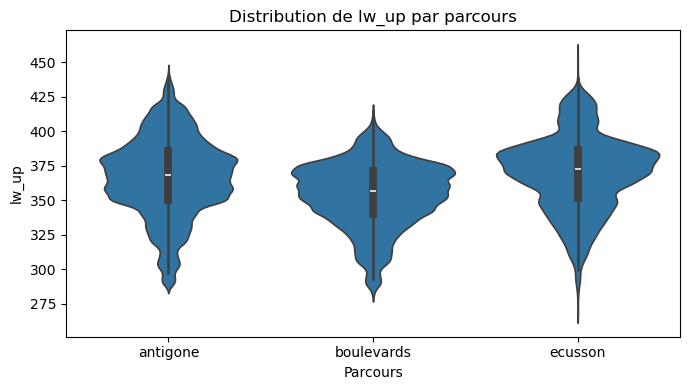

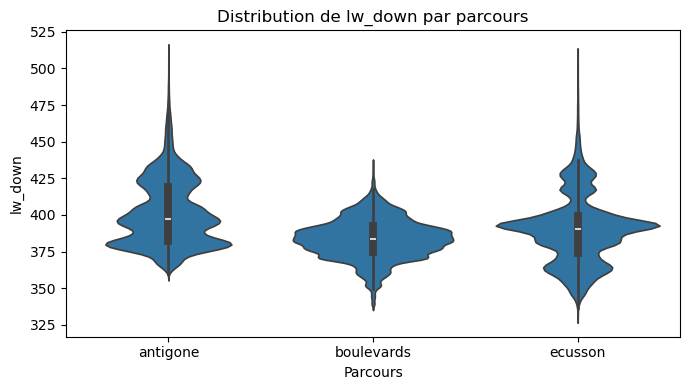

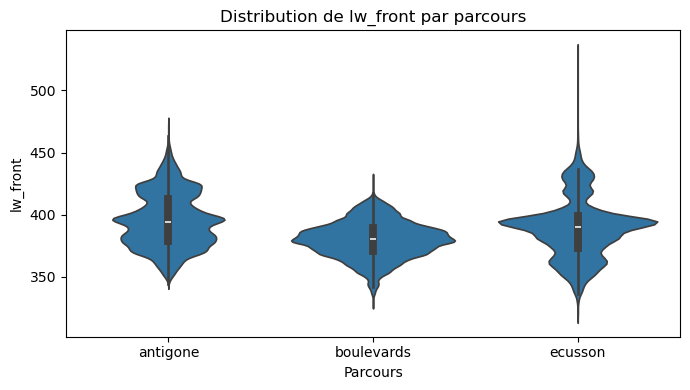

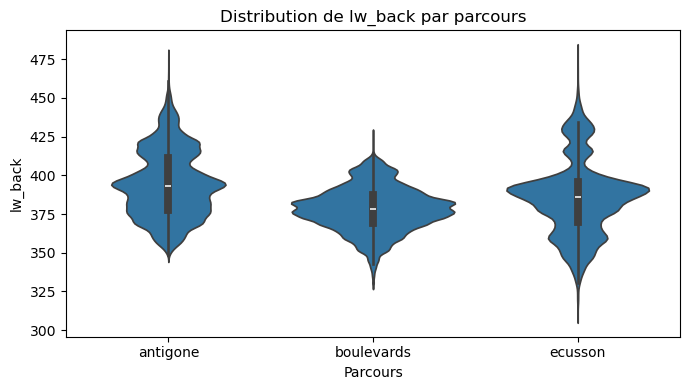

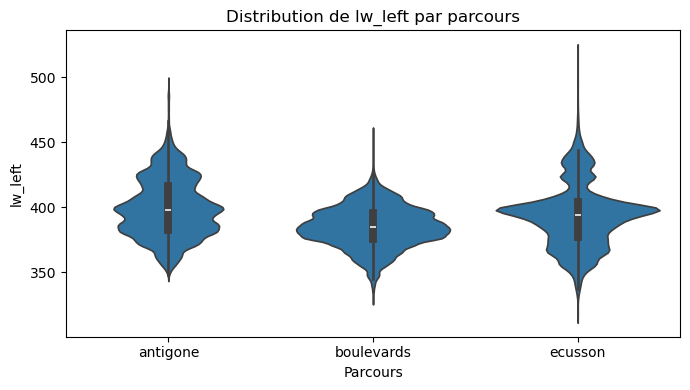

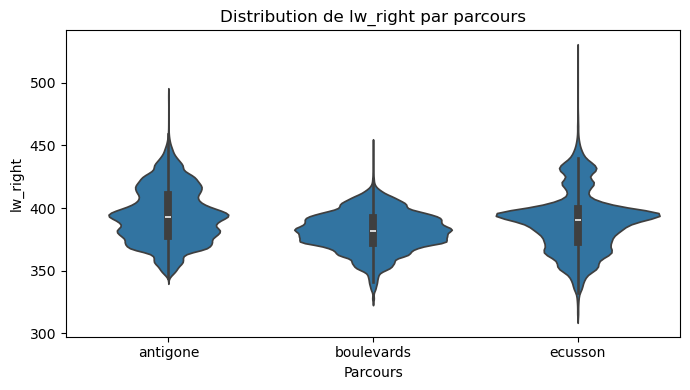

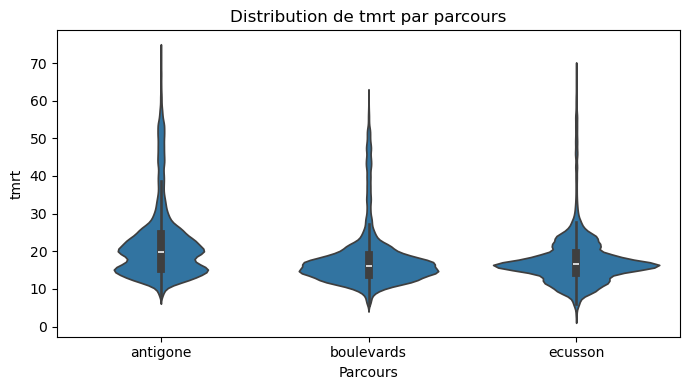

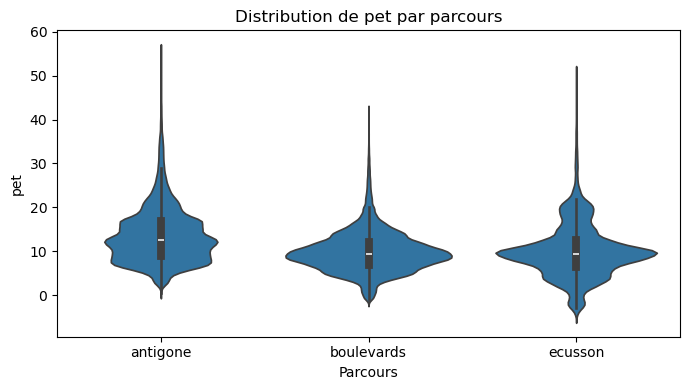

In [42]:
VIOLIN_DIR = FIG_DIR / "violinplot"
fc.create_folder(VIOLIN_DIR)

for v in METEO:
    plt.figure(figsize=(7, 4))
    sns.violinplot(x="track_id", y=v, data=raw)
    plt.title(f"Distribution de {v} par parcours")
    plt.xlabel("Parcours")
    plt.ylabel(v)
    plt.tight_layout()
    plt.savefig(VIOLIN_DIR / f"violin_{v}_parcours.png", dpi=150)
    plt.show()

# Comparaison des Boxplots et des violinPlots

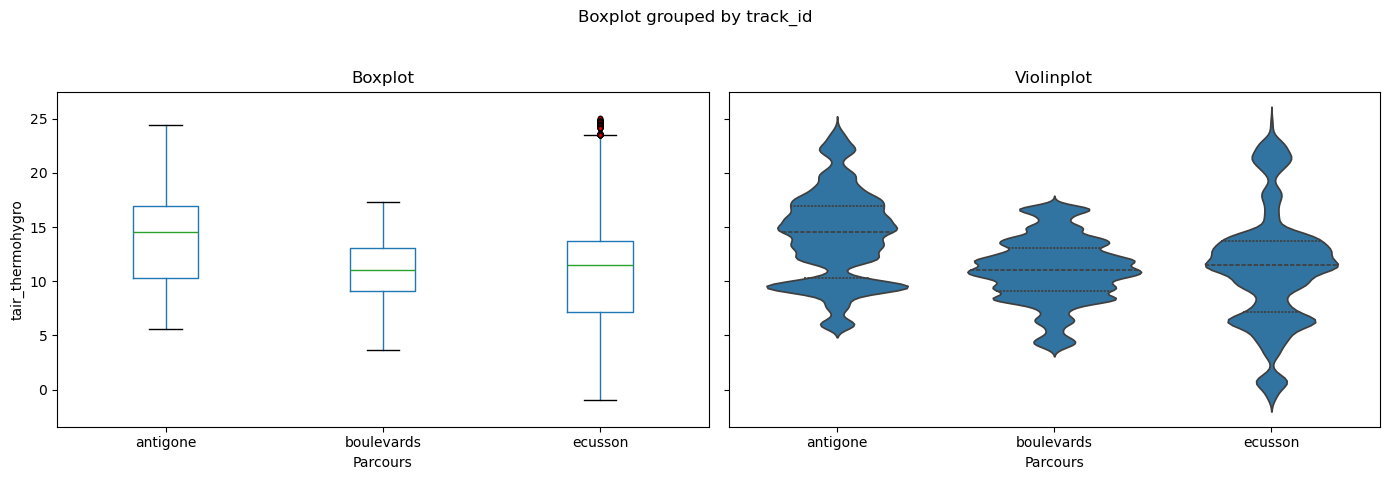

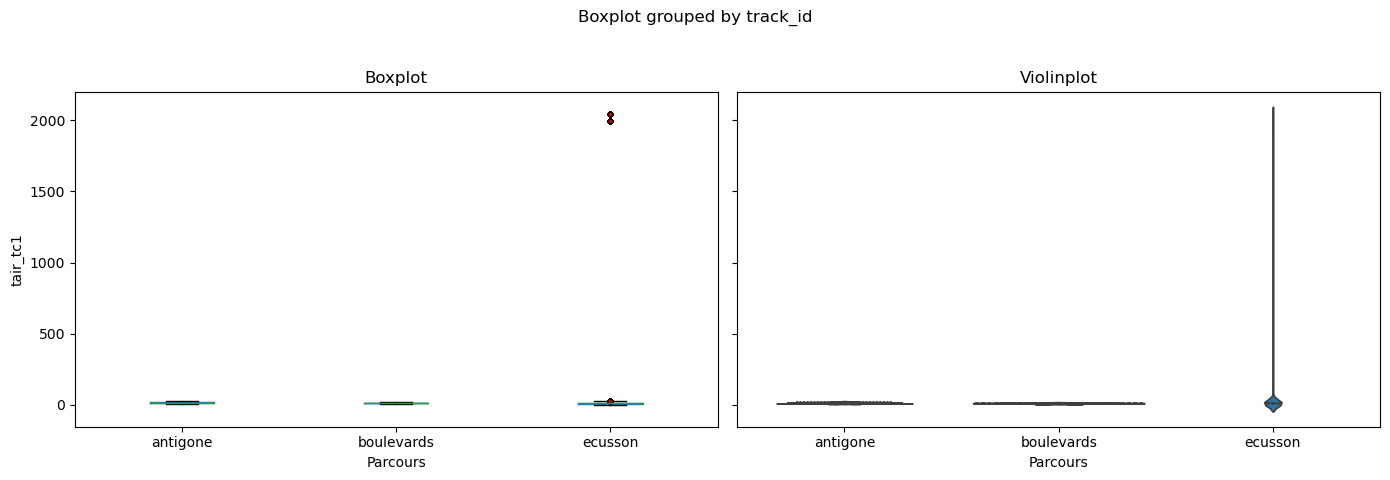

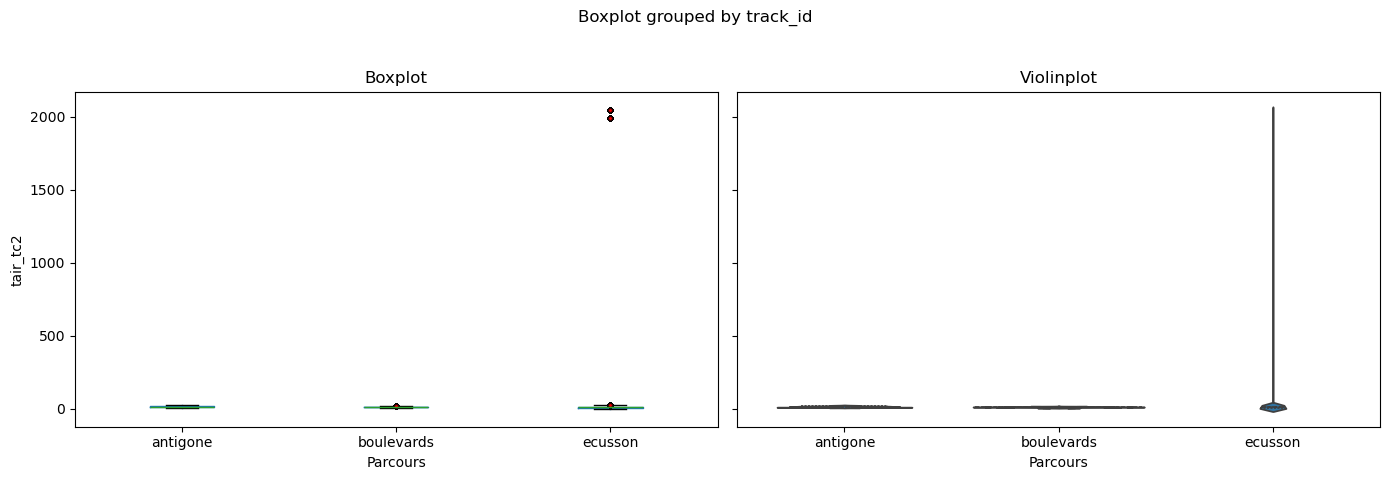

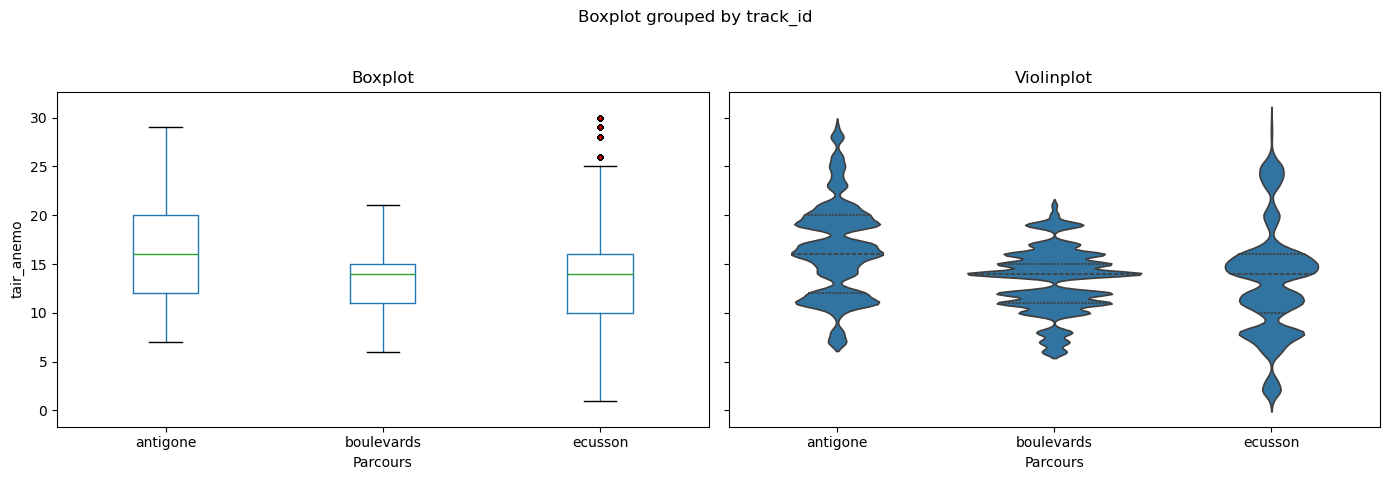

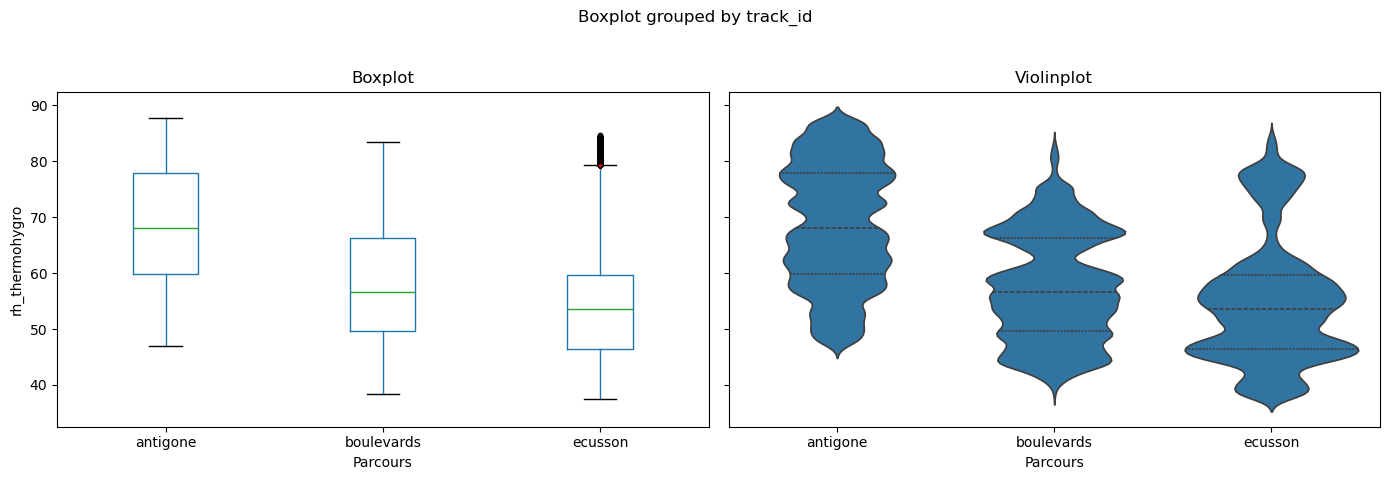

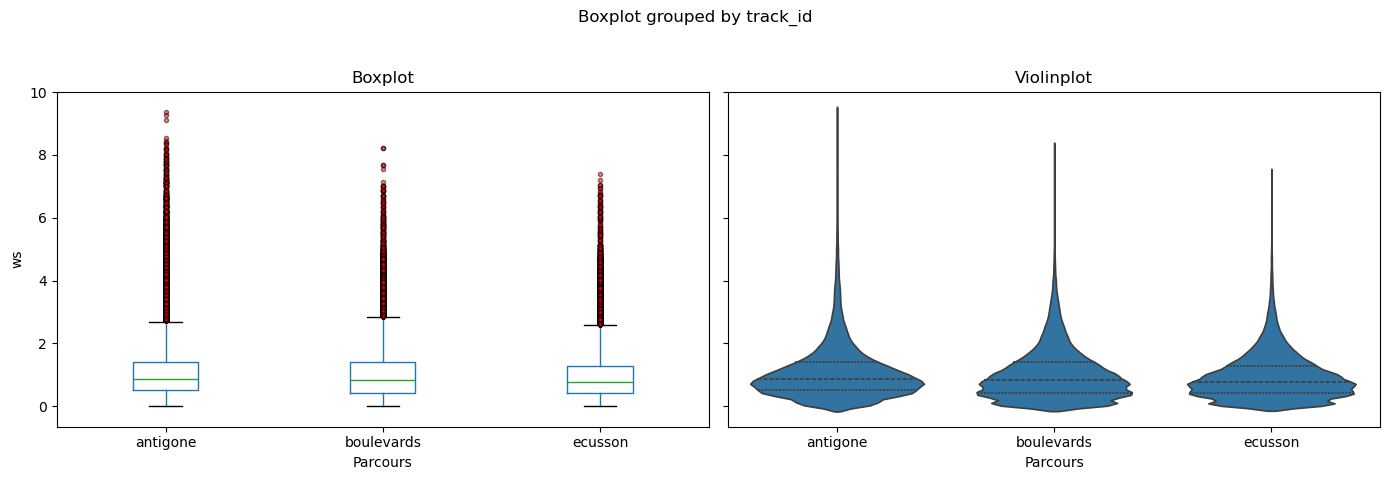

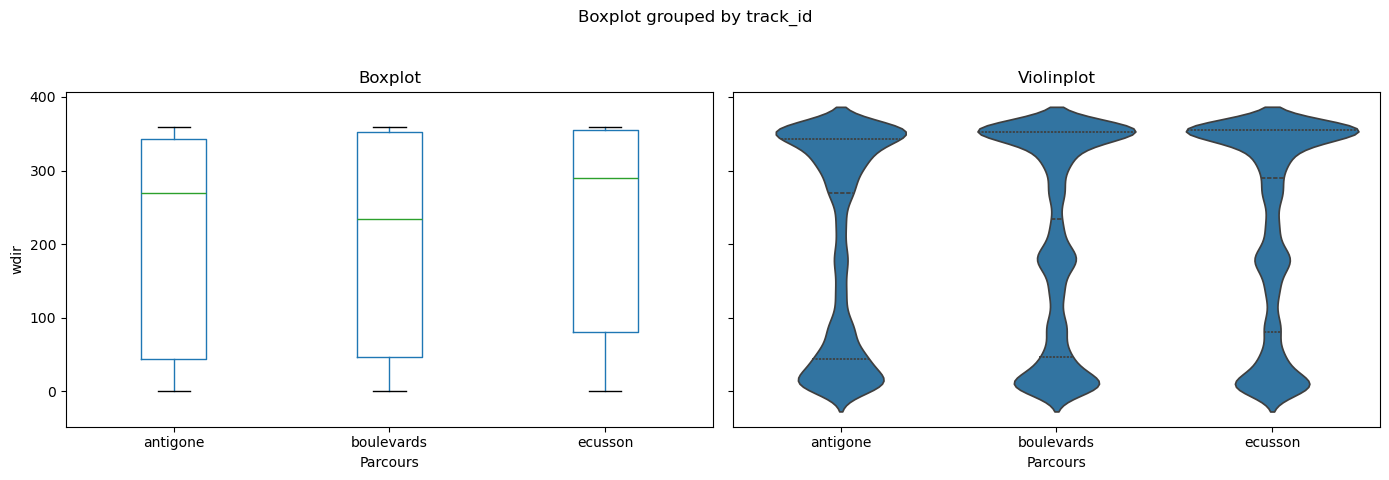

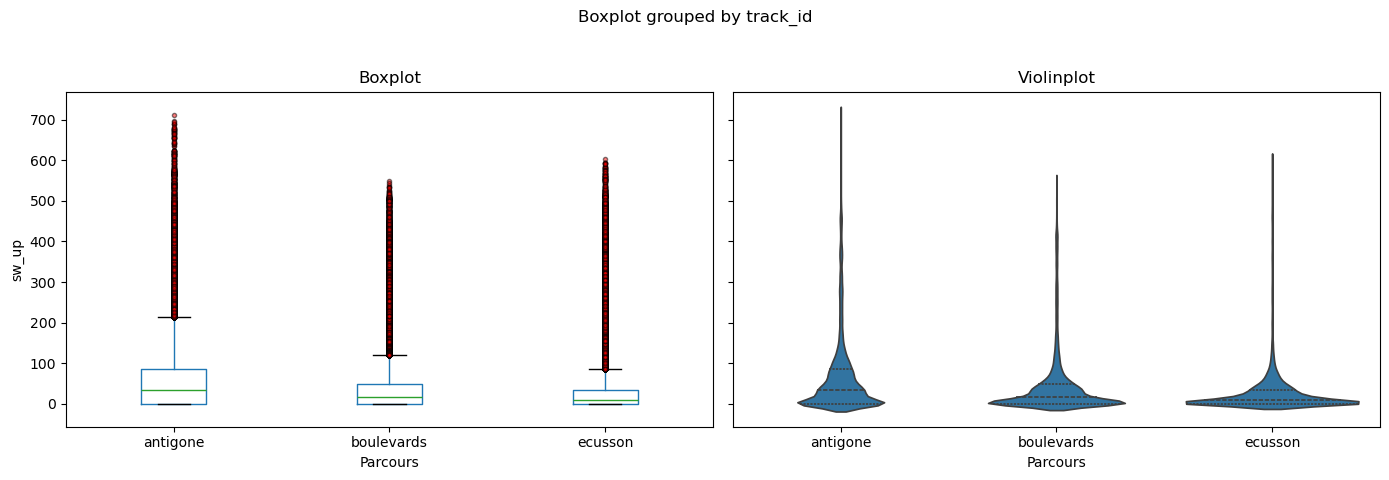

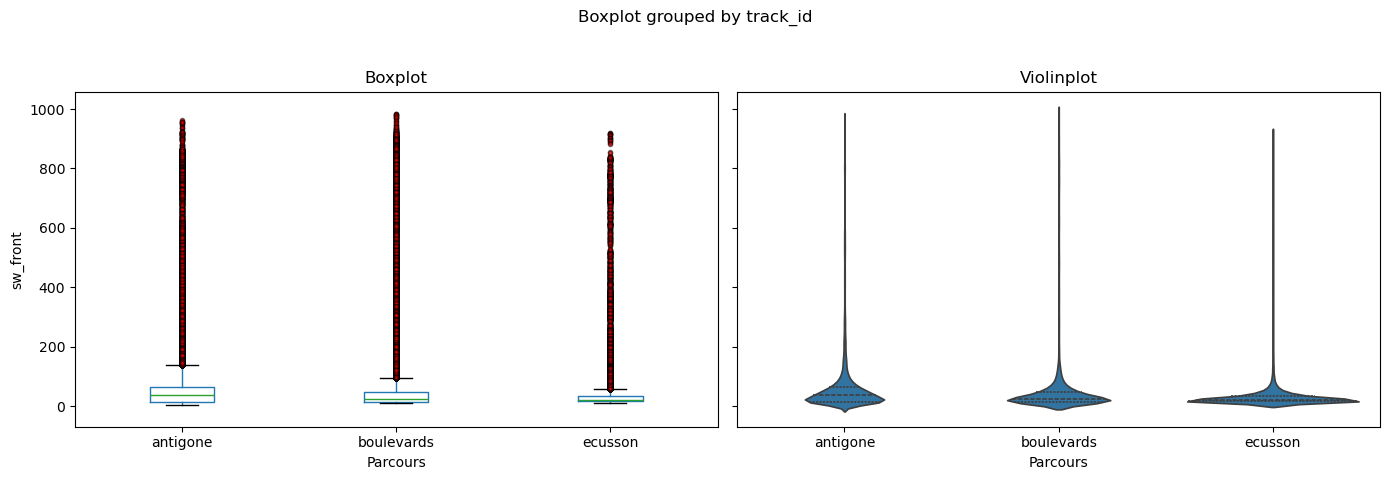

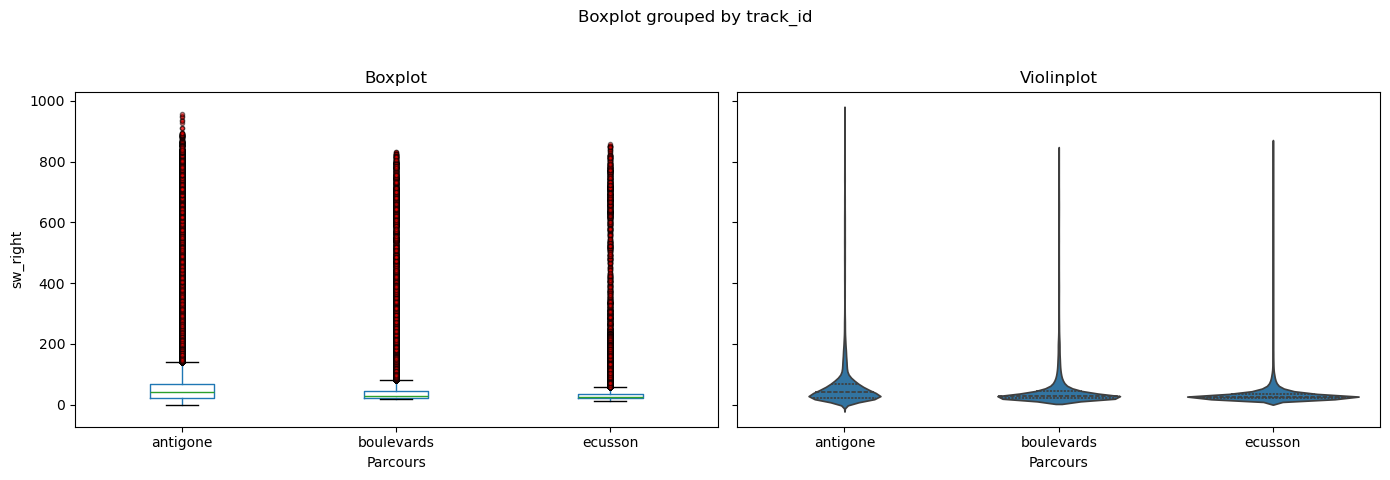

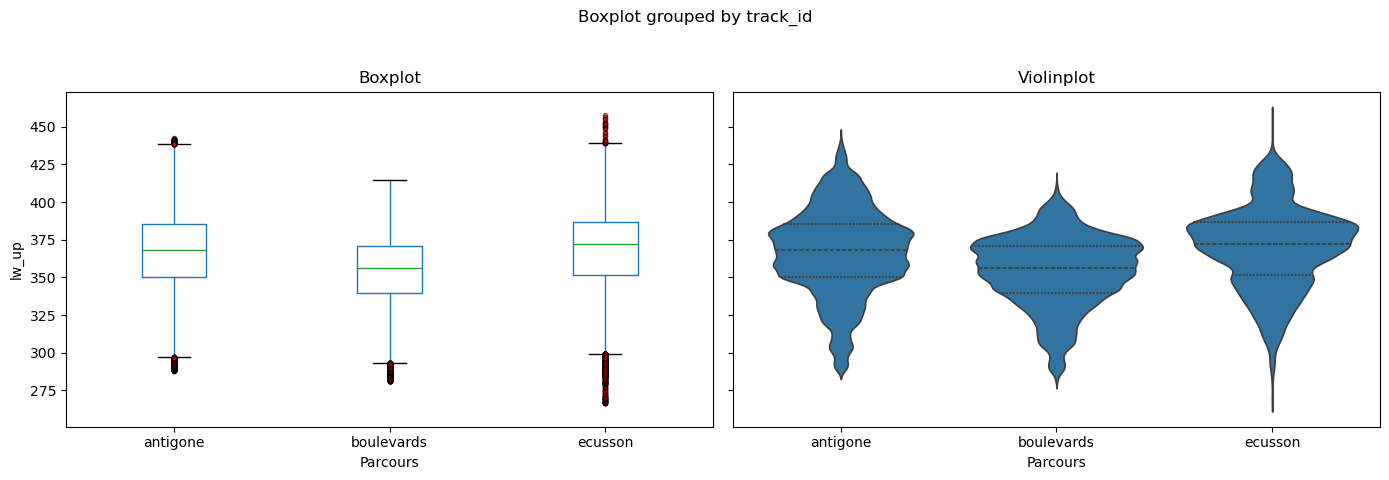

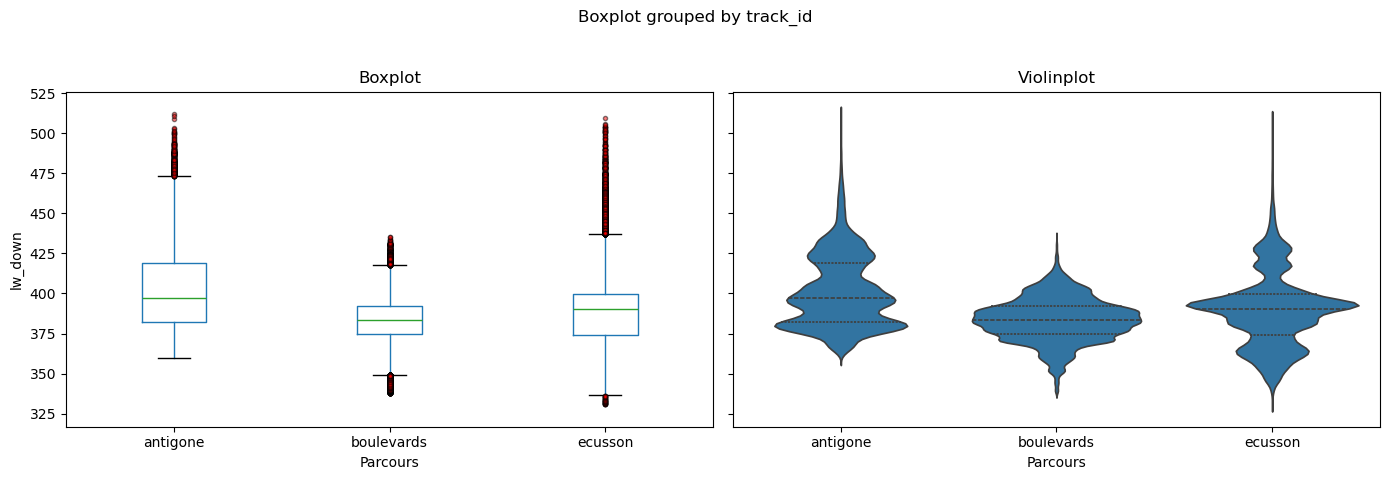

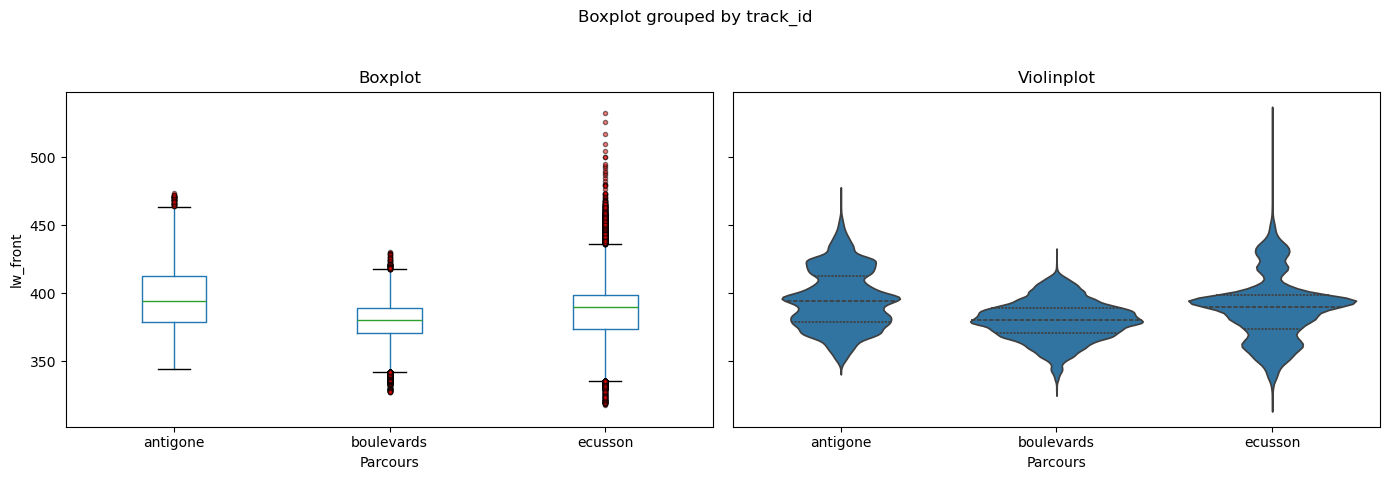

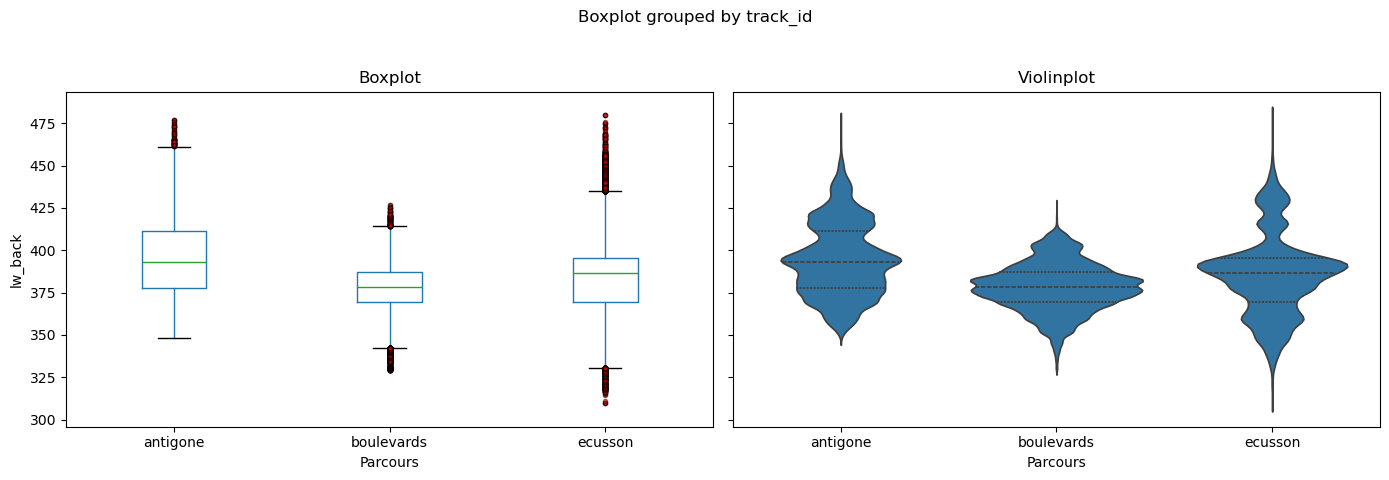

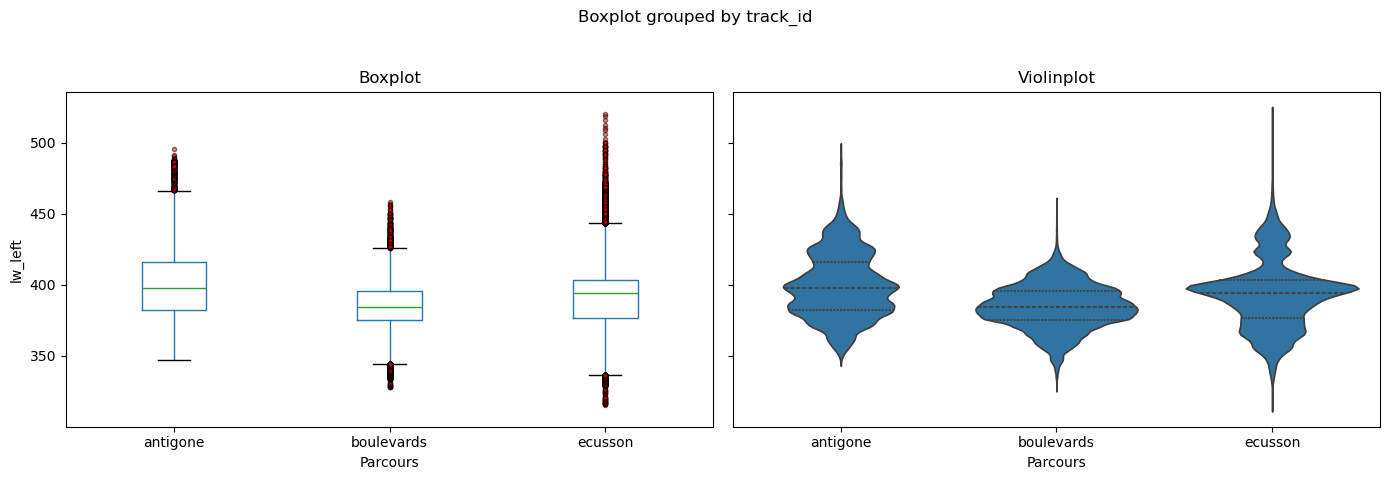

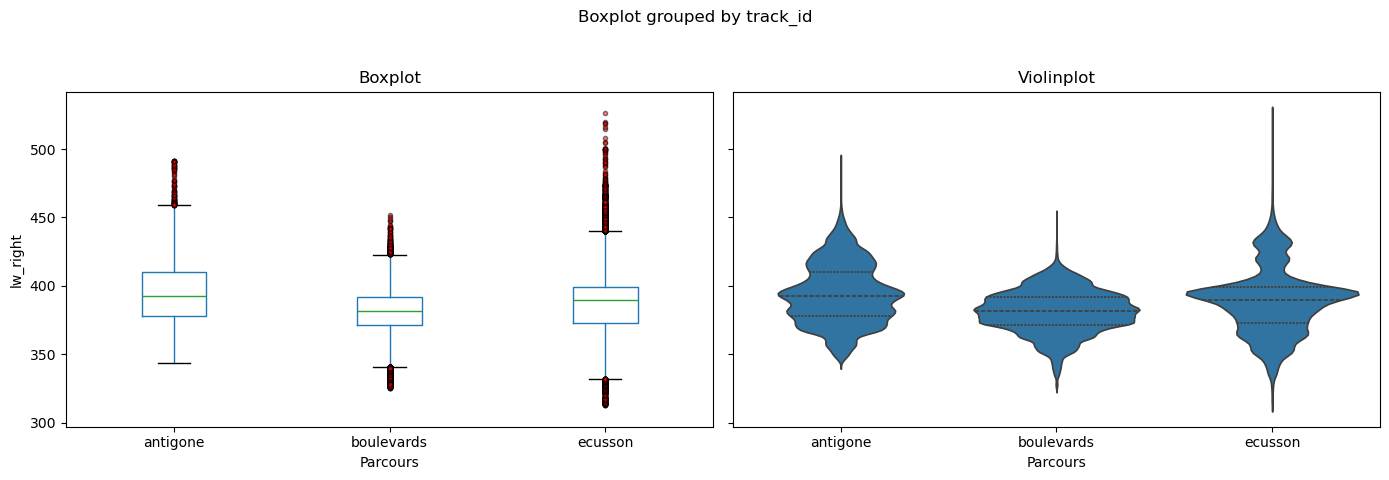

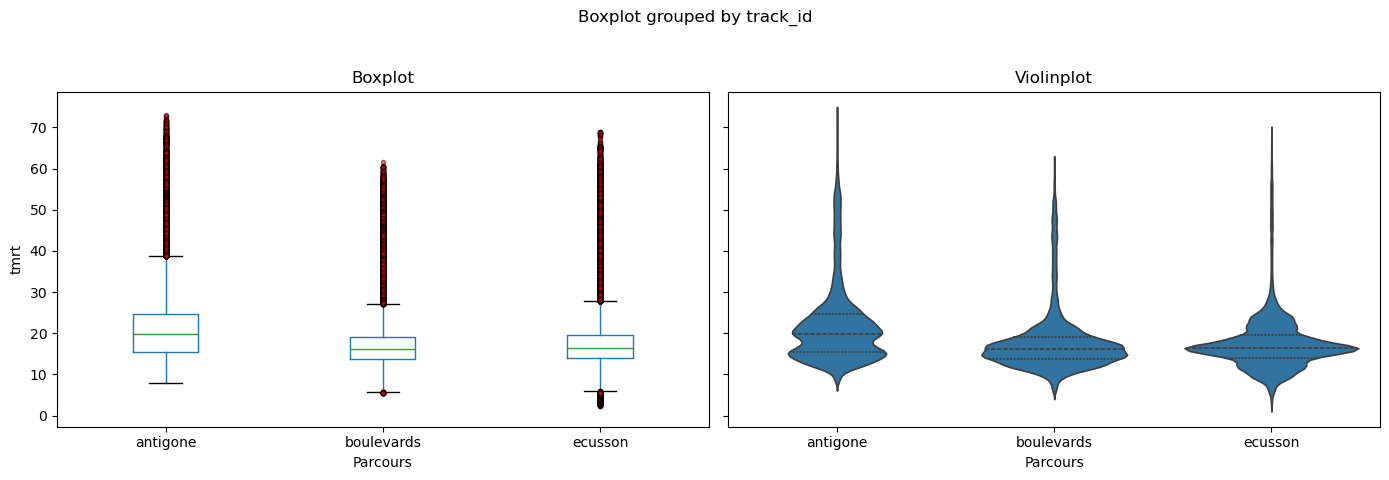

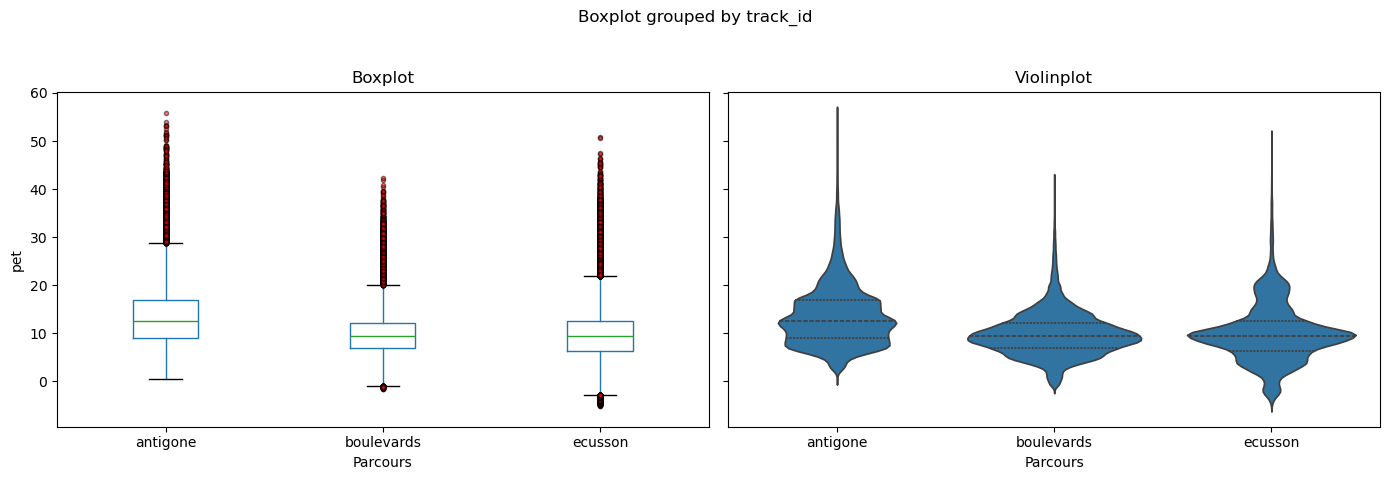

In [43]:
COMPARE_PLOTS_DIR = FIG_DIR / "compare_box_violin"
fc.create_folder(COMPARE_PLOTS_DIR)

flierprops = dict(marker='o', markerfacecolor='red', markersize=3, linestyle='none', alpha=0.5)

for v in METEO:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)
    fig.suptitle(f"Distribution de {v} par parcours: Boxplot vs Violinplot")

    # Boxplot
    raw.boxplot(column=v, by="track_id", grid=False, flierprops=flierprops, ax=axes[0])
    axes[0].set_title("Boxplot")
    axes[0].set_xlabel("Parcours")
    axes[0].set_ylabel(v)
    fig.canvas.manager.set_window_title('') 

    # Violinplot
    sns.violinplot(x="track_id", y=v, data=raw, ax=axes[1], inner='quartile') 
    axes[1].set_title("Violinplot")
    axes[1].set_xlabel("Parcours")
    axes[1].set_ylabel(v) 

    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) 
    plt.savefig(COMPARE_PLOTS_DIR / f"compare_{v}_parcours.png", dpi=150)
    plt.show()

# Distribution des variables météo

Ces blocs tracent un `histogramme` pour chaque variable météo sur différentes échelles (plus ou moins local), afin de visualiser la `répartition des valeurs mesurées` (et détecter d’éventuels biais ou valeurs extrêmes).

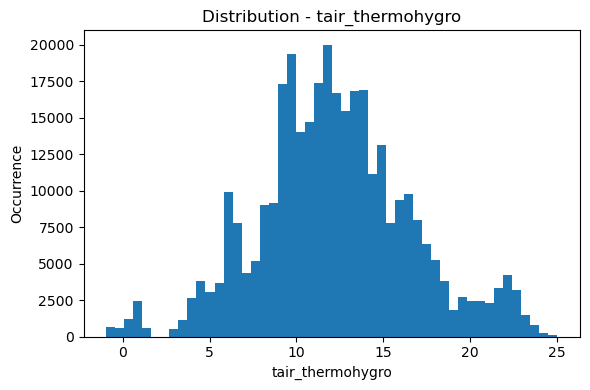

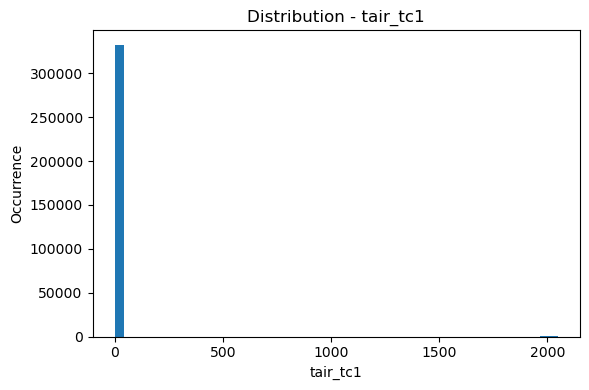

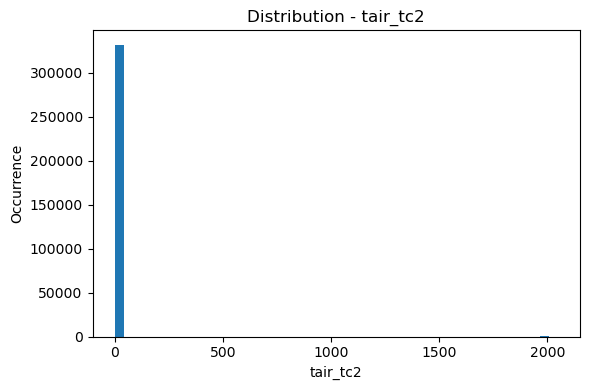

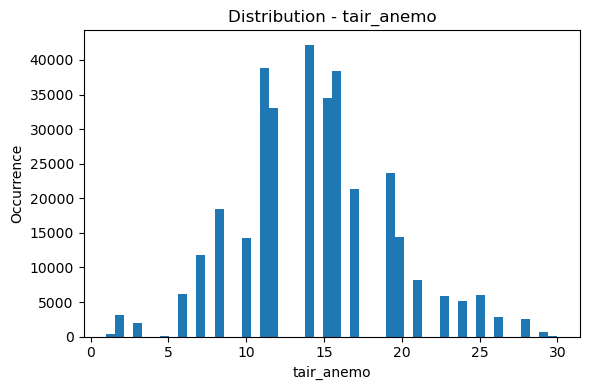

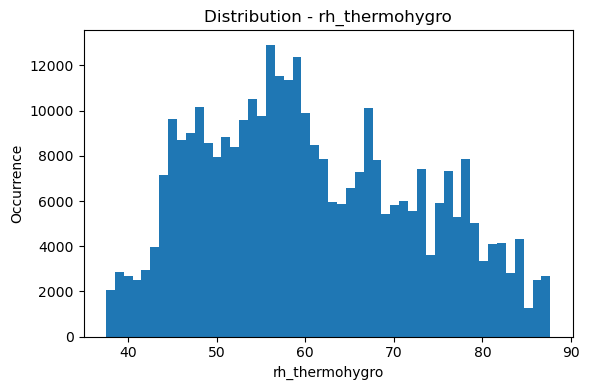

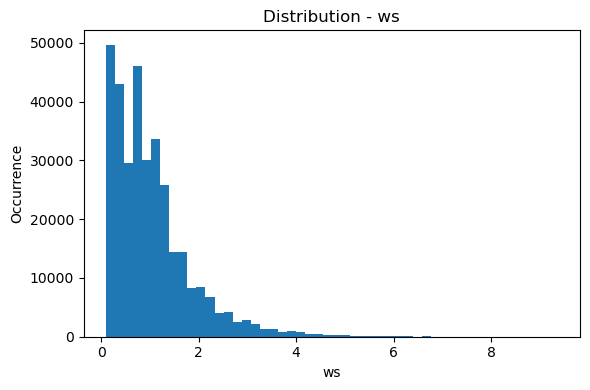

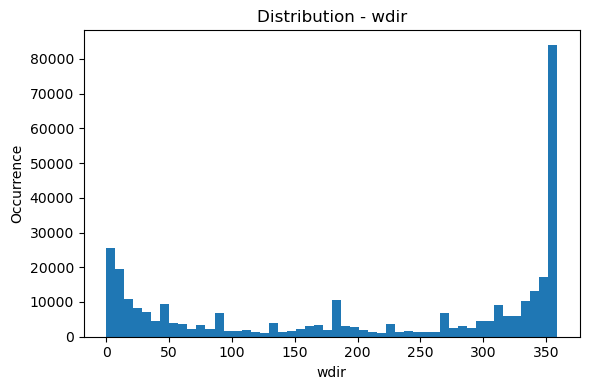

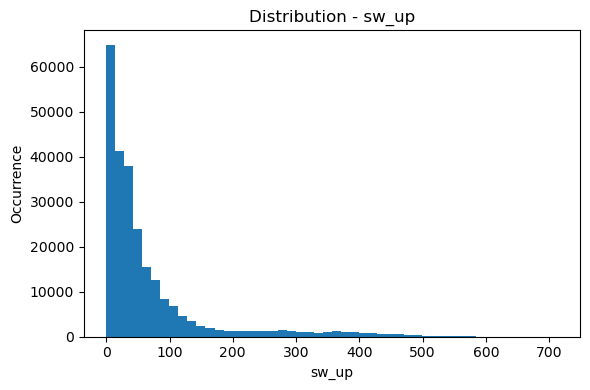

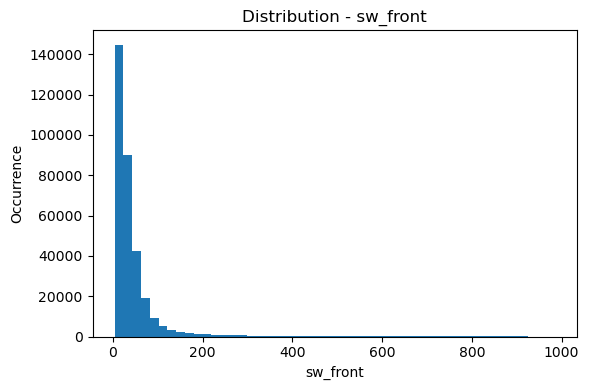

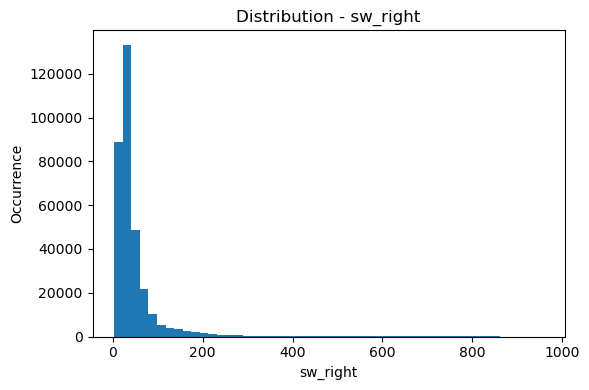

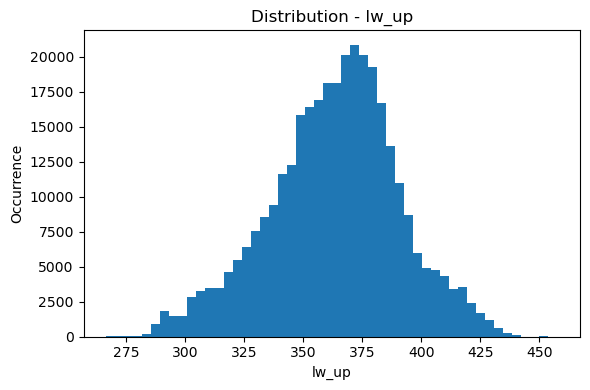

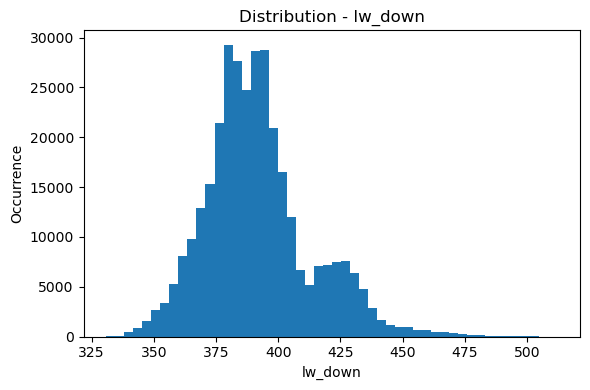

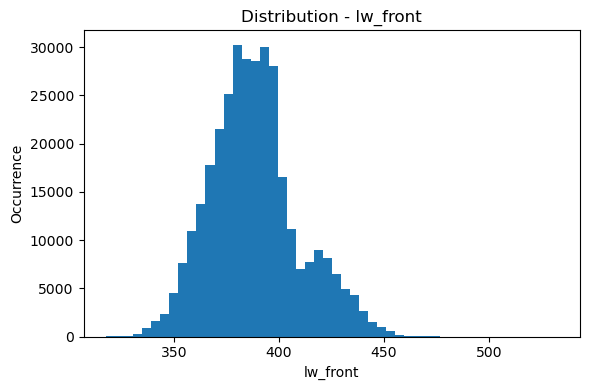

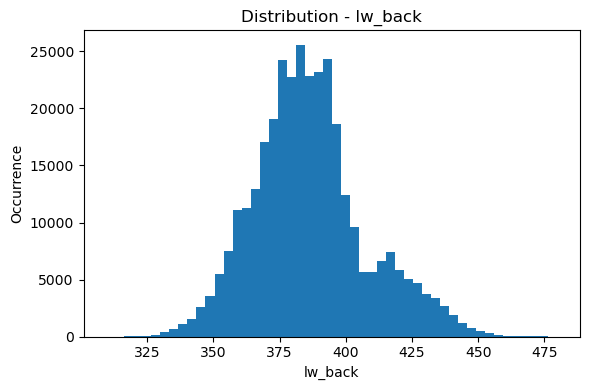

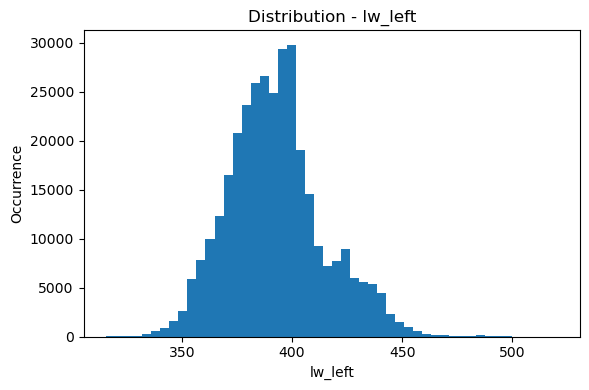

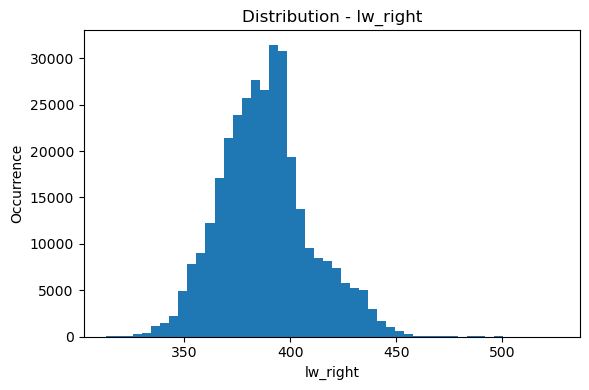

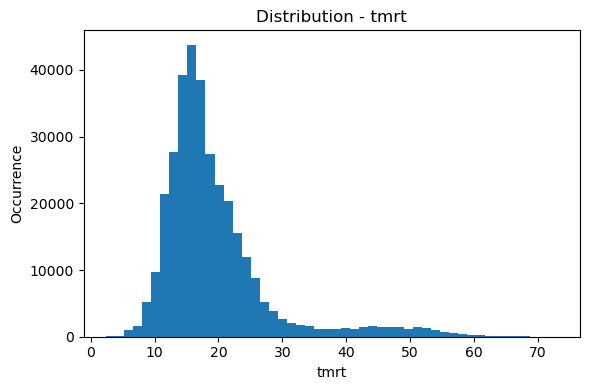

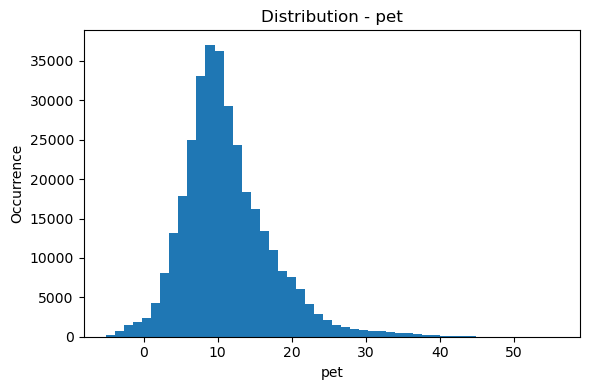

In [44]:
# Distribution globale de chaque variable
DISTRIB = FIG_DIR / "distribution"
fc.create_folder(DISTRIB)

DISTRIB_G = DISTRIB / "distribution_globale"
fc.create_folder(DISTRIB_G)
for v in METEO:
    s = bd[v].dropna()
    if len(s) == 0:
        continue

    plt.figure(figsize=(6, 4))
    plt.hist(s, bins=50)
    plt.title(f"Distribution - {v}")
    plt.xlabel(v)
    plt.ylabel("Occurrence")
    plt.tight_layout()
    plt.savefig(DISTRIB_G / f"dist_global_{v}.png", dpi=150)

/var/folders/xz/8qmtfxds1qdftctg_8qnbryr0000gn/T/ipykernel_7642/3121222869.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(6, 4))


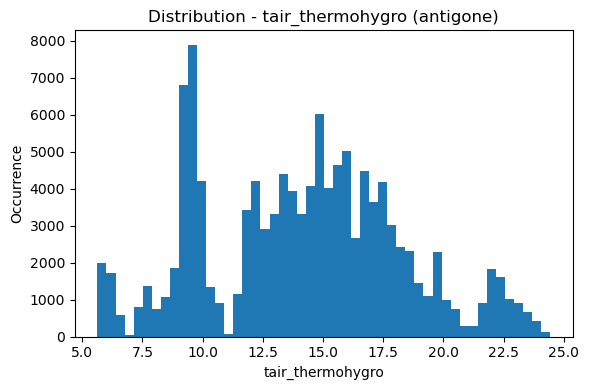

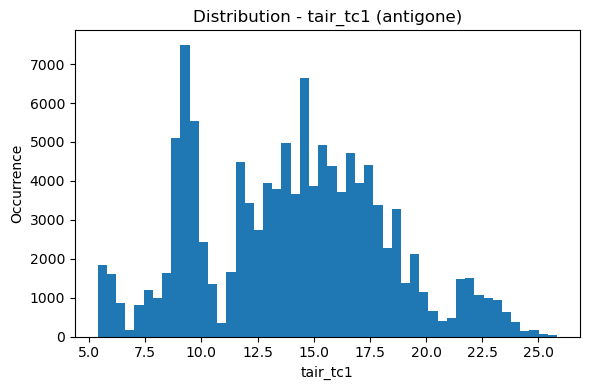

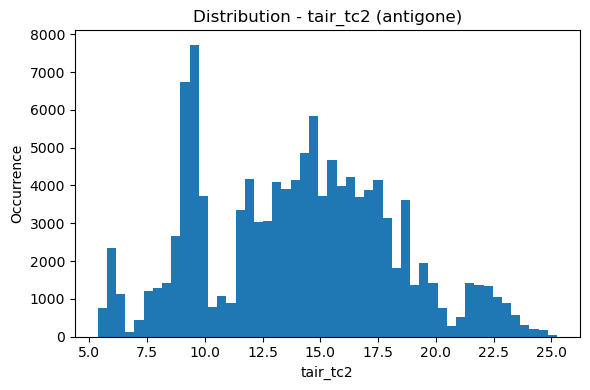

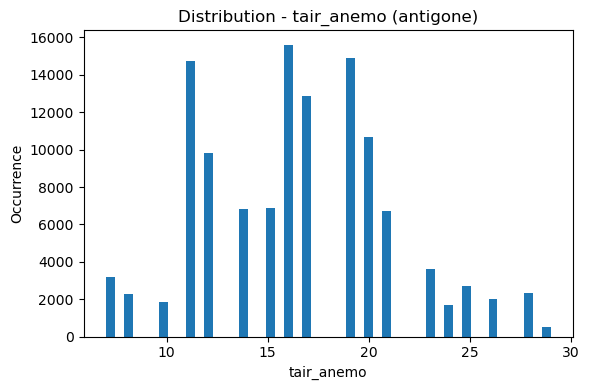

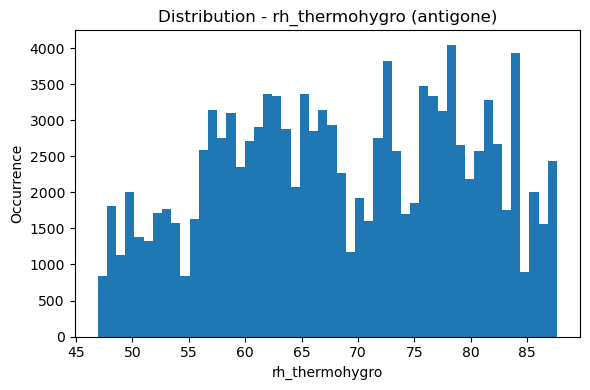

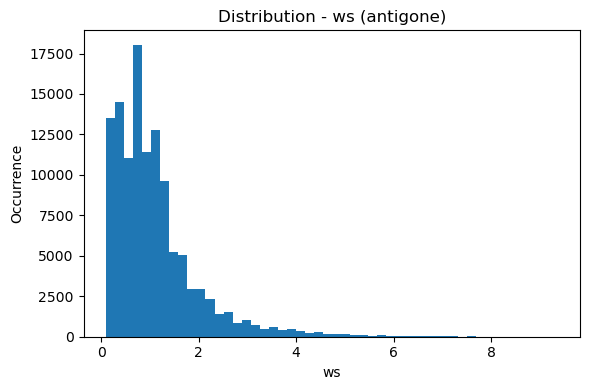

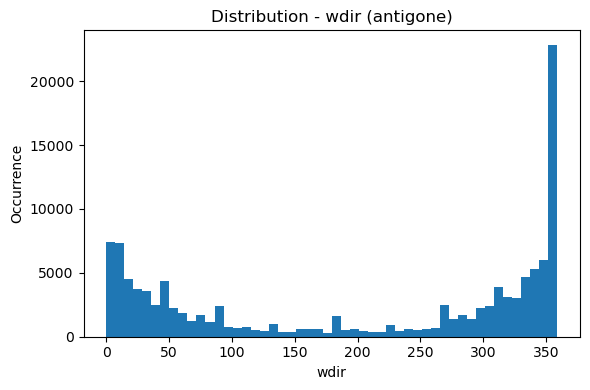

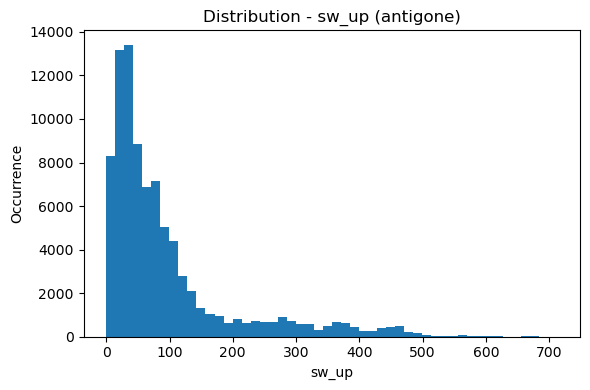

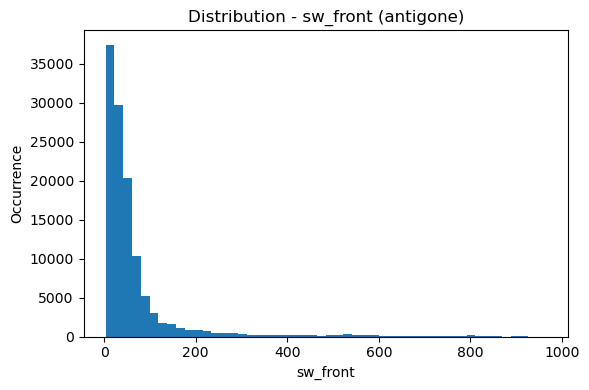

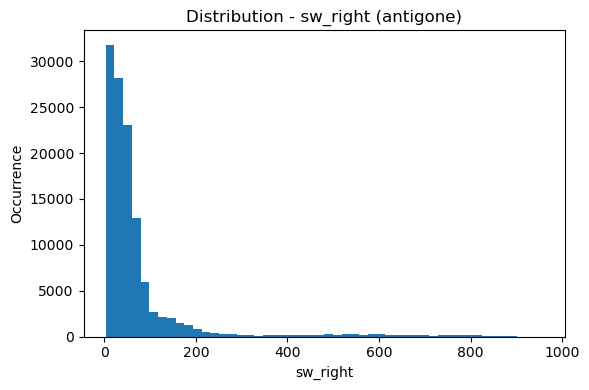

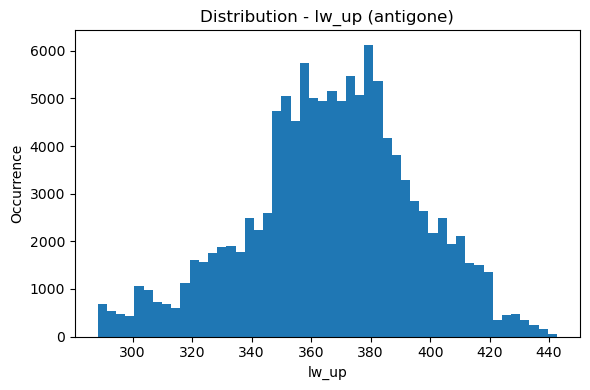

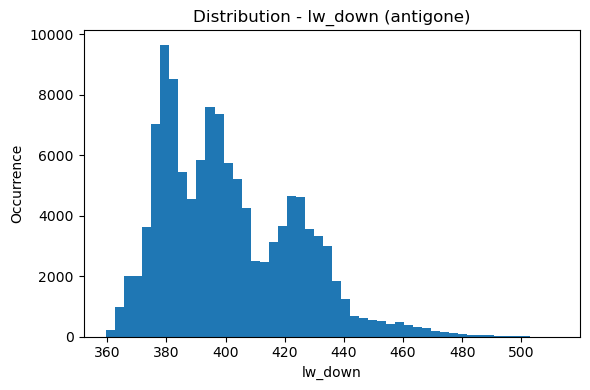

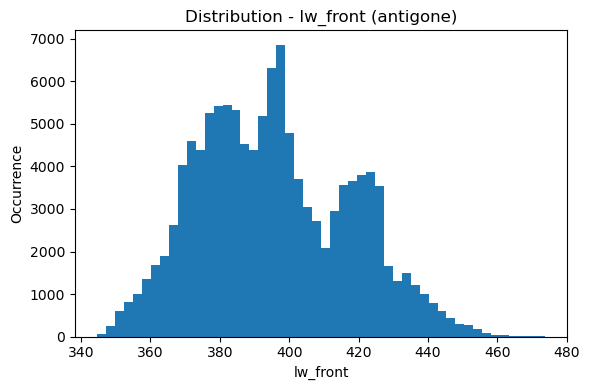

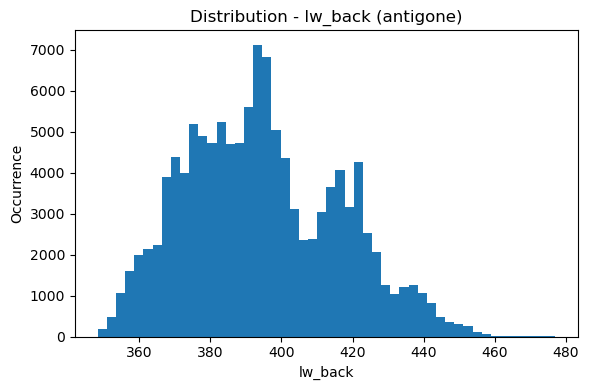

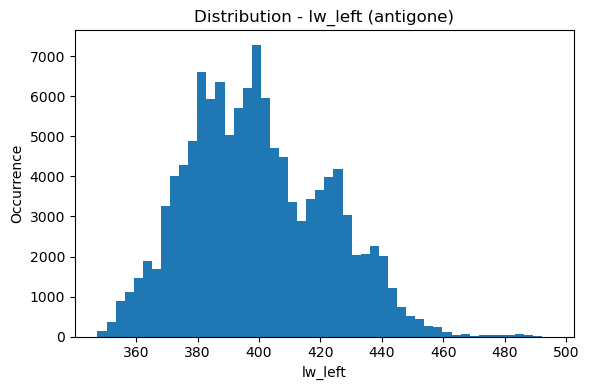

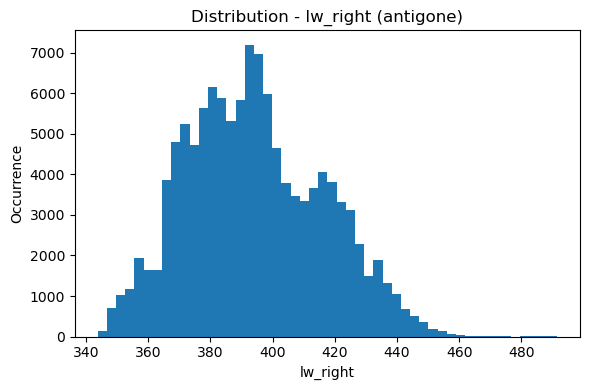

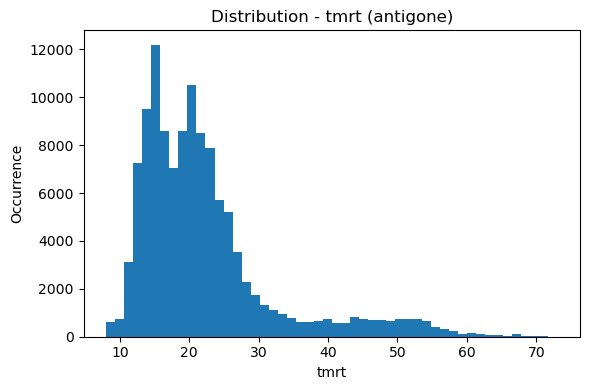

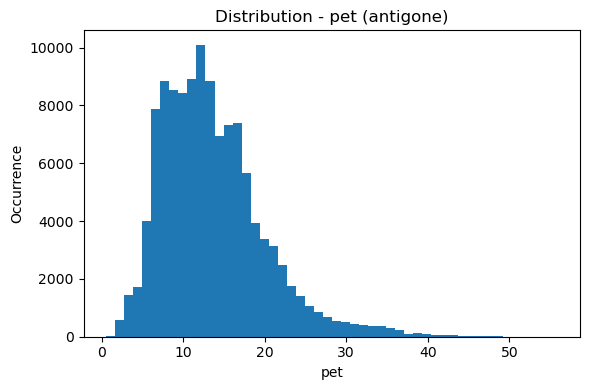

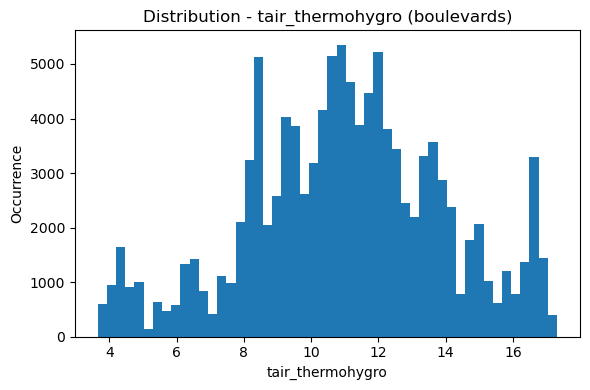

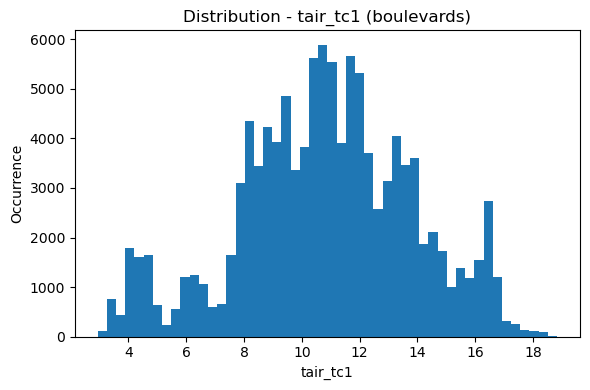

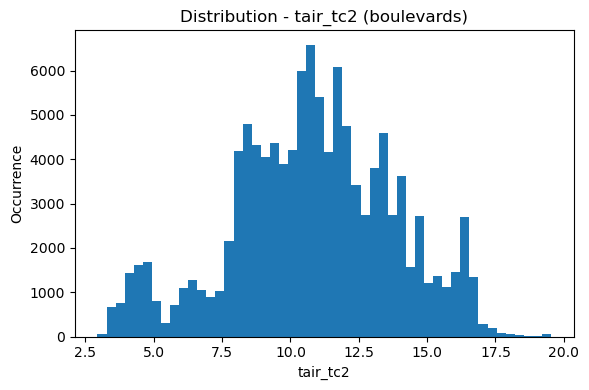

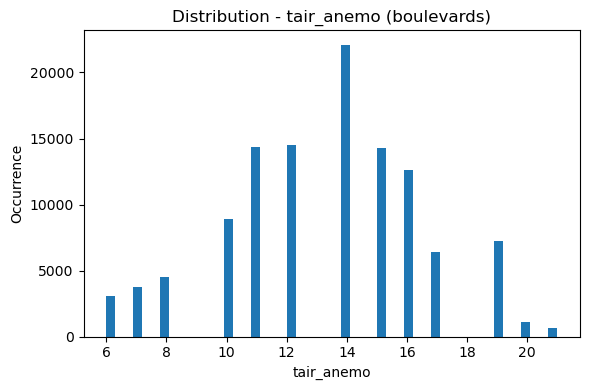

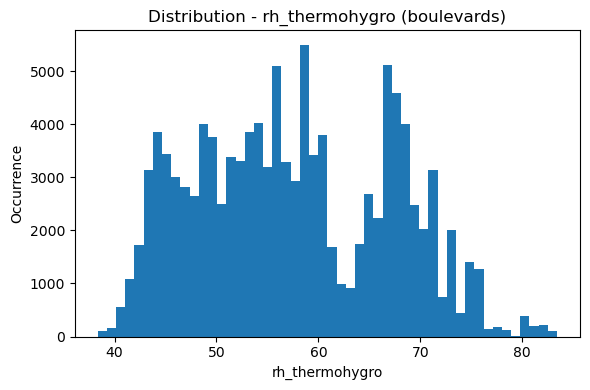

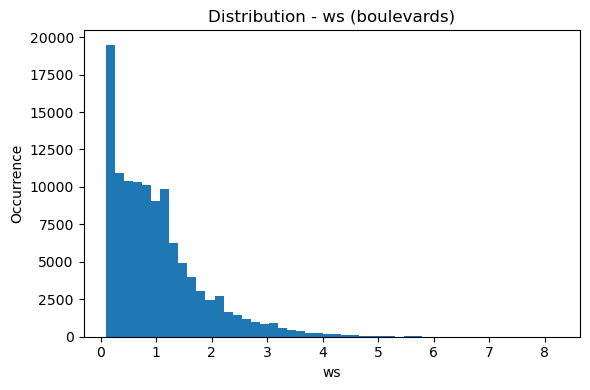

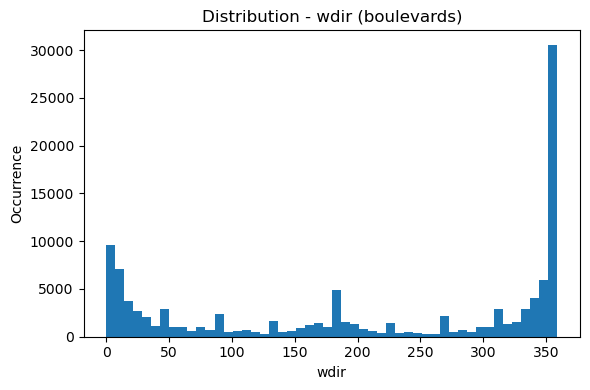

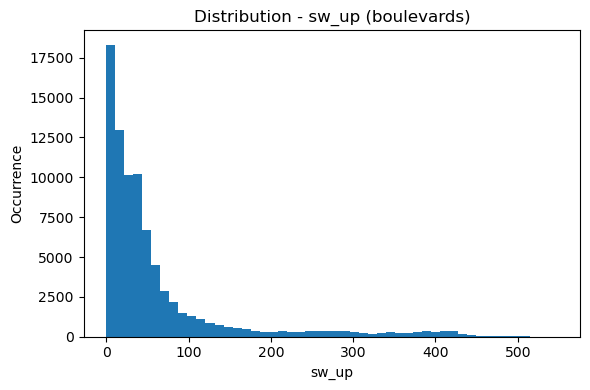

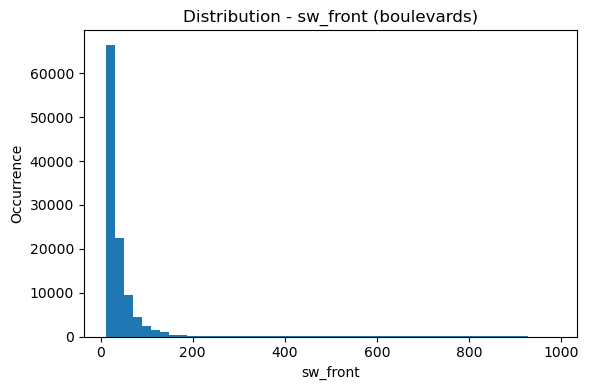

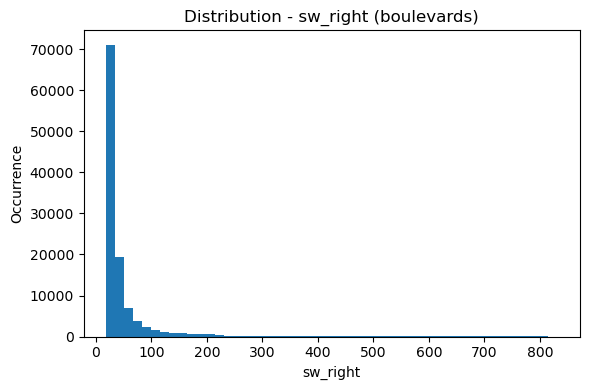

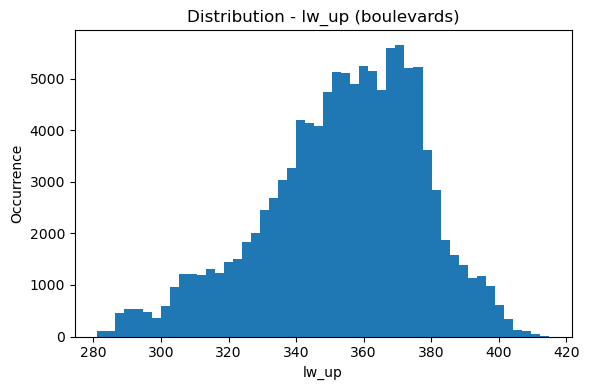

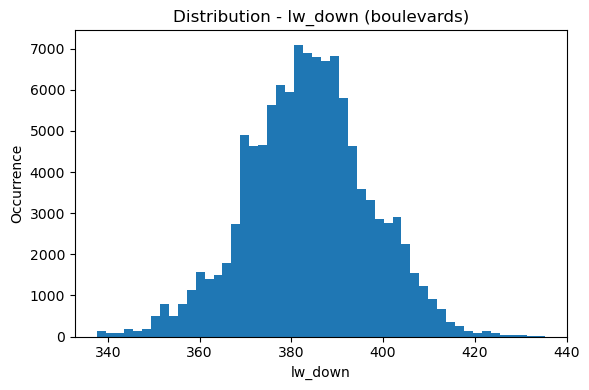

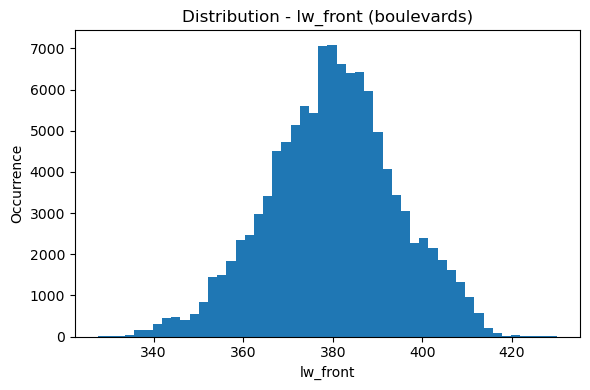

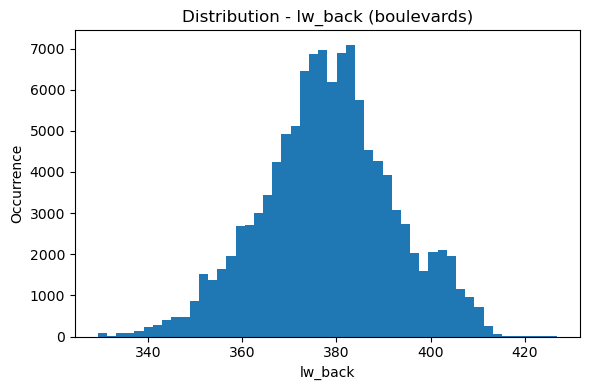

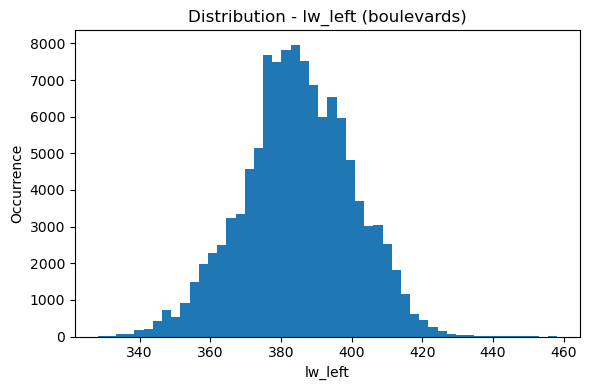

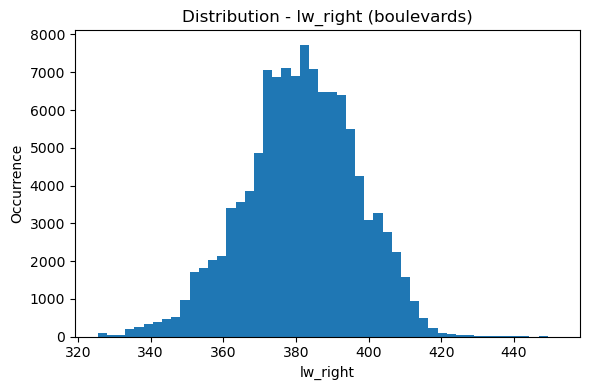

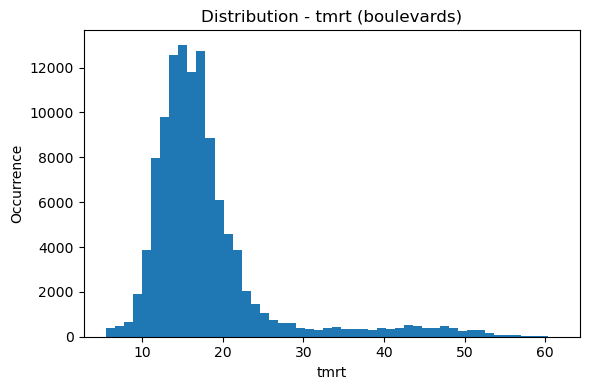

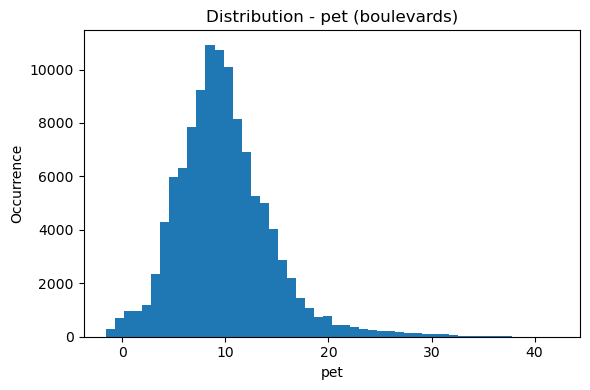

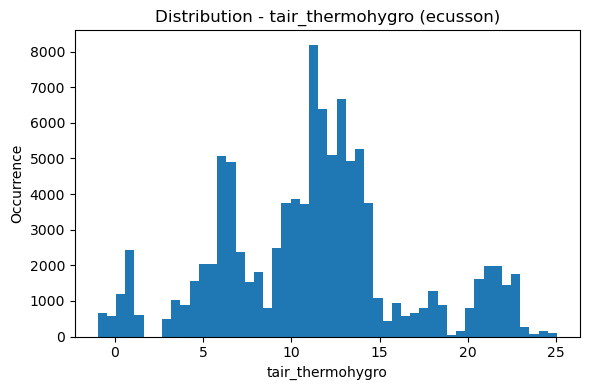

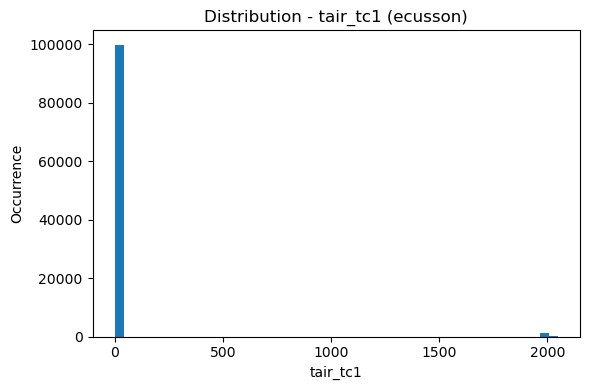

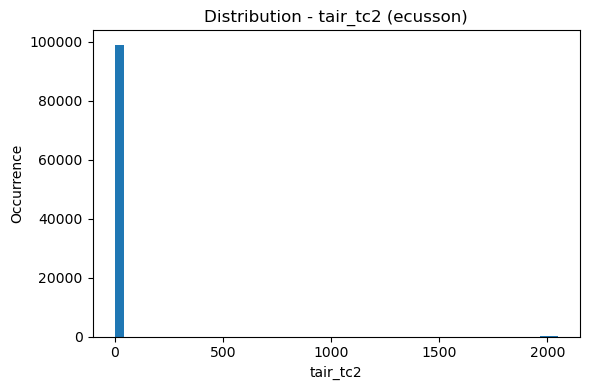

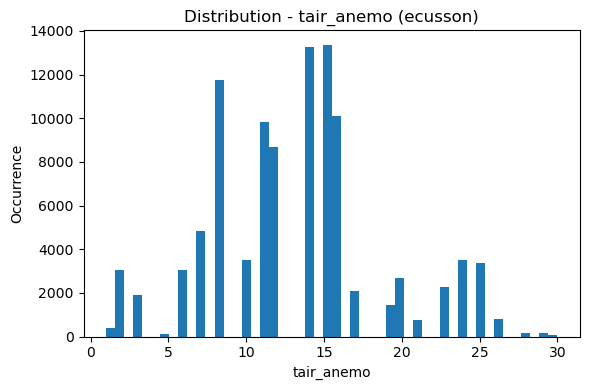

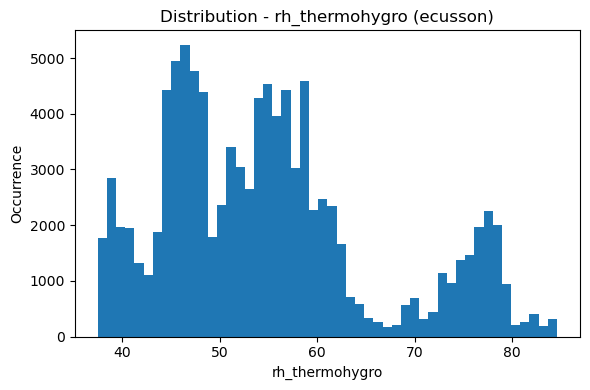

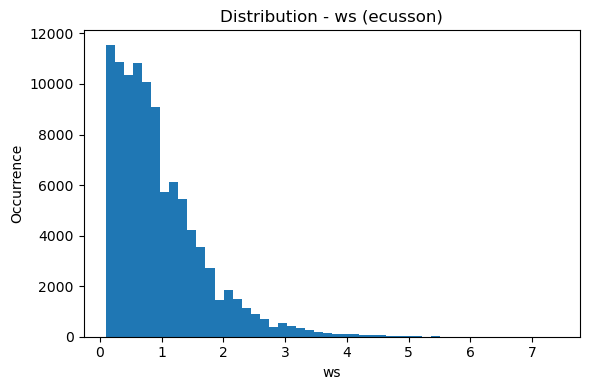

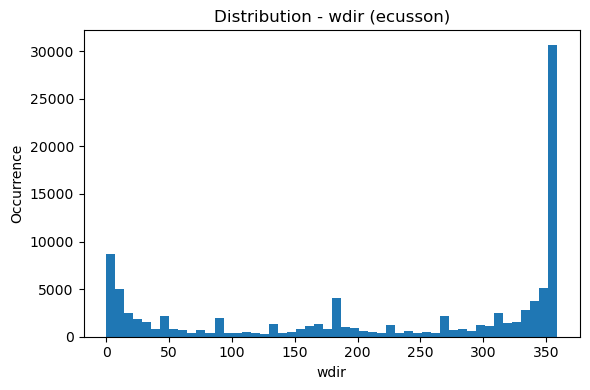

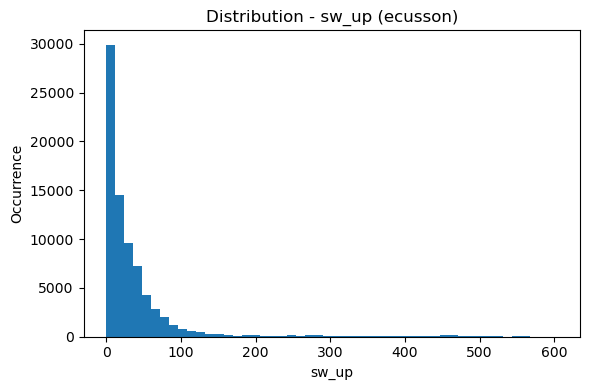

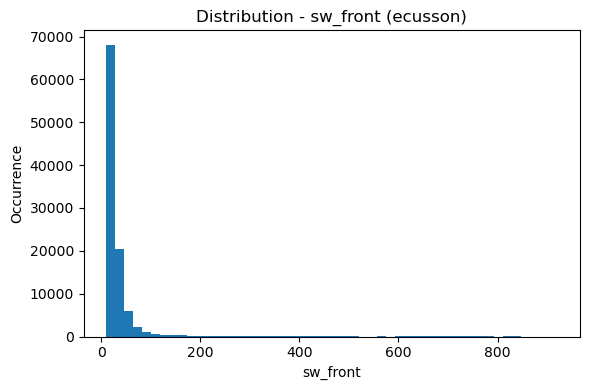

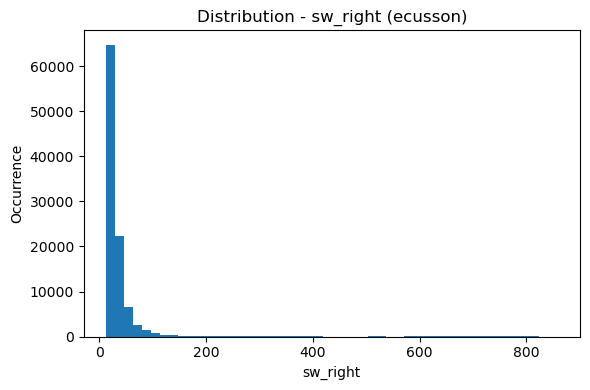

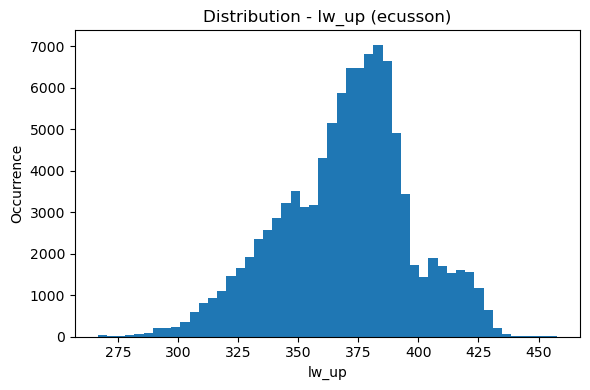

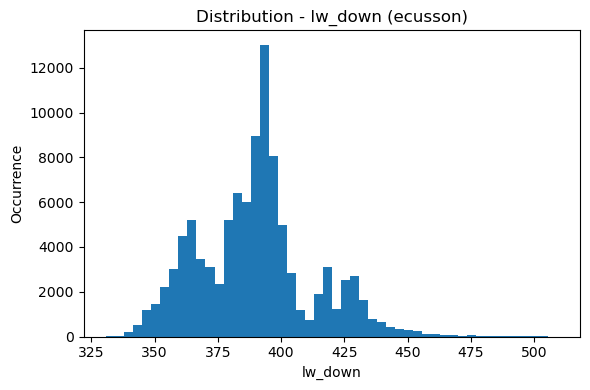

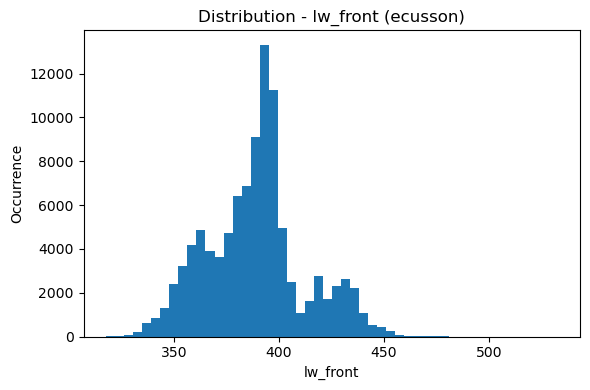

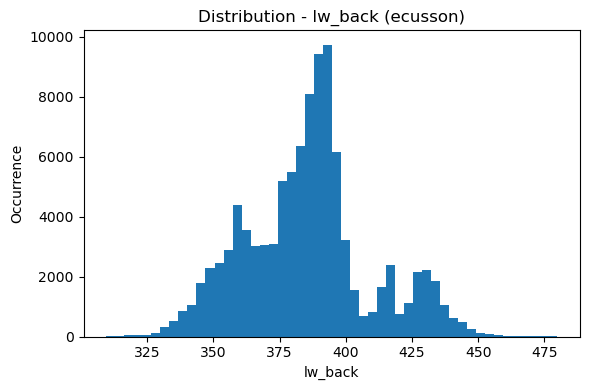

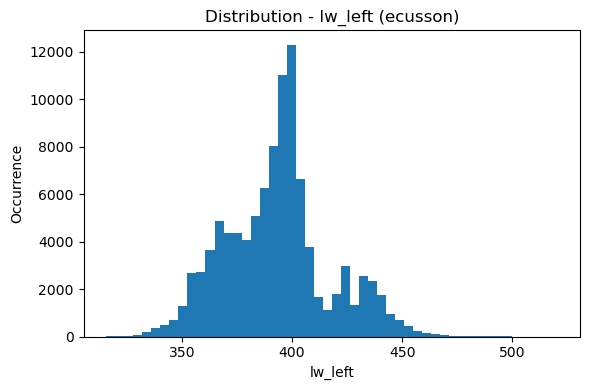

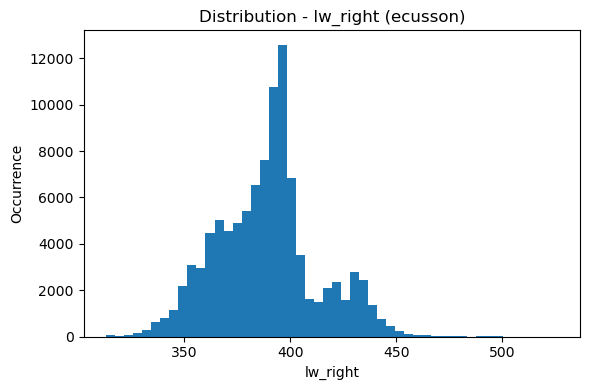

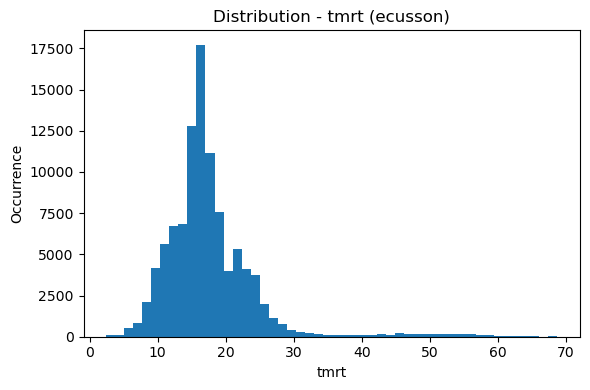

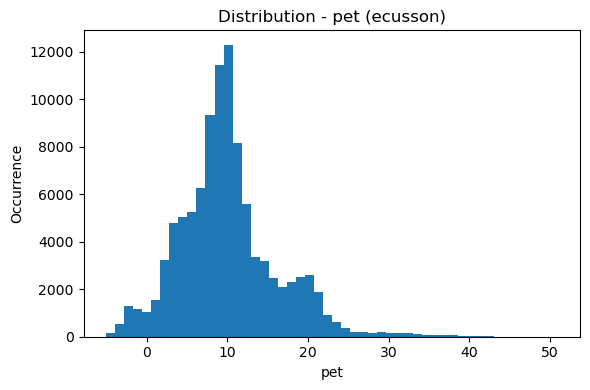

In [45]:
# Distribution de chaque variable par parcours
DISTRIB_P = DISTRIB / "distribution_parcours"
fc.create_folder(DISTRIB_P)

for track in sorted(bd["track_id"].dropna().unique()):
    sub = bd[bd["track_id"] == track]
    
    if sub.empty:
        continue

    OUT_TRACK = DISTRIB_P / track
    fc.create_folder(OUT_TRACK)

    for v in METEO:
        s = sub[v].dropna()
        if len(s) == 0:
            continue

        plt.figure(figsize=(6, 4))
        plt.hist(s, bins=50)
        plt.title(f"Distribution - {v} ({track})")
        plt.xlabel(v)
        plt.ylabel("Occurrence")
        plt.tight_layout()
        plt.savefig(OUT_TRACK / f"dist_{track}_{v}.png", dpi=150)

In [46]:
import math
import gc
import matplotlib
matplotlib.use("Agg")
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colorbar import ColorbarBase

DISTRIB_VAR = DISTRIB / "distributions_variables"
fc.create_folder(DISTRIB_VAR)

COL_MEAN_TRACK = "#E63946"
COL_MEAN_SEC   = "#1D3557"
COL_MEDIAN     = "#F4A261"

cmap = LinearSegmentedColormap.from_list("temp_scale", ["#1D4E89", "white", "#E63946"])

fig, axes = None, None

for track in sorted(bd["track_id"].dropna().unique()):
    sub_track = bd[bd["track_id"] == track]
    sections = sorted(sub_track["section_id"].dropna().unique())
    n_sec = len(sections)

    section_data = {
        sec: sub_track.loc[sub_track["section_id"] == sec]
        for sec in sections
    }

    print(f"Génération des distributions pour {track} ({n_sec} sections)")

    for v in METEO:
        data_all = sub_track[v].dropna()
        if len(data_all) == 0:
            continue

        VAR_DIR = DISTRIB_VAR / v
        fc.create_folder(VAR_DIR)

        # Pré-calcul bornes et statistiques globales
        xmin, xmax = data_all.min(), data_all.max()
        mean_val = data_all.mean()
        median_val = data_all.median()
        std_val = data_all.std()

        # Pré-calcul du y_max
        y_max = 0
        hist_data = {}
        for sec, df in section_data.items():
            s = df[v].dropna()
            if len(s) == 0:
                continue
            counts, bins = np.histogram(s, bins=50, range=(xmin, xmax))
            hist_data[sec] = (s, counts, bins)
            y_max = max(y_max, counts.max())
        y_max *= 1.1

        # Création figure une seule fois
        ncols = min(8, n_sec)
        nrows = math.ceil(n_sec / ncols)
        fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 2.5, nrows * 2.2))
        axes = np.array(axes).reshape(-1)

        # Titre global
        fig.text(0.5, 0.97, f"{track.capitalize()} — {v}",
                 ha="center", va="top", fontsize=16, fontweight="bold")

        for i, sec in enumerate(sections):
            ax = axes[i]
            if sec not in hist_data:
                ax.axis("off")
                continue

            s, counts, bins = hist_data[sec]
            ax.hist(s, bins=50, range=(xmin, xmax), color="skyblue", edgecolor="grey")

            sec_mean = s.mean()
            delta = (sec_mean - mean_val) / std_val

            intensity = min(abs(delta) * 0.5, 0.35)
            if delta > 0:
                ax.set_facecolor((1, 1 - intensity, 1 - intensity))
            else:
                ax.set_facecolor((1 - intensity, 1 - intensity * 0.6, 1))

            ax.axvline(mean_val, color=COL_MEAN_TRACK, linestyle="--", linewidth=1.3)
            ax.axvline(sec_mean, color=COL_MEAN_SEC, linestyle="-", linewidth=1.3)
            ax.axvline(median_val, color=COL_MEDIAN, linestyle=":", linewidth=1.3)

            ax.text(0.98, 0.9, f"{mean_val:.1f}", transform=ax.transAxes,
                    ha="right", va="top", fontsize=6, color=COL_MEAN_TRACK)
            ax.text(0.98, 0.8, f"{sec_mean:.1f}", transform=ax.transAxes,
                    ha="right", va="top", fontsize=6, color=COL_MEAN_SEC)
            ax.text(0.98, 0.7, f"{median_val:.1f}", transform=ax.transAxes,
                    ha="right", va="top", fontsize=6, color=COL_MEDIAN)

            ax.set_title(f"S{int(sec)}", fontsize=8)
            ax.set_xlim(xmin, xmax)
            ax.set_ylim(0, y_max)
            ax.tick_params(axis="both", labelsize=6)

        for j in range(i + 1, len(axes)):
            axes[j].axis("off")

        # Légende
        line_legend = [
            Line2D([0], [0], color=COL_MEAN_TRACK, linestyle="--", lw=1.5, label="Moyenne parcours"),
            Line2D([0], [0], color=COL_MEAN_SEC, linestyle="-", lw=1.5, label="Moyenne section"),
            Line2D([0], [0], color=COL_MEDIAN, linestyle=":", lw=1.5, label="Médiane parcours")
        ]
        fig.legend(handles=line_legend, loc='upper center', bbox_to_anchor=(0.5, 0.942),
                   ncol=3, fontsize=9, frameon=False)

        # Barre de dégradé
        cax = fig.add_axes([0.35, 0.905, 0.3, 0.012])
        norm = plt.Normalize(-2, 2)
        cb = ColorbarBase(cax, cmap=cmap, norm=norm, orientation='horizontal')
        cb.set_ticks([-2, -1, 0, 1, 2])
        cb.ax.tick_params(labelsize=7)
        cb.set_label("Écart à la moyenne du parcours", fontsize=8, labelpad=-1)

        fig.subplots_adjust(top=0.87, bottom=0.05, left=0.05, right=0.95, hspace=0.3, wspace=0.3)
        outfile = VAR_DIR / f"dist_{v}_{track}.png"
        fig.savefig(outfile, dpi=120, bbox_inches="tight")
        plt.close(fig)
        gc.collect()


Génération des distributions pour antigone (47 sections)
Génération des distributions pour boulevards (49 sections)
Génération des distributions pour ecusson (73 sections)


# Profil des variables selon le moment de la journée (M1–M4)

Ce bloc trace, pour chaque variable météo et pour chaques parcours (`Antigone`, `Boulevards`, `Écusson`), l’évolution moyenne des valeurs selon les quatre créneaux horaires de mesure (`M1` à `M4`).

In [54]:
PROFIL = FIG_DIR / "profil"
fc.create_folder(PROFIL)

PROFIL_MEAN_MSLOTS = PROFIL / "comparer_moyenne_mslot"
fc.create_folder(PROFIL_MEAN_MSLOTS)

order = ["M1", "M2", "M3", "M4"]
agg = bd.groupby(["track_id", "M_slot"])[METEO].mean().reset_index()
tracks = ["antigone", "boulevards", "ecusson"]

for v in METEO:
    plt.figure(figsize=(7, 4))
    for t in tracks:
        gg = agg[agg.track_id == t].set_index("M_slot").reindex(order)[v]
        if gg.isna().all():
            continue
        plt.plot(order, gg.values, marker="o", label=t)
    
    plt.title(f"Profil {v}")
    plt.xlabel("Créneau horaire")
    plt.ylabel(v)
    plt.legend()
    plt.tight_layout()
    plt.savefig(PROFIL_MEAN_MSLOTS / f"profil_{v}_Mslots.png", dpi=150)

Maintenant, on souhaite voir un profil pour chaque variable de chaque mesure 

In [55]:
import re
import matplotlib
matplotlib.use("Agg")  
import gc

PROFIL_POINT = FIG_DIR / "profil" / "point"
fc.create_folder(PROFIL_POINT)

fig, ax = plt.subplots(figsize=(9, 4))

for file_name, gfile in bd.groupby("fichier_originaire"):
    m = re.search(r"_(\d{8})_(\d{4})", file_name)

    date_str, time_str = m.groups()
    date_obj = pd.to_datetime(date_str, format="%Y%m%d")
    jour = date_obj.day
    mois = date_obj.strftime("%b").lower()

    track = gfile["track_id"].dropna().iloc[0]
    mslot = gfile["M_slot"].dropna().iloc[0] if "M_slot" in gfile.columns else "UNK"

    OUT_TRACK = PROFIL_POINT / track
    fc.create_folder(OUT_TRACK)

    FOLDER = OUT_TRACK / f"{jour}{mois}_{mslot}"
    fc.create_folder(FOLDER)

    print(f"Génération des profils pour {track} ({mslot}, {jour} {mois})")

    gfile = gfile.sort_values("point_id")

    xticks = np.linspace(0, len(gfile), 6).astype(int)

    for v in METEO:
        if v not in gfile.columns:
            continue
        y = gfile[v].values
        x = gfile["point_id"].values
        if np.all(np.isnan(y)):
            continue

        ax.cla() 
        ax.plot(x, y, color="royalblue", lw=1.2, alpha=0.9)

        ax.set_title(f"{track.capitalize()} — {v} — {mslot} ({jour}/{mois})",
                     fontsize=14, fontweight="bold")
        ax.set_xlabel("point_id")
        ax.set_ylabel(v)
        ax.grid(alpha=0.3)
        ax.set_xticks(xticks)

        outfile = FOLDER / f"profil_{v}_{track}_{jour}{mois}_{mslot}.png"
        fig.tight_layout()
        fig.savefig(outfile, dpi=120, bbox_inches="tight")

    plt.close('all')
    gc.collect()


Génération des profils pour antigone (M1, 29 oct)
Génération des profils pour antigone (M2, 29 oct)
Génération des profils pour antigone (M3, 29 oct)
Génération des profils pour antigone (M4, 29 oct)
Génération des profils pour antigone (M1, 7 nov)
Génération des profils pour antigone (M2, 7 nov)
Génération des profils pour antigone (M3, 7 nov)
Génération des profils pour antigone (M4, 7 nov)
Génération des profils pour antigone (M1, 19 nov)
Génération des profils pour antigone (M2, 19 nov)
Génération des profils pour antigone (M3, 19 nov)
Génération des profils pour antigone (M4, 19 nov)
Génération des profils pour antigone (M1, 28 nov)
Génération des profils pour antigone (M2, 28 nov)
Génération des profils pour antigone (M3, 28 nov)
Génération des profils pour antigone (M4, 28 nov)
Génération des profils pour antigone (M1, 10 dec)
Génération des profils pour antigone (M2, 10 dec)
Génération des profils pour antigone (M3, 10 dec)
Génération des profils pour antigone (M4, 10 dec)
Géné

On compare les différentes dates de mesures selon leur Mslot, afin d'observer les tendances de parcours

In [56]:
import re
import matplotlib
matplotlib.use("Agg")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import gc

COMPARE_M = FIG_DIR / "profil" / "comparer_meme_Mslot"
fc.create_folder(COMPARE_M)

cmap = get_cmap("tab10")

for track in sorted(bd["track_id"].dropna().unique()):
    sub_track = bd[bd["track_id"] == track]
    OUT_TRACK = COMPARE_M / track
    fc.create_folder(OUT_TRACK)

    for mslot in sorted(sub_track["M_slot"].dropna().unique()):
        sub_slot = sub_track[sub_track["M_slot"] == mslot]
        OUT_M = OUT_TRACK / mslot
        fc.create_folder(OUT_M)

        print(f"Génération du profil comparatif pour {track} ({mslot})")

        for v in METEO:
            fig, ax = plt.subplots(figsize=(9, 4))
            legends = []

            for i, (fname, gfile) in enumerate(sub_slot.groupby("fichier_originaire")):
                m = re.search(r"_(\d{8})_(\d{4})", fname)
                if not m:
                    continue
                date_str, time_str = m.groups()
                date_obj = pd.to_datetime(date_str, format="%Y%m%d")
                date_label = date_obj.strftime("%d/%m")

                data = gfile.sort_values("point_id")[["point_id", v]]
                if data[v].isna().all():
                    continue

                x = data["point_id"].values
                y = data[v].values

                color = cmap(i % 10)
                ax.plot(x, y, lw=1.2, alpha=0.9, color=color)
                legends.append(date_label)

            if not legends:
                plt.close(fig)
                continue

            ax.set_title(f"{track.capitalize()} — {v} — {mslot}",
                         fontsize=14, fontweight="bold")
            ax.set_xlabel("point_id")
            ax.set_ylabel(v)
            ax.grid(alpha=0.3)
            ax.legend(legends, loc="upper center", fontsize=8, frameon=False,
                      ncol=5, bbox_to_anchor=(0.5, -0.2))

            outfile = OUT_M / f"profil_compare_{v}_{track}_{mslot}.png"
            fig.tight_layout(rect=[0, 0, 1, 0.92])
            fig.savefig(outfile, dpi=120, bbox_inches="tight")
            plt.close(fig)
            gc.collect()

/var/folders/xz/8qmtfxds1qdftctg_8qnbryr0000gn/T/ipykernel_7642/3517023275.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap("tab10")


Génération du profil comparatif pour antigone (M1)
Génération du profil comparatif pour antigone (M2)
Génération du profil comparatif pour antigone (M3)
Génération du profil comparatif pour antigone (M4)
Génération du profil comparatif pour boulevards (M1)
Génération du profil comparatif pour boulevards (M2)
Génération du profil comparatif pour boulevards (M3)
Génération du profil comparatif pour boulevards (M4)
Génération du profil comparatif pour ecusson (M1)
Génération du profil comparatif pour ecusson (M2)
Génération du profil comparatif pour ecusson (M3)
Génération du profil comparatif pour ecusson (M4)


Même idée ici, mais on vient comparer les différents Mslots sur une même journée

In [57]:
import re
import matplotlib
matplotlib.use("Agg")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import gc

COMPARE_D = FIG_DIR / "profil" / "comparer_meme_date"
fc.create_folder(COMPARE_D)

cmap = get_cmap("tab10")  

for track in sorted(bd["track_id"].dropna().unique()):
    sub_track = bd[bd["track_id"] == track]
    OUT_TRACK = COMPARE_D / track
    fc.create_folder(OUT_TRACK)

    dates = []
    for f in sub_track["fichier_originaire"].unique():
        m = re.search(r"_(\d{8})_(\d{4})", f)
        if m:
            dates.append(m.group(1))
    dates = sorted(set(dates))

    for date_str in dates:
        date_obj = pd.to_datetime(date_str, format="%Y%m%d")
        jour = date_obj.day
        mois = date_obj.strftime("%b").lower()  # ex: "oct", "nov"

        OUT_DATE = OUT_TRACK / f"{jour}{mois}"
        fc.create_folder(OUT_DATE)

        print(f"Génération du profil comparatif pour {track} — {jour}{mois}")

        mask_date = bd["fichier_originaire"].str.contains(date_str)
        sub_date = bd[mask_date & (bd["track_id"] == track)]

        for v in METEO:
            fig, ax = plt.subplots(figsize=(9, 4))
            legends = []

            for i, (mslot, gslot) in enumerate(sub_date.groupby("M_slot")):
                data = gslot.sort_values("point_id")[["point_id", v]]
                if v not in data.columns or data[v].isna().all():
                    continue

                x = data["point_id"].values
                y = data[v].values

                color = cmap(i % 10)
                ax.plot(x, y, lw=1.2, alpha=0.9, color=color)
                legends.append(mslot)

            if not legends:
                plt.close(fig)
                continue

            ax.set_title(f"{track.capitalize()} — {v} — {jour}{mois}",
                         fontsize=14, fontweight="bold")
            ax.set_xlabel("point_id")
            ax.set_ylabel(v)
            ax.grid(alpha=0.3)
            ax.legend(legends, loc="upper center", fontsize=8, frameon=False,
                      ncol=5, bbox_to_anchor=(0.5, -0.2))

            outfile = OUT_DATE / f"profil_compare_{v}_{track}_{jour}{mois}.png"
            fig.tight_layout(rect=[0, 0, 1, 0.92])
            fig.savefig(outfile, dpi=120, bbox_inches="tight")
            plt.close(fig)
            gc.collect()

/var/folders/xz/8qmtfxds1qdftctg_8qnbryr0000gn/T/ipykernel_7642/3655550896.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap("tab10")


Génération du profil comparatif pour antigone — 29oct
Génération du profil comparatif pour antigone — 7nov
Génération du profil comparatif pour antigone — 19nov
Génération du profil comparatif pour antigone — 28nov
Génération du profil comparatif pour antigone — 10dec
Génération du profil comparatif pour antigone — 19dec
Génération du profil comparatif pour antigone — 9jan
Génération du profil comparatif pour boulevards — 14nov
Génération du profil comparatif pour boulevards — 26nov
Génération du profil comparatif pour boulevards — 5dec
Génération du profil comparatif pour boulevards — 17dec
Génération du profil comparatif pour boulevards — 7jan
Génération du profil comparatif pour boulevards — 16jan
Génération du profil comparatif pour ecusson — 31oct
Génération du profil comparatif pour ecusson — 12nov
Génération du profil comparatif pour ecusson — 21nov
Génération du profil comparatif pour ecusson — 3dec
Génération du profil comparatif pour ecusson — 12dec
Génération du profil compa

# Barmean des variables météo par parcours

Ce bloc compare la `moyenne des variables météorologiques` entre les trois parcours étudiés : `Antigone`, `Boulevards` et `Écusson`.

In [58]:
BARMEAN = FIG_DIR / "bar_mean"
fc.create_folder(BARMEAN)

comp = (bd[bd["track_id"].isin(["antigone", "boulevards", "ecusson"])]
          .groupby("track_id")[METEO]
          .mean()
          .T)

for v in comp.index:
    plt.figure(figsize=(6, 4))
    plt.bar(comp.columns.astype(str), comp.loc[v].values)
    plt.title(f"Moyenne par parcours - {v}")
    plt.xlabel("Parcours")
    plt.ylabel(v)
    plt.tight_layout()
    plt.savefig(BARMEAN / f"bar_mean_{v}_parcours.png", dpi=150)